# Multilabel Tag Prediction 

<h1>1. Problem Statement</h1>

### Description:-
- To compute cosine similarity between query and whole dataset is computationally very expensive. 
- On our dataset its taking around 4.5 mins to retrieve top 5 similar questions which doesnt satisfy latency constraint of our original problem.


<h2>2. AIM </h2>
- To build Tag prediction model which will predict tags for a given user query.
- So we can filter out huge question corpus based on catergory and compute cosine similarity over reduced subsapce which would be faster comparatively.


<h2>3. Real World / Business Objectives and Constraints </h2>
1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could will change whole result set for user. If tags are incorrect user would not get similar questions result n hence user experience would be impacted.
3. Strict latency constraints as based on tag we can filter out dataset and retrieve similar questions.

<h2>4. Machine Learning problem </h2>
- Given problem maps to Multilabel Classification under supervised learning category.
- <b>Multi-label Classification</b>: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. <br>
__Credit__: http://scikit-learn.org/stable/modules/multiclass.html
</p>

<h3>4.2 Performance metric </h3>

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>



https://www.kaggle.com/wiki/MeanFScore <br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import gensim
#import swifter
import pandas as pd
import numpy as np
import re
import bs4
import pickle

from tqdm import tqdm
tqdm.pandas()

### Split Dataset into Train and Text
from sklearn.model_selection import train_test_split
# Feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# ML Pkgs
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score

from sklearn.metrics import accuracy_score,hamming_loss,classification_report

# Multi Label Pkgs
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

from skmultilearn.adapt import MLkNN

import nltk
from nltk.corpus import stopwords
# import these modules
from nltk.stem import WordNetLemmatizer

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

### Text Preprocessing

In [2]:
# # https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


def text_preprocessing(text):
    '''This function does text preprocessing 
       It includes removal of html tags,
       converting to lowercase, 
       decontraction and 
       removal of any non alphanumeric characters.
       
       Function takes one parameter - text
       returns - preprocessed text
    '''
    
    # Some titles (~42) start with '<' but doesnt have closing '>'. 
    #eg: #text = '<asp: RegularExpressionValidator and RegexOptions.IgnorePatternWhitespace'
    # beautifulsoup gives emppty string on such text so remove '<' before removing html tags from titles.
    text = text.replace("<","")
    # Remove html tags from question corpus
    text = bs4.BeautifulSoup(text, 'lxml').get_text()
    # Convert each word to lowercase
    text = text.lower()
    # text decontraction. eg: won't to will not. Can't to cannot
    text = decontracted(text)
    # Remove any non-alphanumeric characters if present
    #text = re.sub('\W', ' ',text).strip()
    text = re.sub("[^a-zA-Z'.+# ]+", '', text) # kepping + for c++, . for .net, vb.net etc, # for C#
    
  

    # why lemmatization is choose over stemming
    #https://stackoverflow.com/questions/1787110/what-is-the-difference-between-lemmatization-vs-stemming
    # Lemmatization   
    lemmatizer = WordNetLemmatizer()
    
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    
    text = text.strip()
    return text


### Data Loading

In [3]:
%%time
df = pd.read_csv('Final_df.csv')
df.shape, df.columns

CPU times: user 27.5 s, sys: 5.98 s, total: 33.5 s
Wall time: 41.3 s


((1000000, 9),
 Index(['PostTypeId', 'Question_Id', 'Title', 'Tags', 'AnswerCount',
        'ViewCount', 'Body', 'Score', 'Answer_corpus'],
       dtype='object'))

### Data Cleaning
- Considering only titles for tag prediction.

In [4]:
%%time
df['Cleaned_Titles'] = df['Title'].progress_apply(lambda x: text_preprocessing(x))

df = df[df['Cleaned_Titles']!='']

100%|██████████| 1000000/1000000 [05:43<00:00, 2913.98it/s]


CPU times: user 5min 35s, sys: 10.9 s, total: 5min 46s
Wall time: 5min 43s


In [5]:
df[df['Cleaned_Titles']!=''].shape

(999999, 10)

In [6]:
df['Cleaned_Titles'].head()

0    how do i calculate someone is age based on a d...
1                        calculate relative time in c#
2                         determine a user is timezone
3      difference between math.floor and math.truncate
4    filling a dataset or a datatable from a linq q...
Name: Cleaned_Titles, dtype: object

### Cleaning Tags - Target variable

In [7]:
df['Tags'].head()

0                                 <c#><.net><datetime>
1    <c#><datetime><time><datediff><relative-time-s...
2    <html><browser><timezone><user-agent><timezone...
3                                         <.net><math>
4                   <c#><linq><web-services><.net-3.5>
Name: Tags, dtype: object

In [8]:
# re.findall('\<.*?\>','<java><oracle><hibernate>') returns list ['<java>', '<oracle>', '<hibernate>']
# Iterate over list and remove <> brackets.
# Join all tags with space

df['Cleaned_Tags'] = df['Tags'].progress_apply(lambda x: ' '.join(word.replace("<","").replace(">","") for word in re.findall('\<.*?\>',x)))
# 2 rows contains null tags,remove them
df = df[df['Tags'] != '<null>']

100%|██████████| 999999/999999 [00:07<00:00, 140196.71it/s]


In [9]:
df.shape

(999997, 11)

In [10]:
df.isnull().sum()

PostTypeId        0
Question_Id       0
Title             0
Tags              0
AnswerCount       0
ViewCount         0
Body              0
Score             0
Answer_corpus     0
Cleaned_Titles    0
Cleaned_Tags      0
dtype: int64

In [104]:
%%time
df.to_csv("Cleaned_title_tags.csv", index=False)

CPU times: user 1min 47s, sys: 2.66 s, total: 1min 50s
Wall time: 1min 52s


In [11]:
df['Cleaned_Tags'].head()

0                                    c# .net datetime
1        c# datetime time datediff relative-time-span
2    html browser timezone user-agent timezone-offset
3                                           .net math
4                       c# linq web-services .net-3.5
Name: Cleaned_Tags, dtype: object

### Brief EDA for problem statement.
Refer EDA.ipynb to have  a look at complete EDA

In [12]:
%%time

# question related to for loop could be there. So do not remove word ' for' from vocab.
# between functions exists in many programming langugage.
# to and from should not be removed.
# nor operator should not be removed.

stopwords = stopwords.words('english')
final_stopwords = list(set(stopwords) - set(['for', 'between', 'to', 'from', 'nor']))
final_stopwords.append('would')


#'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(),stop_words = final_stopwords)

# fit function learns the vocabulary; 
vectorizer.fit(df['Cleaned_Tags'])

######### Get count of each tags ####################################
# Create bow matrix - each of unique tags will be columns and each row will have 1 corresponding to tags present in that question
y= vectorizer.fit_transform(df['Cleaned_Tags'])

#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
print("Unique number of tags: ", len(tags))
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:20])

Unique number of tags:  23729
Some of the tags we have : ['.a', '.app', '.aspxauth', '.bash-profile', '.class-file', '.doc', '.emf', '.htaccess', '.htpasswd', '.ico', '.lib', '.mobi', '.mov', '.net', '.net-1.0', '.net-1.1', '.net-2.0', '.net-3.0', '.net-3.5', '.net-4.0']
CPU times: user 11 s, sys: 57.7 ms, total: 11.1 s
Wall time: 11.1 s


### Observation
- We have around 23K unique tags.

In [13]:
# If we sum over each tag column we will have tag frequency
tag_freq = y.sum(axis=0).A1 # .A1 returns flattened array of matrix

tag_df = pd.DataFrame({'Tags':tags, 'Counts':tag_freq})
tag_df.head()

,Counts,Tags
0,3,.a
1,7,.app
2,6,.aspxauth
3,7,.bash-profile
4,13,.class-file


In [14]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values
tag_df_sorted.head()

,Counts,Tags
2448,120108,c#
10177,75789,java
15303,68164,php
10245,59117,javascript
13,56209,.net


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(tag_counts)
plt.grid()
plt.title("Distribution Of Tag Frequency")
plt.xlabel("Tag Number")
plt.ylabel("Tag Count")
plt.show()

Text(0, 0.5, 'Tag Count')

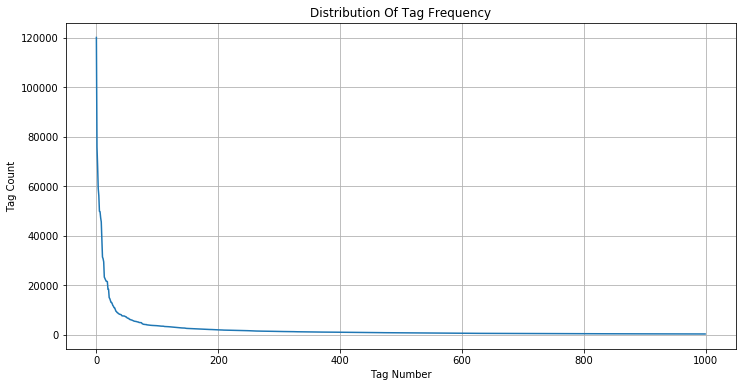

In [16]:
plt.figure(figsize=(12,6))
plt.plot(tag_counts[0:1000])
plt.grid()
plt.title("Distribution Of Tag Frequency")
plt.xlabel("Tag Number")
plt.ylabel("Tag Count")

In [17]:
#Get a high level statistical view of the tags data
tag_df_sorted.describe()

,Counts
count,23729.000000
mean,120.325214
std,1508.651069
min,1.000000
25%,3.000000
50%,7.000000
75%,25.000000
max,120108.000000


In [18]:
percentiles = range(0,100,10)

for p in percentiles:
    print("{}th percentile: {}".format(p,np.percentile(tag_counts,p)))

print("---------------------------------------------------------------")
percentiles_90 = range(71,80)
for p in percentiles_90:
    print("{}th percentile: {}".format(p,np.percentile(tag_counts,p)))
    

0th percentile: 1.0
10th percentile: 1.0
20th percentile: 2.0
30th percentile: 3.0
40th percentile: 5.0
50th percentile: 7.0
60th percentile: 11.0
70th percentile: 18.0
80th percentile: 36.0
90th percentile: 106.0
---------------------------------------------------------------
71th percentile: 19.0
72th percentile: 20.0
73th percentile: 21.0
74th percentile: 23.0
75th percentile: 25.0
76th percentile: 26.0
77th percentile: 28.0
78th percentile: 31.0
79th percentile: 33.0


### Observation:-
- Tags frequency distribution is highly positive skewed.
- 80% of data have tags occuring less then 36 times.
- Inshort we have some broader category of tags mostly programming languages which occur more frequently then sub-category tags.

In [19]:
#Storing the count of tag in each question in list 'tag_count'
df['Tags_Count_per_question'] = df['Cleaned_Tags'].str.split().apply(len)

In [21]:
df['Tags_Count_per_question'].unique()

array([3, 5, 2, 4, 1, 6])

### Observation:-
- Questions contains number of tags ranging from 1 to 6.
- Maximum one question have 6 tags.


## Data Featurization

### Experiment 1: Tfidf features

### Load preprocessed data

In [5]:
%%time
df = pd.read_csv("Cleaned_title_tags.csv")
print(df.shape)
print(df.isnull().sum())
df.dropna(inplace=True)

(999998, 11)
PostTypeId        0
Question_Id       0
Title             0
Tags              0
AnswerCount       0
ViewCount         0
Body              0
Score             0
Answer_corpus     0
Cleaned_Titles    1
Cleaned_Tags      0
dtype: int64
CPU times: user 29.3 s, sys: 2.86 s, total: 32.1 s
Wall time: 41.6 s


### Stopwords Removal

In [6]:
# question related to for loop could be there. So do not remove word ' for' from vocab.
# between functions exists in many programming langugage.
# to and from should not be removed.
# nor operator should not be removed.

stop_words = stopwords.words('english')
final_stopwords = list(set(stop_words) - set(['for', 'between', 'to', 'from', 'nor']))
final_stopwords.append('would')

In [7]:
tfidf_vec = TfidfVectorizer(tokenizer = lambda x: x.split(),stop_words=final_stopwords, max_features=20000)
print(tfidf_vec)
tfidf_matrix = tfidf_vec.fit_transform(df['Cleaned_Titles'])
tfidf_matrix.shape

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=20000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['having', 'll', 'we', 'hadn', 'or', "should've",
                            'yourself', 'hasn', 'in', 'haven', 'further', 't',
                            'you', 'they', 'being', 'had', 'on', 're', "you've",
                            'its', 'an', 'other', "mightn't", 'me', 'by', 'too',
                            "weren't", "shouldn't", 'she', 'him', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function <lambda> at 0x7f736410f0d0>, use_idf=True,
                vocabulary=None)


(999997, 20000)

- In total 1 lakh 59 tf-idf features exists (unique words in cleaned_titles) exists. Experimented but number of feature
is very large to fit in memory so only top 20K features are selected.

### Computing Target 
- As per Tag frequency eda we know tags count have high positively skewed distribution.
- Top 1000 frequent tags are taken out of 23K due to computational resource constraints.

In [8]:
%%time
# Convert target variable in to one_hot vector
bow_vec = CountVectorizer(tokenizer = lambda x: x.split(' '),stop_words = final_stopwords, max_features=1000, binary=True)
y = bow_vec.fit_transform(df['Cleaned_Tags'])
y.shape

CPU times: user 5.55 s, sys: 13.7 ms, total: 5.56 s
Wall time: 5.56 s


(999997, 1000)

### Saving target dump for future use


In [4]:
import pickle
def dump_intermediate_results(variable, filename):
    '''Function dumps object using pickle library in same format as you provide.
       Parameters: 1) variable = object to be dumped. If object is dataframe it is dumped as dataframe only.
                   2) filename = Name of the file of user's choice.
                   
    '''
    with open(filename, 'wb') as f:
        pickle.dump(variable,f )
        
def load_intermediate_results(filename):
    '''Funciton loads pickle object from the file in the same form it was dumped.
       Parameters: filename: Name of the file from which object is to be loaded.
       Returns: loaded object.
    '''
    with open(filename,'rb') as fp:
        result = pickle.load(fp)
        return result

In [17]:
dump_intermediate_results(y, 'target_y_tfidf.pkl')
dump_intermediate_results(tfidf_matrix, 'X_tfidf.pkl')

y = load_intermediate_results('target_y_tfidf.pkl')
X = load_intermediate_results('X_tfidf.pkl')

## Train-Test Split


### Multilabel stratification

Reference link: https://pypi.org/project/iterative-stratification/
- Max features 1000 are selected based on frequency.
- Data will be splitted based on stratified sampling of tags. Eg: If <python> tags occurs in 20% of train data points then same proportions will be maintained in test set also.


Example:- 
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
msk = MultilabelStratifiedKFold(n_splits=5, random_state=33) # so we divided data into 80-20%

print(msk) #MultilabelStratifiedKFold(n_splits=5, random_state=33, shuffle=False)
data_generator = msk.split(y[0:10, :].toarray(), y[0:10, :].toarray()) #requires dense array

a,b = next(data_generator) # returns index of train and test
Output: a,b #(array([0, 1, 2, 4, 5, 6, 7, 9]), array([3, 8]))


In [12]:
%%time
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
msk = MultilabelStratifiedKFold(n_splits=5, random_state=33) # so we divided data into 80-20%


#Ideally X,y should be passed, but throws memory error, so we will take index for y and filter X later.
#requires dense array
data_generator = msk.split(y.toarray(), y.toarray())

ytrain_index,ytest_index = next(data_generator) # returns index of train and test
ytrain_index.shape,ytest_index.shape

CPU times: user 17min 23s, sys: 2min 8s, total: 19min 32s
Wall time: 19min 32s


((799998,), (199999,))

In [14]:
dump_intermediate_results(ytrain_index, 'ytrain_index1.pkl')
dump_intermediate_results(ytest_index, 'ytest_index1.pkl')


In [15]:
ytrain_index = load_intermediate_results('ytrain_index1.pkl')
ytest_index = load_intermediate_results('ytest_index1.pkl')

In [18]:

y_train = y[ytrain_index]
y_test = y[ytest_index]

X_train = X[ytrain_index]
X_test = X[ytest_index]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((799998, 20000), (199999, 20000), (799998, 1000), (199999, 1000))

## Modelling

Reference link: https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/
### Multi-label Classification
![](multi-class_vs_multi_label_classification_jcharistech.png)

#### Solution for Multi-Label Problem
+ Methods for solving Multi-label Classification Problems
    + Problem Transformation
    + Adapted Algorithm
    + Ensemble approaches

#### Problem Transformation
+ It refers to transforming the multi-label problem into single-label problem(s) by using
    - Binary Relevance: treats each label as a separate single class classification
    - Classifier Chains:In this, the first classifier is trained just on the input data and then each next classifier is trained on the input space and all the previous classifiers in the chain.
    - Label Powerset:we transform the problem into a multi-class problem with one multi-class classifier is trained on all unique label combinations found in the training data.

        
#### Adapted Algorithm
+ adapting the algorithm to directly perform multi-label classification, rather than transforming the problem into different subsets of problems.




   

### Modelling on our dataset

All the techniques mentioned under Problem Transormation is available in scikit-multilearn package.
#### Label powerset technique 
- It makes sense compared to other techniques, as we have very large number of tags. 
- Experimented with Labelpowerset technique:-
    - skmultilearn package converts sparse matrix to dense for internal computations.
    - Due to above reason, had memory issues.


In [ ]:
# %%time
# # taking 10k tfidf features and 1000 tags - memory error.


# # %%time
# from skmultilearn.adapt import MLTSVM
# svm_classifier = MLTSVM()
# svm_classifier.fit(X_train, y_train)


# tag_classifier = LabelPowerset(MultinomialNB())
# # train
# tag_classifier.fit(X_train, y_train)
# # predict
# predictions = tag_classifier.predict(X_test)
# # accuracy
# print("Accuracy = ",accuracy_score(y_test,predictions))
# print("\n")

In [23]:
import gc
del df,X,y,tfidf_matrix
gc.collect()

375

### OneVsRestClassifier To Rescue:

Reference link: https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

- This method internally uses binary relevance technique which involves training individual models for each target label.

In [24]:
%%time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score


classifier = OneVsRestClassifier(SGDClassifier(loss='log'), n_jobs=-1)
classifier.fit(X_train, y_train)

CPU times: user 6.41 s, sys: 4.57 s, total: 11 s
Wall time: 6min 53s


OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal', loss='log',
                                            max_iter=1000, n_iter_no_change=5,
                                            n_jobs=None, penalty='l2',
                                            power_t=0.5, random_state=None,
                                            shuffle=True, tol=0.001,
                                            validation_fraction=0.1, verbose=0,
                                            warm_start=False),
                    n_jobs=-1)

## Prediction

In [38]:
y_predicted_prob = classifier.predict_proba(X_test)
y_predicted = classifier.predict(X_test)

In [34]:
y_predicted_prob.shape

(199999, 1000)

In [35]:
y_test.shape, y_predicted_prob.shape

((199999, 1000), (199999, 1000))

### Evaluation

Along with F1 Score other measures such as accuracy,classifiaction report and hamming loss are also computed.
#### Hamming loss
Reference link: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html

It calculates number of places where prediction and true label doesnt match and gives percentage of incorrect labels predicted.
It  is the fraction of labels that are incorrectly predicted
Example:-
from sklearn.metrics import hamming_loss
y_pred = [0,0,1,1]
y_true = [0,0,0,0]
hamming_loss(y_true, y_pred) 

Output: 0.5 -> 50% of labels are predicted incorrectly.


In [39]:
y_predicted = classifier.predict(X_test)

print("Accuracy :",metrics.accuracy_score(y_test,y_predicted ))
print("Hamming loss ",metrics.hamming_loss(y_test,y_predicted ))


precision = precision_score(y_test, y_predicted , average='micro')
recall = recall_score(y_test, y_predicted , average='micro')
f1 = f1_score(y_test, y_predicted , average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, y_predicted , average='macro')
recall = recall_score(y_test, y_predicted , average='macro')
f1 = f1_score(y_test, y_predicted , average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, y_predicted ))


Accuracy : 0.07710038550192751
Hamming loss  0.0020383051915259577
Micro-average quality numbers
Precision: 0.9034, Recall: 0.1278, F1-measure: 0.2239


/home/satishshah2660/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/satishshah2660/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/satishshah2660/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Macro-average quality numbers
Precision: 0.0866, Recall: 0.0102, F1-measure: 0.0160
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       556
           1       0.72      0.11      0.19     11242
           2       0.00      0.00      0.00       252
           3       0.00      0.00      0.00       552
           4       0.00      0.00      0.00       281
           5       0.00      0.00      0.00        82
           6       0.00      0.00      0.00       222
           7       0.00      0.00      0.00       246
           8       0.00      0.00      0.00        87
           9       0.00      0.00      0.00        99
          10       0.00      0.00      0.00       438
          11       0.00      0.00      0.00       108
          12       1.00      0.00      0.01      1531
          13       0.00      0.00      0.00       229
          14       0.00      0.00      0.00       451
          15       0.00      0.00      0.00       1

/home/satishshah2660/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/satishshah2660/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


### Observations:-
- Precision: 0.9034
- Recall: 0.1278
- Micro F1-measure: 0.2239

- We are having high precision for our trained model which suggests true positives/predicted positives ratio is good.
- On the other hand recall is very low which suggests ratio of true positives/ total positives is low.
- Overall F1 score is 0.22 which is low due to low recall. 
- Model performance should be improved.

In [40]:
%%time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score


classifier2 = OneVsRestClassifier(SGDClassifier(loss='hinge'), n_jobs=-1)
classifier2.fit(X_train, y_train)

CPU times: user 6.57 s, sys: 4.51 s, total: 11.1 s
Wall time: 5min 47s


OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal',
                                            loss='hinge', max_iter=1000,
                                            n_iter_no_change=5, n_jobs=None,
                                            penalty='l2', power_t=0.5,
                                            random_state=None, shuffle=True,
                                            tol=0.001, validation_fraction=0.1,
                                            verbose=0, warm_start=False),
                    n_jobs=-1)

In [41]:
y_predicted2 = classifier2.predict(X_test)

print("Accuracy :",metrics.accuracy_score(y_test,y_predicted2 ))
print("Hamming loss ",metrics.hamming_loss(y_test,y_predicted2 ))


precision = precision_score(y_test, y_predicted2 , average='micro')
recall = recall_score(y_test, y_predicted2 , average='micro')
f1 = f1_score(y_test, y_predicted2 , average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, y_predicted2 , average='macro')
recall = recall_score(y_test, y_predicted2 , average='macro')
f1 = f1_score(y_test, y_predicted2 , average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, y_predicted2 ))


Accuracy : 0.1366156830784154
Hamming loss  0.0017944989724948625
Micro-average quality numbers
Precision: 0.8706, Recall: 0.2585, F1-measure: 0.3986
Macro-average quality numbers
Precision: 0.2408, Recall: 0.0997, F1-measure: 0.1264
              precision    recall  f1-score   support

           0       0.89      0.54      0.68       556
           1       0.69      0.21      0.33     11242
           2       0.00      0.00      0.00       252
           3       0.00      0.00      0.00       552
           4       0.00      0.00      0.00       281
           5       0.00      0.00      0.00        82
           6       0.00      0.00      0.00       222
           7       0.00      0.00      0.00       246
           8       0.00      0.00      0.00        87
           9       0.00      0.00      0.00        99
          10       0.00      0.00      0.00       438
          11       0.00      0.00      0.00       108
          12       0.70      0.18      0.28      1531
         

### Observations:-

- Precision: 0.8706, Recall: 0.2585, F1-measure: 0.3986
- SGD Classifier with hinge loss performs slightly better than SGD with logloss.


### Experiment 2: AvgW2Vec + Tfidf features +SVD

In [33]:
%%time
df = pd.read_csv("Cleaned_title_tags.csv")
print(df.shape)
print(df.isnull().sum())
df.dropna(inplace=True)
print(df.shape)

(999998, 11)
PostTypeId        0
Question_Id       0
Title             0
Tags              0
AnswerCount       0
ViewCount         0
Body              0
Score             0
Answer_corpus     0
Cleaned_Titles    1
Cleaned_Tags      0
dtype: int64
(999997, 11)
CPU times: user 29.7 s, sys: 591 ms, total: 30.3 s
Wall time: 30.3 s


### Load custom-trained w2v model and compute sentence embeddings

In [35]:
from gensim.models import Word2Vec
def get_embedding(sentence):
    '''Get 300 dim word embedding for each wrod from custom trained w2v model.
       Avg word embedding to create sentence embedding
       
       Function accepets only one parameter - sentence (text input)
       returns - 300 dim sentence embedding'''
    
    custom_w2v = []
    for word in sentence.split():
        #print(word)
        if (word not in final_stopwords):
            try:
                custom_w2v.append(loaded_model[word]) #keyerror
            except:
                pass
         
        #print(len(pretrained_w2v))
    avg_w2v = np.array(custom_w2v).mean(axis=0)
    #print(avg_w2v.shape)
    return avg_w2v


loaded_model = Word2Vec.load("model/custom_trained_w2v/word2vec_v2.model")


INFO - 06:53:07: loading Word2Vec object from model/custom_trained_w2v/word2vec_v2.model
INFO - 06:53:13: loading trainables recursively from model/custom_trained_w2v/word2vec_v2.model.trainables.* with mmap=None
INFO - 06:53:13: loading syn1neg from model/custom_trained_w2v/word2vec_v2.model.trainables.syn1neg.npy with mmap=None
INFO - 06:53:14: loading wv recursively from model/custom_trained_w2v/word2vec_v2.model.wv.* with mmap=None
INFO - 06:53:14: loading vectors from model/custom_trained_w2v/word2vec_v2.model.wv.vectors.npy with mmap=None
INFO - 06:53:14: setting ignored attribute vectors_norm to None
INFO - 06:53:14: loading vocabulary recursively from model/custom_trained_w2v/word2vec_v2.model.vocabulary.* with mmap=None
INFO - 06:53:14: setting ignored attribute cum_table to None
INFO - 06:53:14: loaded model/custom_trained_w2v/word2vec_v2.model


In [38]:
# question related to for loop could be there. So do not remove word ' for' from vocab.
# between functions exists in many programming langugage.
# to and from should not be removed.
# nor operator should not be removed.

stop_words = stopwords.words('english')
final_stopwords = list(set(stop_words) - set(['for', 'between', 'to', 'from', 'nor']))
final_stopwords.append('would')

In [39]:

%%time
df['Sentence_Embedding'] = df['Cleaned_Titles'].progress_apply(lambda x: get_embedding(x))
df.dropna(inplace=True)

X = df['Sentence_Embedding'].values
X.shape

100%|██████████| 999997/999997 [01:32<00:00, 10836.00it/s]


CPU times: user 1min 33s, sys: 702 ms, total: 1min 34s
Wall time: 1min 33s


In [40]:
%%time
# Convert target variable in to one_hot vector
bow_vec = CountVectorizer(tokenizer = lambda x: x.split(' '),stop_words = final_stopwords, max_features=1000, binary=True)
y = bow_vec.fit_transform(df['Cleaned_Tags'])
y.shape

CPU times: user 5.47 s, sys: 42.5 ms, total: 5.51 s
Wall time: 5.51 s


(999383, 1000)

### Compute tf-idf features

In [41]:
clean_titles = df['Cleaned_Titles']

In [42]:
import gc
del df, loaded_model
gc.collect()

22

In [43]:
tfidf_vec = TfidfVectorizer(tokenizer = lambda x: x.split(),stop_words=final_stopwords)
print(tfidf_vec)
tfidf_matrix = tfidf_vec.fit_transform(clean_titles)
tfidf_matrix.shape

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['at', 'than', 'they', 'during', "weren't", 'below',
                            'because', 'won', 'under', "you'd", 'while',
                            'where', 'few', 'my', 'itself', 'too', 'y', 'were',
                            're', 'over', 'and', 'wasn', 'own', 'didn', 'haven',
                            'both', 'into', 'don', 'ours', 'why', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function <lambda> at 0x7ff393de6510>, use_idf=True,
                vocabulary=None)


(999383, 159490)

### Observations
- We have 1 lakh 59k unique tf-idf features. Concatenating with 300dim sentence embeddings gives us very large number of features to fit in memory.
- Using SVD to reduce number of features.

In [44]:
%%time
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=33)
reduced_df = svd.fit_transform(tfidf_matrix)

a = svd.explained_variance_ratio_
print(np.cumsum(a)[-1])
print(reduced_df.shape, type(reduced_df), X.shape)

X = np.array([x.tolist() for x in X])
reduced_df.shape, X.shape

0.18362586169230113
(999383, 100) <class 'numpy.ndarray'> (999383,)
CPU times: user 2min 51s, sys: 34.6 s, total: 3min 26s
Wall time: 1min 32s


((999383, 100), (999383, 300))

### Observations

- Experimented with 200 components which preserves around 27% of variance but due to memory constraints reducing it to 100.
- 100 components preserves 18% of variance.

### Concatenating sentence embeddings + reduced tfidf features

In [45]:
X = np.hstack((X, reduced_df))
X.shape

(999383, 400)

### Saving feature dump for future use.

In [46]:
%%time
import pickle
    
dump_intermediate_results(X, 'w2v_tfidf_X.pkl')
dump_intermediate_results(y, 'w2v_tfidf_y.pkl')

CPU times: user 1.74 s, sys: 3.75 s, total: 5.49 s
Wall time: 29.3 s


In [54]:
%%time
X = load_intermediate_results('w2v_tfidf_X.pkl')
y = load_intermediate_results('w2v_tfidf_y.pkl')

CPU times: user 639 ms, sys: 5.44 s, total: 6.08 s
Wall time: 6.07 s


In [55]:
X.shape, y.shape

((999383, 400), (999383, 1000))

## Train-Test Multilabel stratified split

In [50]:
%%time
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
msk = MultilabelStratifiedKFold(n_splits=5, random_state=33) # so we divided data into 80-20%


#Ideally X,y should be passed, but throws memory error, so we will take index for y and filter X later.
#requires dense array
data_generator = msk.split(y.toarray(), y.toarray())

ytrain_index,ytest_index = next(data_generator) # returns index of train and test
ytrain_index.shape,ytest_index.shape

CPU times: user 17min 23s, sys: 1min 48s, total: 19min 11s
Wall time: 19min 11s


((799507,), (199876,))

In [51]:
dump_intermediate_results(ytrain_index, 'ytrain_index2.pkl')
dump_intermediate_results(ytest_index, 'ytest_index2.pkl')

In [57]:
ytrain_index = load_intermediate_results('ytrain_index2.pkl')
ytest_index = load_intermediate_results('ytest_index2.pkl')

In [58]:
y_train = y[ytrain_index]
y_test = y[ytest_index]

X_train = X[ytrain_index]
X_test = X[ytest_index]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((799507, 400), (199876, 400), (799507, 1000), (199876, 1000))

In [40]:
y1_train = y_train[:,0].toarray()
y1_test = y_test[:,0].toarray()

In [41]:
y1_train.shape, y1_test.shape

((799507, 1), (199876, 1))

In [ ]:
y1_train = y1_train.flatten()
y1_test = y1_test.flatten()

## Testing just on one model (Binary Classifier for 1 tag)
- To check whether combination of w2v+tfidf features works well or not.

In [64]:
clf = SGDClassifier(loss='log', n_jobs=-1, random_state=33)
clf.fit(X_train, y1_train)

y_predicted_proba = clf.predict_proba(X_test)[:,1]

print("F1 Sore: ", f1_score(y1_test, (y_predicted_proba>0.4).astype('int')))
print("Recall: ",recall_score(y1_test, (y_predicted_proba>0.4).astype('int')))
print("Precision: ",precision_score(y1_test,(y_predicted_proba>0.4).astype('int')))

/home/satishshah2660/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


F1 Sore:  0.6150627615062761
Recall:  0.5278276481149012
Precision:  0.7368421052631579


### Observation:-
- Concatenating w2v + tfidf features is giving more score.
- We have taken most frequent tag for prediction so dataset also constituted of enough training data points. 


## Modelling on whole data - gives memeory error so lets try some other technique.

- sklearn provides partial_fit method to load data in chunks and train model incrementally.

Referenced links:
- https://towardsdatascience.com/strategies-to-train-out-of-memory-data-with-scikit-learn-7b2ed15b9a80
- https://scikit-learn.org/0.15/modules/scaling_strategies.html


Partial_fit method supports below classification models only:- <br>
 Classification: MultinomialNB, BernoulliNB, SGDClassifier, PassiveAggressiveClassifier, Perceptron
 
 
Tree based models are not supported which makes sense as they require whole data to be in memory to train individual base learners on subset of rows and columns i.e bootstrap sampling + column sampling.

### Testing on 1 model of binary classification
- Some sources mention partial_fit gives poor performance then fit() method.
- So lets test on one model only to check whether this method yeilds same result as fit or not.

In [68]:
# https://stackoverflow.com/questions/53972000/built-in-method-for-chunking-a-numpy-array
def spliterate(X,y, chunk):
    '''This '''
    counter = 1
    for start in range(0, X.size+1, chunk):
        print("Batch {} Started: ".format(counter))
        if (counter > (X.shape[0]/chunk)):
            break
        else:
            yield X[start:start + chunk], y[start:start + chunk]
            counter = counter+1

In [69]:
y1_train = y1_train.flatten()
y1_test = y1_test.flatten()

In [70]:
#Classification: MultinomialNB, BernoulliNB, SGDClassifier, PassiveAggressiveClassifier, Perceptron
#https://towardsdatascience.com/strategies-to-train-out-of-memory-data-with-scikit-learn-7b2ed15b9a80
#https://scikit-learn.org/0.15/modules/scaling_strategies.html

from sklearn.linear_model import SGDClassifier        
clf = SGDClassifier(loss='log',n_jobs=-1, random_state=33)   

chunk_size = 88834 # 799506/9 = int number
for train_data in spliterate(X_train, y1_train.flatten(),chunk_size):
    #print(train_data[0].shape)
    clf.partial_fit(train_data[0], train_data[1], classes=[0,1])
    
    
print("F1 Sore: ", f1_score(y1_test, (y_predicted_proba>0.4).astype('int')))
print("Recall: ",recall_score(y1_test, (y_predicted_proba>0.4).astype('int')))
print("Precision: ",precision_score(y1_test,(y_predicted_proba>0.4).astype('int')))

Batch 1 Started: 
Batch 2 Started: 
Batch 3 Started: 
Batch 4 Started: 
Batch 5 Started: 
Batch 6 Started: 
Batch 7 Started: 
Batch 8 Started: 
Batch 9 Started: 
Batch 10 Started: 
F1 Sore:  0.6150627615062761
Recall:  0.5278276481149012
Precision:  0.7368421052631579


### Observations:-
- F1score, precision and recall is same so partial_fit method yeilds same result as fit.

### Modelling on whole data using partial fit technique

In [ ]:
%%time 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score

clf = OneVsRestClassifier(SGDClassifier(loss='log', verbose=2), n_jobs=-1)
chunk_size = 88834 # 799506/9 = int number


for train_data in spliterate(X_train, y_train,chunk_size):
    print(train_data[0].shape)
    clf.partial_fit(train_data[0], train_data[1], classes=list(range(0,1000)))


### Experiment Observation:-
- For some reason Kernel hangs and requires to be restarted.
- So this technique also doesn't solved our memory issue problem.

## Next Modelling Idea: To Train binary classifier for each tag individually.

- This way we dont need whole data in RAM which causes memory issues.
- Model will be trained on data corresponding to one tag only at a time, save model, delete from memory. 
- In this experiment we can use any models including tree based models like random forest.

- For creating individual binary classifiers for each tag we will have highly imbalanced data.
- For example Lets say we have 12K data points for python tag out of 1lakh datapoints.
- So we will undersample negative datapoints (extract randomly of size equal to positive data points)
- Save modek and model predictions.

### Random Forest Classifier

In [63]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,precision_score,recall_score, roc_auc_score
import joblib

score = []
f1_score_ls = []

# Training 1000 models for 1000 tags
for i in tqdm(range(0,1000)):
    
    # ytrain, y_test contains array inside array structure so flatten it to have just one array of length equal to dataset
    ytrain_subset = pd.Series(y_train[:,i].toarray().flatten())
    ytest_subset = pd.Series(y_test[:,i].toarray().flatten())
    
    
    ytrain_index1 = ytrain_subset[ytrain_subset==1].index.tolist()
    ytrain_index0 = ytrain_subset[ytrain_subset==0].index.tolist()
    
    # Randomly undersample negative points equal to positive 
    undersampled_index0 = np.random.choice(ytrain_index0, len(ytrain_index1)).tolist()
    final_data_index = ytrain_index1  + undersampled_index0
    
    # Final balanced data
    X_train_subset = X_train[final_data_index,:]
    y_tr_under = ytrain_subset[final_data_index]
    
    
    # Model training
    clf =  RandomForestClassifier(n_estimators=100, n_jobs=-1)
    clf.fit(X_train_subset, y_tr_under)
    
    
    # Model predictions inform of probability
    y_predprob = clf.predict_proba(X_test)[:,1] # get prob of only positive class
    
    # Evaluation metrics
    roc_score = roc_auc_score(ytest_subset,y_predprob)
    
    
    # Computing best thresold to convert probability to actual class predictions
    max_f1 = -1
    best_thr = 0
    for thr in np.arange(0.1,1,0.1):
        f1 = f1_score(ytest_subset, (y_predprob>thr).astype('int'))
        if max_f1 < f1:
            max_f1 = f1
            best_thr=thr
                  
    print("Roc score {} at model {}".format(roc_score, i))
    print("Best F1 score {} at threshold {}  model {}".format(max_f1, best_thr,i))
    score.append(roc_score)
    f1_score_ls.append(max_f1)
    
    
    # Save model and its predictions for future use.
    joblib.dump(clf.predict_proba(X_test)[:,1], './Tag_Models/Predictions/RF/y_predicted_' + str(i) + '.pkl')
    joblib.dump(clf,'./Tag_Models/RF/rf_model_'+ str(i)+'.pkl')


  0%|          | 0/1000 [00:00<?, ?it/s]

Roc score 0.9840908472883382 at model 0
Best F1 score 0.5018248175182481 at threshold 0.9  model 0


  0%|          | 1/1000 [00:04<1:13:30,  4.42s/it]

Roc score 0.832284103235612 at model 1
Best F1 score 0.33652173913043476 at threshold 0.7000000000000001  model 1


  0%|          | 2/1000 [00:59<9:30:01, 34.27s/it]

Roc score 0.7983722637329468 at model 2
Best F1 score 0.07327586206896551 at threshold 0.9  model 2


  0%|          | 3/1000 [01:03<5:38:12, 20.35s/it]

Roc score 0.8248596045534569 at model 3
Best F1 score 0.1259029927760578 at threshold 0.9  model 3


  0%|          | 4/1000 [01:07<3:54:43, 14.14s/it]

Roc score 0.8461933368808492 at model 4
Best F1 score 0.14372716199756394 at threshold 0.9  model 4


  0%|          | 5/1000 [01:11<2:53:09, 10.44s/it]

Roc score 0.941677427750583 at model 5
Best F1 score 0.03007518796992481 at threshold 0.9  model 5


  1%|          | 6/1000 [01:15<2:12:06,  7.97s/it]

Roc score 0.9169667450107091 at model 6
Best F1 score 0.09320905459387484 at threshold 0.9  model 6


  1%|          | 7/1000 [01:18<1:48:12,  6.54s/it]

Roc score 0.9606459449982467 at model 7
Best F1 score 0.3735632183908046 at threshold 0.8  model 7


  1%|          | 8/1000 [01:22<1:32:30,  5.59s/it]

Roc score 0.980070008341559 at model 8
Best F1 score 0.15882352941176472 at threshold 0.9  model 8


  1%|          | 9/1000 [01:25<1:18:46,  4.77s/it]

Roc score 0.8713951914971052 at model 9
Best F1 score 0.04838709677419355 at threshold 0.9  model 9


  1%|          | 10/1000 [01:28<1:11:00,  4.30s/it]

Roc score 0.9027380184558941 at model 10
Best F1 score 0.15281501340482576 at threshold 0.8  model 10


  1%|          | 11/1000 [01:32<1:10:52,  4.30s/it]

Roc score 0.9475343250021877 at model 11
Best F1 score 0.12639405204460968 at threshold 0.9  model 11


  1%|          | 12/1000 [01:35<1:05:39,  3.99s/it]

Roc score 0.9203812462562717 at model 12
Best F1 score 0.3277339732601988 at threshold 0.8  model 12


  1%|▏         | 13/1000 [01:43<1:25:27,  5.20s/it]

Roc score 0.9503470021968687 at model 13
Best F1 score 0.4490861618798956 at threshold 0.9  model 13


  1%|▏         | 14/1000 [01:47<1:17:51,  4.74s/it]

Roc score 0.9633678199546534 at model 14
Best F1 score 0.2727272727272727 at threshold 0.9  model 14


  2%|▏         | 15/1000 [01:51<1:15:36,  4.61s/it]

Roc score 0.9313107232039548 at model 15
Best F1 score 0.3013698630136986 at threshold 0.9  model 15


  2%|▏         | 16/1000 [01:55<1:09:25,  4.23s/it]

Roc score 0.9374201276622722 at model 16
Best F1 score 0.09836065573770493 at threshold 0.9  model 16


  2%|▏         | 17/1000 [01:58<1:04:06,  3.91s/it]

Roc score 0.9549711212923389 at model 17
Best F1 score 0.04761904761904763 at threshold 0.9  model 17


  2%|▏         | 18/1000 [02:01<1:00:25,  3.69s/it]

Roc score 0.9325454578368405 at model 18
Best F1 score 0.1482444733420026 at threshold 0.9  model 18


  2%|▏         | 19/1000 [02:05<1:01:51,  3.78s/it]

Roc score 0.9131667717949232 at model 19
Best F1 score 0.11392405063291139 at threshold 0.9  model 19


  2%|▏         | 20/1000 [02:08<59:10,  3.62s/it]  

Roc score 0.9775620867684758 at model 20
Best F1 score 0.2327272727272727 at threshold 0.9  model 20


  2%|▏         | 21/1000 [02:11<55:52,  3.42s/it]

Roc score 0.9250650656244981 at model 21
Best F1 score 0.3186582809224319 at threshold 0.9  model 21


  2%|▏         | 22/1000 [02:15<57:39,  3.54s/it]

Roc score 0.9260993081162164 at model 22
Best F1 score 0.49211195928753176 at threshold 0.9  model 22


  2%|▏         | 23/1000 [02:27<1:37:14,  5.97s/it]

Roc score 0.9374497771705159 at model 23
Best F1 score 0.14479638009049772 at threshold 0.9  model 23


  2%|▏         | 24/1000 [02:30<1:23:31,  5.13s/it]

Roc score 0.9501920241731221 at model 24
Best F1 score 0.3666113350723263 at threshold 0.8  model 24


  2%|▎         | 25/1000 [02:38<1:39:12,  6.11s/it]

Roc score 0.9546713293143847 at model 25
Best F1 score 0.1085972850678733 at threshold 0.9  model 25


  3%|▎         | 26/1000 [02:42<1:25:40,  5.28s/it]

Roc score 0.9566803099642682 at model 26
Best F1 score 0.1875 at threshold 0.9  model 26


  3%|▎         | 27/1000 [02:45<1:15:22,  4.65s/it]

Roc score 0.9456658149379206 at model 27
Best F1 score 0.24358974358974358 at threshold 0.9  model 27


  3%|▎         | 28/1000 [02:48<1:08:39,  4.24s/it]

Roc score 0.927246040961781 at model 28
Best F1 score 0.109375 at threshold 0.9  model 28


  3%|▎         | 29/1000 [02:51<1:03:23,  3.92s/it]

Roc score 0.9630426637802844 at model 29
Best F1 score 0.19444444444444445 at threshold 0.9  model 29


  3%|▎         | 30/1000 [02:54<58:45,  3.63s/it]  

Roc score 0.9495561186222341 at model 30
Best F1 score 0.7351992776989553 at threshold 0.8  model 30


  3%|▎         | 31/1000 [03:15<2:19:22,  8.63s/it]

Roc score 0.9668957470519843 at model 31
Best F1 score 0.23828125000000003 at threshold 0.9  model 31


  3%|▎         | 32/1000 [03:18<1:53:46,  7.05s/it]

Roc score 0.9704745135126892 at model 32
Best F1 score 0.08624898291293735 at threshold 0.9  model 32


  3%|▎         | 33/1000 [03:21<1:34:49,  5.88s/it]

Roc score 0.9649628852260774 at model 33
Best F1 score 0.21220159151193638 at threshold 0.9  model 33


  3%|▎         | 34/1000 [03:24<1:22:03,  5.10s/it]

Roc score 0.9460673241787597 at model 34
Best F1 score 0.04585152838427948 at threshold 0.9  model 34


  4%|▎         | 35/1000 [03:28<1:12:42,  4.52s/it]

Roc score 0.9539627259638458 at model 35
Best F1 score 0.25275827482447344 at threshold 0.9  model 35


  4%|▎         | 36/1000 [03:32<1:10:08,  4.37s/it]

Roc score 0.9377338843203187 at model 36
Best F1 score 0.24309392265193372 at threshold 0.9  model 36


  4%|▎         | 37/1000 [03:35<1:05:14,  4.07s/it]

Roc score 0.962842195672516 at model 37
Best F1 score 0.36363636363636365 at threshold 0.9  model 37


  4%|▍         | 38/1000 [03:39<1:04:18,  4.01s/it]

Roc score 0.9352318235920852 at model 38
Best F1 score 0.13333333333333333 at threshold 0.9  model 38


  4%|▍         | 39/1000 [03:42<1:00:11,  3.76s/it]

Roc score 0.9412734067054863 at model 39
Best F1 score 0.34084661902144037 at threshold 0.9  model 39


  4%|▍         | 40/1000 [03:48<1:11:57,  4.50s/it]

Roc score 0.9228911399131698 at model 40
Best F1 score 0.5222701149425287 at threshold 0.8  model 40


  4%|▍         | 41/1000 [03:57<1:30:46,  5.68s/it]

Roc score 0.9453357468291809 at model 41
Best F1 score 0.13822894168466524 at threshold 0.9  model 41


  4%|▍         | 42/1000 [04:00<1:19:45,  5.00s/it]

Roc score 0.8651380248781314 at model 42
Best F1 score 0.22361219702892887 at threshold 0.9  model 42


  4%|▍         | 43/1000 [04:05<1:18:40,  4.93s/it]

Roc score 0.9554636673263609 at model 43
Best F1 score 0.18791946308724836 at threshold 0.8  model 43


  4%|▍         | 44/1000 [04:08<1:10:06,  4.40s/it]

Roc score 0.970588683704987 at model 44
Best F1 score 0.11729323308270678 at threshold 0.9  model 44


  4%|▍         | 45/1000 [04:11<1:03:10,  3.97s/it]

Roc score 0.9191808575604676 at model 45
Best F1 score 0.0945945945945946 at threshold 0.9  model 45


  5%|▍         | 46/1000 [04:14<59:46,  3.76s/it]  

Roc score 0.9445754099926844 at model 46
Best F1 score 0.32544378698224846 at threshold 0.9  model 46


  5%|▍         | 47/1000 [04:18<58:20,  3.67s/it]

Roc score 0.9166563477935596 at model 47
Best F1 score 0.180385288966725 at threshold 0.9  model 47


  5%|▍         | 48/1000 [04:22<1:02:44,  3.95s/it]

Roc score 0.9490809343252142 at model 48
Best F1 score 0.14345991561181434 at threshold 0.9  model 48


  5%|▍         | 49/1000 [04:26<59:25,  3.75s/it]  

Roc score 0.9387525587960021 at model 49
Best F1 score 0.1791044776119403 at threshold 0.9  model 49


  5%|▌         | 50/1000 [04:29<56:35,  3.57s/it]

Roc score 0.952441984219951 at model 50
Best F1 score 0.14689265536723164 at threshold 0.9  model 50


  5%|▌         | 51/1000 [04:32<55:06,  3.48s/it]

Roc score 0.9529688706316655 at model 51
Best F1 score 0.5555328287993454 at threshold 0.8  model 51


  5%|▌         | 52/1000 [04:42<1:28:04,  5.57s/it]

Roc score 0.9387258536473454 at model 52
Best F1 score 0.08320493066255778 at threshold 0.9  model 52


  5%|▌         | 53/1000 [04:46<1:16:36,  4.85s/it]

Roc score 0.9425697798000233 at model 53
Best F1 score 0.13043478260869565 at threshold 0.9  model 53


  5%|▌         | 54/1000 [04:49<1:07:42,  4.29s/it]

Roc score 0.9661688206882741 at model 54
Best F1 score 0.12979351032448377 at threshold 0.9  model 54


  6%|▌         | 55/1000 [04:52<1:02:50,  3.99s/it]

Roc score 0.8993346785541391 at model 55
Best F1 score 0.4467265725288832 at threshold 0.8  model 55


  6%|▌         | 56/1000 [04:56<1:02:40,  3.98s/it]

Roc score 0.8852108989465728 at model 56
Best F1 score 0.5047422680412371 at threshold 0.7000000000000001  model 56


  6%|▌         | 57/1000 [05:42<4:22:33, 16.71s/it]

Roc score 0.8616771632658567 at model 57
Best F1 score 0.040310077519379844 at threshold 0.9  model 57


  6%|▌         | 58/1000 [05:46<3:19:31, 12.71s/it]

Roc score 0.8558871343184957 at model 58
Best F1 score 0.04081632653061224 at threshold 0.9  model 58


  6%|▌         | 59/1000 [05:49<2:34:56,  9.88s/it]

Roc score 0.9253905595331177 at model 59
Best F1 score 0.16684045881126172 at threshold 0.9  model 59


  6%|▌         | 60/1000 [05:53<2:06:10,  8.05s/it]

Roc score 0.9450543271380163 at model 60
Best F1 score 0.2540983606557377 at threshold 0.9  model 60


  6%|▌         | 61/1000 [05:56<1:44:03,  6.65s/it]

Roc score 0.9321141123844651 at model 61
Best F1 score 0.6277602523659307 at threshold 0.8  model 61


  6%|▌         | 62/1000 [06:15<2:40:49, 10.29s/it]

Roc score 0.9201771128555378 at model 62
Best F1 score 0.24291497975708504 at threshold 0.9  model 62


  6%|▋         | 63/1000 [06:20<2:17:45,  8.82s/it]

Roc score 0.9772738687591271 at model 63
Best F1 score 0.10430247718383312 at threshold 0.9  model 63


  6%|▋         | 64/1000 [06:23<1:50:09,  7.06s/it]

Roc score 0.9753440062937976 at model 64
Best F1 score 0.30036630036630035 at threshold 0.9  model 64


  6%|▋         | 65/1000 [06:27<1:33:42,  6.01s/it]

Roc score 0.9551748897619162 at model 65
Best F1 score 0.3198594024604569 at threshold 0.9  model 65


  7%|▋         | 66/1000 [06:31<1:23:49,  5.38s/it]

Roc score 0.9542570018341268 at model 66
Best F1 score 0.144702842377261 at threshold 0.9  model 66


  7%|▋         | 67/1000 [06:34<1:13:48,  4.75s/it]

Roc score 0.9213973104161693 at model 67
Best F1 score 0.2991803278688525 at threshold 0.9  model 67


  7%|▋         | 68/1000 [06:38<1:09:10,  4.45s/it]

Roc score 0.9327741418518065 at model 68
Best F1 score 0.2310030395136778 at threshold 0.9  model 68


  7%|▋         | 69/1000 [06:42<1:06:01,  4.25s/it]

Roc score 0.9592374013821141 at model 69
Best F1 score 0.34611398963730566 at threshold 0.9  model 69


  7%|▋         | 70/1000 [06:46<1:06:18,  4.28s/it]

Roc score 0.9504568927747297 at model 70
Best F1 score 0.2894356005788712 at threshold 0.9  model 70


  7%|▋         | 71/1000 [06:51<1:09:09,  4.47s/it]

Roc score 0.9259737728247492 at model 71
Best F1 score 0.08888888888888889 at threshold 0.9  model 71


  7%|▋         | 72/1000 [06:54<1:03:34,  4.11s/it]

Roc score 0.9305325780665773 at model 72
Best F1 score 0.2701298701298701 at threshold 0.9  model 72


  7%|▋         | 73/1000 [06:58<1:01:25,  3.98s/it]

Roc score 0.8831440143457197 at model 73
Best F1 score 0.10615711252653928 at threshold 0.9  model 73


  7%|▋         | 74/1000 [07:01<58:06,  3.76s/it]  

Roc score 0.8707978678143692 at model 74
Best F1 score 0.0880503144654088 at threshold 0.8  model 74


  8%|▊         | 75/1000 [07:05<57:36,  3.74s/it]

Roc score 0.9862066460336857 at model 75
Best F1 score 0.1414141414141414 at threshold 0.9  model 75


  8%|▊         | 76/1000 [07:08<55:25,  3.60s/it]

Roc score 0.9370862684526242 at model 76
Best F1 score 0.2692307692307693 at threshold 0.9  model 76


  8%|▊         | 77/1000 [07:11<53:49,  3.50s/it]

Roc score 0.9376690625657043 at model 77
Best F1 score 0.1608040201005025 at threshold 0.9  model 77


  8%|▊         | 78/1000 [07:14<52:48,  3.44s/it]

Roc score 0.9522385581925419 at model 78
Best F1 score 0.13090909090909092 at threshold 0.9  model 78


  8%|▊         | 79/1000 [07:18<51:28,  3.35s/it]

Roc score 0.984145472797206 at model 79
Best F1 score 0.2403846153846154 at threshold 0.9  model 79


  8%|▊         | 80/1000 [07:21<51:01,  3.33s/it]

Roc score 0.9591850899832522 at model 80
Best F1 score 0.365206662553979 at threshold 0.9  model 80


  8%|▊         | 81/1000 [07:26<1:00:31,  3.95s/it]

Roc score 0.9596390544652891 at model 81
Best F1 score 0.35443037974683544 at threshold 0.9  model 81


  8%|▊         | 82/1000 [07:30<1:00:36,  3.96s/it]

Roc score 0.934533563848966 at model 82
Best F1 score 0.22869955156950672 at threshold 0.9  model 82


  8%|▊         | 83/1000 [07:34<58:44,  3.84s/it]  

Roc score 0.9457592887482831 at model 83
Best F1 score 0.24999999999999994 at threshold 0.9  model 83


  8%|▊         | 84/1000 [07:38<1:00:12,  3.94s/it]

Roc score 0.970916562872163 at model 84
Best F1 score 0.24437299035369775 at threshold 0.9  model 84


  8%|▊         | 85/1000 [07:41<57:02,  3.74s/it]  

Roc score 0.9518277276565635 at model 85
Best F1 score 0.1492007104795737 at threshold 0.9  model 85


  9%|▊         | 86/1000 [07:45<54:52,  3.60s/it]

Roc score 0.9513619615048515 at model 86
Best F1 score 0.25 at threshold 0.9  model 86


  9%|▊         | 87/1000 [07:48<52:47,  3.47s/it]

Roc score 0.9374717867059216 at model 87
Best F1 score 0.3347107438016529 at threshold 0.9  model 87


  9%|▉         | 88/1000 [07:52<54:37,  3.59s/it]

Roc score 0.9338194175941261 at model 88
Best F1 score 0.1258741258741259 at threshold 0.9  model 88


  9%|▉         | 89/1000 [07:55<52:35,  3.46s/it]

Roc score 0.9787323239602441 at model 89
Best F1 score 0.2292263610315186 at threshold 0.9  model 89


  9%|▉         | 90/1000 [07:58<50:18,  3.32s/it]

Roc score 0.9577941946949072 at model 90
Best F1 score 0.3495145631067962 at threshold 0.9  model 90


  9%|▉         | 91/1000 [08:01<50:00,  3.30s/it]

Roc score 0.9241933915018415 at model 91
Best F1 score 0.18106995884773663 at threshold 0.9  model 91


  9%|▉         | 92/1000 [08:05<53:31,  3.54s/it]

Roc score 0.9904765097349991 at model 92
Best F1 score 0.267741935483871 at threshold 0.9  model 92


  9%|▉         | 93/1000 [08:08<52:10,  3.45s/it]

Roc score 0.9249004026852078 at model 93
Best F1 score 0.20418410041841006 at threshold 0.9  model 93


  9%|▉         | 94/1000 [08:13<57:17,  3.79s/it]

Roc score 0.8962255530721943 at model 94
Best F1 score 0.2236842105263158 at threshold 0.9  model 94


 10%|▉         | 95/1000 [08:16<53:54,  3.57s/it]

Roc score 0.9469618462725513 at model 95
Best F1 score 0.11440677966101692 at threshold 0.9  model 95


 10%|▉         | 96/1000 [08:20<54:18,  3.60s/it]

Roc score 0.9528807426624296 at model 96
Best F1 score 0.10968921389396709 at threshold 0.9  model 96


 10%|▉         | 97/1000 [08:23<52:42,  3.50s/it]

Roc score 0.9455682602348043 at model 97
Best F1 score 0.11282051282051284 at threshold 0.9  model 97


 10%|▉         | 98/1000 [08:26<52:02,  3.46s/it]

Roc score 0.9602237179710773 at model 98
Best F1 score 0.23253493013972057 at threshold 0.8  model 98


 10%|▉         | 99/1000 [08:30<53:20,  3.55s/it]

Roc score 0.9620856941947976 at model 99
Best F1 score 0.1845238095238095 at threshold 0.9  model 99


 10%|█         | 100/1000 [08:33<50:35,  3.37s/it]

Roc score 0.9196009821415844 at model 100
Best F1 score 0.461063803529557 at threshold 0.8  model 100


 10%|█         | 101/1000 [08:53<2:05:08,  8.35s/it]

Roc score 0.8532609218209769 at model 101
Best F1 score 0.4954320917014743 at threshold 0.6  model 101


 10%|█         | 102/1000 [10:59<10:53:06, 43.64s/it]

Roc score 0.7949956700638728 at model 102
Best F1 score 0.025200458190148912 at threshold 0.8  model 102


 10%|█         | 103/1000 [11:02<7:51:20, 31.53s/it] 

Roc score 0.8116678655070967 at model 103
Best F1 score 0.029826682789197905 at threshold 0.8  model 103


 10%|█         | 104/1000 [11:06<5:45:56, 23.17s/it]

Roc score 0.8277979688645141 at model 104
Best F1 score 0.0898876404494382 at threshold 0.9  model 104


 10%|█         | 105/1000 [11:10<4:18:18, 17.32s/it]

Roc score 0.9159957337862695 at model 105
Best F1 score 0.5267851201171225 at threshold 0.8  model 105


 11%|█         | 106/1000 [11:53<6:14:48, 25.15s/it]

Roc score 0.8986833470640445 at model 106
Best F1 score 0.0606060606060606 at threshold 0.9  model 106


 11%|█         | 107/1000 [11:56<4:37:07, 18.62s/it]

Roc score 0.9350927429820128 at model 107
Best F1 score 0.03672316384180791 at threshold 0.9  model 107


 11%|█         | 108/1000 [12:00<3:28:26, 14.02s/it]

Roc score 0.9810495403896409 at model 108
Best F1 score 0.28467153284671537 at threshold 0.9  model 108


 11%|█         | 109/1000 [12:03<2:40:18, 10.79s/it]

Roc score 0.936964093142741 at model 109
Best F1 score 0.4674509803921569 at threshold 0.8  model 109


 11%|█         | 110/1000 [12:08<2:14:14,  9.05s/it]

Roc score 0.9440203735655245 at model 110
Best F1 score 0.367854183927092 at threshold 0.8  model 110


 11%|█         | 111/1000 [12:12<1:52:55,  7.62s/it]

Roc score 0.9776209175032888 at model 111
Best F1 score 0.261744966442953 at threshold 0.9  model 111


 11%|█         | 112/1000 [12:15<1:33:23,  6.31s/it]

Roc score 0.9222404756565717 at model 112
Best F1 score 0.20944558521560575 at threshold 0.9  model 112


 11%|█▏        | 113/1000 [12:19<1:20:42,  5.46s/it]

Roc score 0.9719176647107369 at model 113
Best F1 score 0.1488095238095238 at threshold 0.9  model 113


 11%|█▏        | 114/1000 [12:22<1:09:58,  4.74s/it]

Roc score 0.9537487922648693 at model 114
Best F1 score 0.3389830508474576 at threshold 0.9  model 114


 12%|█▏        | 115/1000 [12:25<1:03:49,  4.33s/it]

Roc score 0.9540693603773334 at model 115
Best F1 score 0.24118316268486917 at threshold 0.9  model 115


 12%|█▏        | 116/1000 [12:29<1:01:16,  4.16s/it]

Roc score 0.9665598263093308 at model 116
Best F1 score 0.4152542372881356 at threshold 0.9  model 116


 12%|█▏        | 117/1000 [12:32<55:51,  3.80s/it]  

Roc score 0.9865163965302025 at model 117
Best F1 score 0.3467741935483871 at threshold 0.9  model 117


 12%|█▏        | 118/1000 [12:35<53:24,  3.63s/it]

Roc score 0.8875522221473789 at model 118
Best F1 score 0.17506631299734748 at threshold 0.9  model 118


 12%|█▏        | 119/1000 [12:39<51:44,  3.52s/it]

Roc score 0.9664624288404804 at model 119
Best F1 score 0.18687872763419483 at threshold 0.9  model 119


 12%|█▏        | 120/1000 [12:42<50:01,  3.41s/it]

Roc score 0.9304438024256748 at model 120
Best F1 score 0.06715328467153285 at threshold 0.9  model 120


 12%|█▏        | 121/1000 [12:45<48:01,  3.28s/it]

Roc score 0.9433006657046573 at model 121
Best F1 score 0.20698576972833116 at threshold 0.9  model 121


 12%|█▏        | 122/1000 [12:49<50:12,  3.43s/it]

Roc score 0.9513943456618845 at model 122
Best F1 score 0.37641723356009066 at threshold 0.8  model 122


 12%|█▏        | 123/1000 [12:52<49:50,  3.41s/it]

Roc score 0.9605952804953607 at model 123
Best F1 score 0.2523900573613767 at threshold 0.9  model 123


 12%|█▏        | 124/1000 [12:55<50:05,  3.43s/it]

Roc score 0.9337660607775146 at model 124
Best F1 score 0.20922715251248897 at threshold 0.9  model 124


 12%|█▎        | 125/1000 [13:01<59:28,  4.08s/it]

Roc score 0.9251373732017149 at model 125
Best F1 score 0.03655750190403656 at threshold 0.9  model 125


 13%|█▎        | 126/1000 [13:04<55:21,  3.80s/it]

Roc score 0.964344284973624 at model 126
Best F1 score 0.13658536585365855 at threshold 0.9  model 126


 13%|█▎        | 127/1000 [13:07<52:01,  3.58s/it]

Roc score 0.9770253893888683 at model 127
Best F1 score 0.22471910112359553 at threshold 0.9  model 127


 13%|█▎        | 128/1000 [13:10<49:38,  3.42s/it]

Roc score 0.9553801387422873 at model 128
Best F1 score 0.10904584882280051 at threshold 0.9  model 128


 13%|█▎        | 129/1000 [13:13<48:55,  3.37s/it]

Roc score 0.9596548670304499 at model 129
Best F1 score 0.3661971830985915 at threshold 0.9  model 129


 13%|█▎        | 130/1000 [13:17<48:25,  3.34s/it]

Roc score 0.8816735487668823 at model 130
Best F1 score 0.05610561056105611 at threshold 0.9  model 130


 13%|█▎        | 131/1000 [13:20<48:01,  3.32s/it]

Roc score 0.9166223622166999 at model 131
Best F1 score 0.07331378299120234 at threshold 0.9  model 131


 13%|█▎        | 132/1000 [13:23<47:42,  3.30s/it]

Roc score 0.9130922774567516 at model 132
Best F1 score 0.20189274447949526 at threshold 0.9  model 132


 13%|█▎        | 133/1000 [13:27<48:49,  3.38s/it]

Roc score 0.9537251848578836 at model 133
Best F1 score 0.13114754098360656 at threshold 0.9  model 133


 13%|█▎        | 134/1000 [13:30<47:45,  3.31s/it]

Roc score 0.9474319421710763 at model 134
Best F1 score 0.07739307535641547 at threshold 0.9  model 134


 14%|█▎        | 135/1000 [13:33<47:06,  3.27s/it]

Roc score 0.9459753331473835 at model 135
Best F1 score 0.16666666666666669 at threshold 0.9  model 135


 14%|█▎        | 136/1000 [13:36<45:47,  3.18s/it]

Roc score 0.8955369200475436 at model 136
Best F1 score 0.075 at threshold 0.9  model 136


 14%|█▎        | 137/1000 [13:39<46:34,  3.24s/it]

Roc score 0.9679417713961254 at model 137
Best F1 score 0.16346153846153846 at threshold 0.9  model 137


 14%|█▍        | 138/1000 [13:42<45:18,  3.15s/it]

Roc score 0.9568220410743854 at model 138
Best F1 score 0.15157116451016636 at threshold 0.9  model 138


 14%|█▍        | 139/1000 [13:46<45:42,  3.19s/it]

Roc score 0.8923982795526163 at model 139
Best F1 score 0.17543859649122806 at threshold 0.8  model 139


 14%|█▍        | 140/1000 [13:54<1:06:10,  4.62s/it]

Roc score 0.932439656516506 at model 140
Best F1 score 0.2040034812880766 at threshold 0.8  model 140


 14%|█▍        | 141/1000 [14:02<1:21:16,  5.68s/it]

Roc score 0.9090084641314905 at model 141
Best F1 score 0.058732612055641426 at threshold 0.9  model 141


 14%|█▍        | 142/1000 [14:05<1:11:14,  4.98s/it]

Roc score 0.8753057188348037 at model 142
Best F1 score 0.19117647058823528 at threshold 0.9  model 142


 14%|█▍        | 143/1000 [14:09<1:04:13,  4.50s/it]

Roc score 0.9299495280595566 at model 143
Best F1 score 0.2713120830244626 at threshold 0.8  model 143


 14%|█▍        | 144/1000 [14:13<1:03:38,  4.46s/it]

Roc score 0.8717068456384568 at model 144
Best F1 score 0.12815533980582527 at threshold 0.9  model 144


 14%|█▍        | 145/1000 [14:17<1:01:28,  4.31s/it]

Roc score 0.8458520485417332 at model 145
Best F1 score 0.12760416666666666 at threshold 0.8  model 145


 15%|█▍        | 146/1000 [14:21<59:00,  4.15s/it]  

Roc score 0.949234540840584 at model 146
Best F1 score 0.24900398406374505 at threshold 0.9  model 146


 15%|█▍        | 147/1000 [14:25<58:40,  4.13s/it]

Roc score 0.9558985961193206 at model 147
Best F1 score 0.27546628407460544 at threshold 0.9  model 147


 15%|█▍        | 148/1000 [14:28<55:45,  3.93s/it]

Roc score 0.9295527283170721 at model 148
Best F1 score 0.3697478991596639 at threshold 0.9  model 148


 15%|█▍        | 149/1000 [14:32<56:44,  4.00s/it]

Roc score 0.9645081570446972 at model 149
Best F1 score 0.32563791008505466 at threshold 0.9  model 149


 15%|█▌        | 150/1000 [14:36<54:49,  3.87s/it]

Roc score 0.8945467705463876 at model 150
Best F1 score 0.10891089108910891 at threshold 0.9  model 150


 15%|█▌        | 151/1000 [14:39<52:07,  3.68s/it]

Roc score 0.9392253509079237 at model 151
Best F1 score 0.2763857251328778 at threshold 0.9  model 151


 15%|█▌        | 152/1000 [14:43<53:41,  3.80s/it]

Roc score 0.950135529055198 at model 152
Best F1 score 0.3701492537313433 at threshold 0.8  model 152


 15%|█▌        | 153/1000 [14:47<52:07,  3.69s/it]

Roc score 0.9307868507001235 at model 153
Best F1 score 0.1390374331550802 at threshold 0.9  model 153


 15%|█▌        | 154/1000 [14:50<49:48,  3.53s/it]

Roc score 0.9179902784113231 at model 154
Best F1 score 0.27027027027027023 at threshold 0.9  model 154


 16%|█▌        | 155/1000 [14:54<50:44,  3.60s/it]

Roc score 0.9125253166083321 at model 155
Best F1 score 0.11504424778761062 at threshold 0.9  model 155


 16%|█▌        | 156/1000 [14:57<48:48,  3.47s/it]

Roc score 0.915054251482065 at model 156
Best F1 score 0.07510204081632654 at threshold 0.8  model 156


 16%|█▌        | 157/1000 [15:00<49:11,  3.50s/it]

Roc score 0.9399209789698344 at model 157
Best F1 score 0.10863509749303621 at threshold 0.9  model 157


 16%|█▌        | 158/1000 [15:04<49:47,  3.55s/it]

Roc score 0.9291343443586709 at model 158
Best F1 score 0.21908893709327545 at threshold 0.9  model 158


 16%|█▌        | 159/1000 [15:08<51:31,  3.68s/it]

Roc score 0.9428873868675653 at model 159
Best F1 score 0.12518195050946143 at threshold 0.9  model 159


 16%|█▌        | 160/1000 [15:11<49:45,  3.55s/it]

Roc score 0.9200734005587655 at model 160
Best F1 score 0.14062500000000003 at threshold 0.9  model 160


 16%|█▌        | 161/1000 [15:14<48:25,  3.46s/it]

Roc score 0.932468376804593 at model 161
Best F1 score 0.16120906801007556 at threshold 0.9  model 161


 16%|█▌        | 162/1000 [15:18<48:26,  3.47s/it]

Roc score 0.9328395853563861 at model 162
Best F1 score 0.02769230769230769 at threshold 0.9  model 162


 16%|█▋        | 163/1000 [15:21<47:08,  3.38s/it]

Roc score 0.9241883169329901 at model 163
Best F1 score 0.1337386018237082 at threshold 0.9  model 163


 16%|█▋        | 164/1000 [15:25<48:44,  3.50s/it]

Roc score 0.8785763304901489 at model 164
Best F1 score 0.12669683257918554 at threshold 0.9  model 164


 16%|█▋        | 165/1000 [15:28<47:41,  3.43s/it]

Roc score 0.8849336624189225 at model 165
Best F1 score 0.1903448275862069 at threshold 0.9  model 165


 17%|█▋        | 166/1000 [15:32<50:46,  3.65s/it]

Roc score 0.9320127005161272 at model 166
Best F1 score 0.12149532710280374 at threshold 0.9  model 166


 17%|█▋        | 167/1000 [15:36<49:32,  3.57s/it]

Roc score 0.972508784575187 at model 167
Best F1 score 0.2857142857142857 at threshold 0.9  model 167


 17%|█▋        | 168/1000 [15:39<47:18,  3.41s/it]

Roc score 0.9419202415889583 at model 168
Best F1 score 0.30875576036866365 at threshold 0.9  model 168


 17%|█▋        | 169/1000 [15:42<47:29,  3.43s/it]

Roc score 0.934295726496078 at model 169
Best F1 score 0.23580786026200873 at threshold 0.9  model 169


 17%|█▋        | 170/1000 [15:45<45:53,  3.32s/it]

Roc score 0.9592185008391183 at model 170
Best F1 score 0.26066350710900477 at threshold 0.9  model 170


 17%|█▋        | 171/1000 [15:49<46:02,  3.33s/it]

Roc score 0.9515690072881627 at model 171
Best F1 score 0.23863636363636362 at threshold 0.9  model 171


 17%|█▋        | 172/1000 [15:52<45:40,  3.31s/it]

Roc score 0.9791891786077833 at model 172
Best F1 score 0.34499396863691195 at threshold 0.9  model 172


 17%|█▋        | 173/1000 [15:55<46:19,  3.36s/it]

Roc score 0.8975443504078442 at model 173
Best F1 score 0.11594202898550725 at threshold 0.9  model 173


 17%|█▋        | 174/1000 [15:59<45:25,  3.30s/it]

Roc score 0.9242685682716857 at model 174
Best F1 score 0.11483253588516745 at threshold 0.9  model 174


 18%|█▊        | 175/1000 [16:02<46:55,  3.41s/it]

Roc score 0.9640961863971379 at model 175
Best F1 score 0.2724014336917563 at threshold 0.9  model 175


 18%|█▊        | 176/1000 [16:05<44:57,  3.27s/it]

Roc score 0.9630834971024785 at model 176
Best F1 score 0.1836327345309381 at threshold 0.9  model 176


 18%|█▊        | 177/1000 [16:09<45:17,  3.30s/it]

Roc score 0.9397031554861499 at model 177
Best F1 score 0.14225941422594143 at threshold 0.9  model 177


 18%|█▊        | 178/1000 [16:12<45:29,  3.32s/it]

Roc score 0.9342393999222115 at model 178
Best F1 score 0.15186721991701244 at threshold 0.9  model 178


 18%|█▊        | 179/1000 [16:16<48:09,  3.52s/it]

Roc score 0.9281280567357412 at model 179
Best F1 score 0.2390998593530239 at threshold 0.9  model 179


 18%|█▊        | 180/1000 [16:20<49:55,  3.65s/it]

Roc score 0.9310212871660384 at model 180
Best F1 score 0.14332247557003258 at threshold 0.9  model 180


 18%|█▊        | 181/1000 [16:23<48:13,  3.53s/it]

Roc score 0.9737716131421473 at model 181
Best F1 score 0.16535433070866143 at threshold 0.9  model 181


 18%|█▊        | 182/1000 [16:26<47:05,  3.45s/it]

Roc score 0.963554383556719 at model 182
Best F1 score 0.5120643431635389 at threshold 0.9  model 182


 18%|█▊        | 183/1000 [16:30<49:34,  3.64s/it]

Roc score 0.9564348126689358 at model 183
Best F1 score 0.08617594254937162 at threshold 0.9  model 183


 18%|█▊        | 184/1000 [16:34<47:57,  3.53s/it]

Roc score 0.9499342442011286 at model 184
Best F1 score 0.1271393643031785 at threshold 0.8  model 184


 18%|█▊        | 185/1000 [16:37<46:22,  3.41s/it]

Roc score 0.9350686918942771 at model 185
Best F1 score 0.1785063752276867 at threshold 0.9  model 185


 19%|█▊        | 186/1000 [16:40<46:06,  3.40s/it]

Roc score 0.9295171339936433 at model 186
Best F1 score 0.22748815165876776 at threshold 0.9  model 186


 19%|█▊        | 187/1000 [16:44<45:57,  3.39s/it]

Roc score 0.9648053867086036 at model 187
Best F1 score 0.2977346278317152 at threshold 0.9  model 187


 19%|█▉        | 188/1000 [16:47<45:20,  3.35s/it]

Roc score 0.9335018742358798 at model 188
Best F1 score 0.09674861221252973 at threshold 0.9  model 188


 19%|█▉        | 189/1000 [16:51<46:36,  3.45s/it]

Roc score 0.9619195650816591 at model 189
Best F1 score 0.2528735632183908 at threshold 0.9  model 189


 19%|█▉        | 190/1000 [16:54<44:57,  3.33s/it]

Roc score 0.8860678917440955 at model 190
Best F1 score 0.12244897959183675 at threshold 0.9  model 190


 19%|█▉        | 191/1000 [16:57<45:54,  3.41s/it]

Roc score 0.9619134067475884 at model 191
Best F1 score 0.1646341463414634 at threshold 0.9  model 191


 19%|█▉        | 192/1000 [17:00<45:14,  3.36s/it]

Roc score 0.9422805135782935 at model 192
Best F1 score 0.1344364012409514 at threshold 0.8  model 192


 19%|█▉        | 193/1000 [17:04<45:12,  3.36s/it]

Roc score 0.9660243902750301 at model 193
Best F1 score 0.6027874564459931 at threshold 0.8  model 193


 19%|█▉        | 194/1000 [17:07<45:30,  3.39s/it]

Roc score 0.9637882400251125 at model 194
Best F1 score 0.5641357027463652 at threshold 0.8  model 194


 20%|█▉        | 195/1000 [17:28<1:53:29,  8.46s/it]

Roc score 0.9828954353240134 at model 195
Best F1 score 0.10776545166402535 at threshold 0.9  model 195


 20%|█▉        | 196/1000 [17:31<1:31:13,  6.81s/it]

Roc score 0.9595589601750215 at model 196
Best F1 score 0.1426978818283166 at threshold 0.9  model 196


 20%|█▉        | 197/1000 [17:34<1:17:21,  5.78s/it]

Roc score 0.9618535798454202 at model 197
Best F1 score 0.3758865248226951 at threshold 0.9  model 197


 20%|█▉        | 198/1000 [17:38<1:08:48,  5.15s/it]

Roc score 0.9529682894019305 at model 198
Best F1 score 0.14173228346456693 at threshold 0.9  model 198


 20%|█▉        | 199/1000 [17:41<1:00:39,  4.54s/it]

Roc score 0.9426151151151151 at model 199
Best F1 score 0.13333333333333333 at threshold 0.9  model 199


 20%|██        | 200/1000 [17:44<54:11,  4.06s/it]  

Roc score 0.9589691265175636 at model 200
Best F1 score 0.3679060665362035 at threshold 0.9  model 200


 20%|██        | 201/1000 [17:47<52:54,  3.97s/it]

Roc score 0.9317187285894648 at model 201
Best F1 score 0.29069767441860467 at threshold 0.8  model 201


 20%|██        | 202/1000 [17:51<49:30,  3.72s/it]

Roc score 0.9457895446186539 at model 202
Best F1 score 0.13581599123767799 at threshold 0.9  model 202


 20%|██        | 203/1000 [17:54<47:34,  3.58s/it]

Roc score 0.9427971260108766 at model 203
Best F1 score 0.028703703703703703 at threshold 0.8  model 203


 20%|██        | 204/1000 [17:57<45:48,  3.45s/it]

Roc score 0.9490685805725491 at model 204
Best F1 score 0.17500000000000004 at threshold 0.9  model 204


 20%|██        | 205/1000 [18:00<45:03,  3.40s/it]

Roc score 0.94467899497458 at model 205
Best F1 score 0.1645021645021645 at threshold 0.9  model 205


 21%|██        | 206/1000 [18:03<43:40,  3.30s/it]

Roc score 0.9571494809558149 at model 206
Best F1 score 0.31790963527490473 at threshold 0.9  model 206


 21%|██        | 207/1000 [18:08<51:07,  3.87s/it]

Roc score 0.9441957018289425 at model 207
Best F1 score 0.048192771084337345 at threshold 0.9  model 207


 21%|██        | 208/1000 [18:12<47:50,  3.62s/it]

Roc score 0.9263056144383148 at model 208
Best F1 score 0.24675324675324675 at threshold 0.9  model 208


 21%|██        | 209/1000 [18:16<50:03,  3.80s/it]

Roc score 0.912109804454815 at model 209
Best F1 score 0.2708221386351424 at threshold 0.9  model 209


 21%|██        | 210/1000 [18:29<1:28:16,  6.70s/it]

Roc score 0.9657685765007746 at model 210
Best F1 score 0.09917355371900827 at threshold 0.9  model 210


 21%|██        | 211/1000 [18:32<1:13:21,  5.58s/it]

Roc score 0.9619947832151022 at model 211
Best F1 score 0.2791145332050048 at threshold 0.9  model 211


 21%|██        | 212/1000 [18:38<1:12:33,  5.53s/it]

Roc score 0.9609100326525295 at model 212
Best F1 score 0.3240556660039761 at threshold 0.9  model 212


 21%|██▏       | 213/1000 [18:41<1:05:33,  5.00s/it]

Roc score 0.9715608659102922 at model 213
Best F1 score 0.3379501385041551 at threshold 0.9  model 213


 21%|██▏       | 214/1000 [18:45<59:56,  4.58s/it]  

Roc score 0.9254380450524095 at model 214
Best F1 score 0.15546218487394958 at threshold 0.9  model 214


 22%|██▏       | 215/1000 [18:49<56:45,  4.34s/it]

Roc score 0.9270993559799715 at model 215
Best F1 score 0.1 at threshold 0.9  model 215


 22%|██▏       | 216/1000 [18:52<52:04,  3.99s/it]

Roc score 0.933797114100717 at model 216
Best F1 score 0.22921348314606743 at threshold 0.9  model 216


 22%|██▏       | 217/1000 [18:55<49:57,  3.83s/it]

Roc score 0.9700276382676077 at model 217
Best F1 score 0.06827880512091039 at threshold 0.9  model 217


 22%|██▏       | 218/1000 [18:58<46:29,  3.57s/it]

Roc score 0.9780327736257334 at model 218
Best F1 score 0.3443557582668187 at threshold 0.9  model 218


 22%|██▏       | 219/1000 [19:03<49:33,  3.81s/it]

Roc score 0.9730978251487993 at model 219
Best F1 score 0.41568627450980394 at threshold 0.9  model 219


 22%|██▏       | 220/1000 [19:06<46:30,  3.58s/it]

Roc score 0.9588885773713685 at model 220
Best F1 score 0.3255583126550868 at threshold 0.9  model 220


 22%|██▏       | 221/1000 [19:11<52:44,  4.06s/it]

Roc score 0.9298525877528576 at model 221
Best F1 score 0.06794682422451993 at threshold 0.9  model 221


 22%|██▏       | 222/1000 [19:14<49:36,  3.83s/it]

Roc score 0.9157347520279586 at model 222
Best F1 score 0.38036809815950917 at threshold 0.8  model 222


 22%|██▏       | 223/1000 [19:21<59:59,  4.63s/it]

Roc score 0.9598874895758074 at model 223
Best F1 score 0.2356902356902357 at threshold 0.9  model 223


 22%|██▏       | 224/1000 [19:24<53:21,  4.13s/it]

Roc score 0.9316819268963161 at model 224
Best F1 score 0.3153988868274582 at threshold 0.9  model 224


 22%|██▎       | 225/1000 [19:27<51:54,  4.02s/it]

Roc score 0.9024372457826249 at model 225
Best F1 score 0.5013248542660307 at threshold 0.8  model 225


 23%|██▎       | 226/1000 [19:35<1:03:47,  4.95s/it]

Roc score 0.9156899502319974 at model 226
Best F1 score 0.1691542288557214 at threshold 0.9  model 226


 23%|██▎       | 227/1000 [19:38<57:10,  4.44s/it]  

Roc score 0.8884280579041399 at model 227
Best F1 score 0.1764705882352941 at threshold 0.9  model 227


 23%|██▎       | 228/1000 [19:41<52:03,  4.05s/it]

Roc score 0.9545473106630364 at model 228
Best F1 score 0.22337662337662337 at threshold 0.9  model 228


 23%|██▎       | 229/1000 [19:44<49:21,  3.84s/it]

Roc score 0.9743901435878115 at model 229
Best F1 score 0.3566433566433567 at threshold 0.9  model 229


 23%|██▎       | 230/1000 [19:48<47:47,  3.72s/it]

Roc score 0.9368245641777042 at model 230
Best F1 score 0.22915042868277474 at threshold 0.9  model 230


 23%|██▎       | 231/1000 [19:52<50:17,  3.92s/it]

Roc score 0.9218925682026291 at model 231
Best F1 score 0.3371325734853029 at threshold 0.9  model 231


 23%|██▎       | 232/1000 [19:58<57:03,  4.46s/it]

Roc score 0.9297170726864592 at model 232
Best F1 score 0.08465608465608465 at threshold 0.9  model 232


 23%|██▎       | 233/1000 [20:01<51:35,  4.04s/it]

Roc score 0.9173530805705932 at model 233
Best F1 score 0.12280701754385966 at threshold 0.9  model 233


 23%|██▎       | 234/1000 [20:04<48:09,  3.77s/it]

Roc score 0.8850715229534125 at model 234
Best F1 score 0.08450704225352113 at threshold 0.9  model 234


 24%|██▎       | 235/1000 [20:07<45:42,  3.59s/it]

Roc score 0.951823263154682 at model 235
Best F1 score 0.2648752399232246 at threshold 0.9  model 235


 24%|██▎       | 236/1000 [20:11<44:45,  3.51s/it]

Roc score 0.9538907449080374 at model 236
Best F1 score 0.36983842010771995 at threshold 0.9  model 236


 24%|██▎       | 237/1000 [20:14<46:05,  3.62s/it]

Roc score 0.9485443117714534 at model 237
Best F1 score 0.20875420875420875 at threshold 0.9  model 237


 24%|██▍       | 238/1000 [20:18<44:35,  3.51s/it]

Roc score 0.9611667662411233 at model 238
Best F1 score 0.1895734597156398 at threshold 0.9  model 238


 24%|██▍       | 239/1000 [20:21<44:42,  3.53s/it]

Roc score 0.9117632662712414 at model 239
Best F1 score 0.08695652173913043 at threshold 0.9  model 239


 24%|██▍       | 240/1000 [20:24<43:40,  3.45s/it]

Roc score 0.9502913236183395 at model 240
Best F1 score 0.7917073170731709 at threshold 0.8  model 240


 24%|██▍       | 241/1000 [20:36<1:12:48,  5.76s/it]

Roc score 0.9642785324941786 at model 241
Best F1 score 0.22880490296220635 at threshold 0.9  model 241


 24%|██▍       | 242/1000 [20:39<1:03:35,  5.03s/it]

Roc score 0.9649359859230134 at model 242
Best F1 score 0.2612942612942613 at threshold 0.9  model 242


 24%|██▍       | 243/1000 [20:42<57:08,  4.53s/it]  

Roc score 0.9761135157188315 at model 243
Best F1 score 0.29987293519695046 at threshold 0.9  model 243


 24%|██▍       | 244/1000 [20:46<54:32,  4.33s/it]

Roc score 0.9572742545801903 at model 244
Best F1 score 0.18693467336683417 at threshold 0.9  model 244


 24%|██▍       | 245/1000 [20:50<50:49,  4.04s/it]

Roc score 0.9529527596910505 at model 245
Best F1 score 0.3395485770363101 at threshold 0.9  model 245


 25%|██▍       | 246/1000 [20:54<51:59,  4.14s/it]

Roc score 0.9396829553604402 at model 246
Best F1 score 0.17551963048498845 at threshold 0.9  model 246


 25%|██▍       | 247/1000 [20:57<49:43,  3.96s/it]

Roc score 0.950882998698224 at model 247
Best F1 score 0.27838827838827834 at threshold 0.9  model 247


 25%|██▍       | 248/1000 [21:01<47:21,  3.78s/it]

Roc score 0.9435613998464518 at model 248
Best F1 score 0.24561403508771928 at threshold 0.9  model 248


 25%|██▍       | 249/1000 [21:04<45:43,  3.65s/it]

Roc score 0.9143822100895371 at model 249
Best F1 score 0.15730337078651685 at threshold 0.9  model 249


 25%|██▌       | 250/1000 [21:08<44:31,  3.56s/it]

Roc score 0.926499922451833 at model 250
Best F1 score 0.18604651162790697 at threshold 0.9  model 250


 25%|██▌       | 251/1000 [21:12<49:25,  3.96s/it]

Roc score 0.9362349529273168 at model 251
Best F1 score 0.06581740976645435 at threshold 0.9  model 251


 25%|██▌       | 252/1000 [21:16<46:40,  3.74s/it]

Roc score 0.9581033439546947 at model 252
Best F1 score 0.193158953722334 at threshold 0.9  model 252


 25%|██▌       | 253/1000 [21:19<45:08,  3.63s/it]

Roc score 0.9076065665090608 at model 253
Best F1 score 0.14666666666666667 at threshold 0.9  model 253


 25%|██▌       | 254/1000 [21:22<43:16,  3.48s/it]

Roc score 0.9502387764275252 at model 254
Best F1 score 0.21167883211678834 at threshold 0.9  model 254


 26%|██▌       | 255/1000 [21:25<41:11,  3.32s/it]

Roc score 0.9521051345812293 at model 255
Best F1 score 0.2302357836338419 at threshold 0.9  model 255


 26%|██▌       | 256/1000 [21:29<41:36,  3.36s/it]

Roc score 0.9616348356207028 at model 256
Best F1 score 0.3647058823529412 at threshold 0.9  model 256


 26%|██▌       | 257/1000 [21:32<41:31,  3.35s/it]

Roc score 0.9606621859069651 at model 257
Best F1 score 0.1521335807050093 at threshold 0.9  model 257


 26%|██▌       | 258/1000 [21:35<41:29,  3.35s/it]

Roc score 0.9512081243731555 at model 258
Best F1 score 0.2268041237113402 at threshold 0.9  model 258


 26%|██▌       | 259/1000 [21:39<41:47,  3.38s/it]

Roc score 0.9522935709408478 at model 259
Best F1 score 0.5397461589846358 at threshold 0.8  model 259


 26%|██▌       | 260/1000 [21:44<47:14,  3.83s/it]

Roc score 0.9664152753784999 at model 260
Best F1 score 0.3417085427135678 at threshold 0.8  model 260


 26%|██▌       | 261/1000 [21:47<46:31,  3.78s/it]

Roc score 0.9806384246249085 at model 261
Best F1 score 0.22222222222222224 at threshold 0.9  model 261


 26%|██▌       | 262/1000 [21:50<43:19,  3.52s/it]

Roc score 0.9161816750961488 at model 262
Best F1 score 0.15706806282722516 at threshold 0.9  model 262


 26%|██▋       | 263/1000 [21:53<41:29,  3.38s/it]

Roc score 0.8845584623250591 at model 263
Best F1 score 0.20030120481927713 at threshold 0.8  model 263


 26%|██▋       | 264/1000 [21:57<43:32,  3.55s/it]

Roc score 0.9339481559717093 at model 264
Best F1 score 0.441860465116279 at threshold 0.8  model 264


 26%|██▋       | 265/1000 [22:00<41:37,  3.40s/it]

Roc score 0.930773251415877 at model 265
Best F1 score 0.13270142180094785 at threshold 0.9  model 265


 27%|██▋       | 266/1000 [22:03<40:16,  3.29s/it]

Roc score 0.9515224941116717 at model 266
Best F1 score 0.6468984321745058 at threshold 0.8  model 266


 27%|██▋       | 267/1000 [22:11<56:48,  4.65s/it]

Roc score 0.9362883249205459 at model 267
Best F1 score 0.2248175182481752 at threshold 0.9  model 267


 27%|██▋       | 268/1000 [22:14<51:56,  4.26s/it]

Roc score 0.8715396434541506 at model 268
Best F1 score 0.09187279151943464 at threshold 0.9  model 268


 27%|██▋       | 269/1000 [22:17<47:00,  3.86s/it]

Roc score 0.9417117351782364 at model 269
Best F1 score 0.21662468513853902 at threshold 0.9  model 269


 27%|██▋       | 270/1000 [22:21<45:04,  3.71s/it]

Roc score 0.946029919267653 at model 270
Best F1 score 0.18181818181818182 at threshold 0.9  model 270


 27%|██▋       | 271/1000 [22:24<42:12,  3.47s/it]

Roc score 0.973620763919447 at model 271
Best F1 score 0.2520325203252033 at threshold 0.9  model 271


 27%|██▋       | 272/1000 [22:27<40:54,  3.37s/it]

Roc score 0.940344402900768 at model 272
Best F1 score 0.21097046413502107 at threshold 0.9  model 272


 27%|██▋       | 273/1000 [22:30<40:25,  3.34s/it]

Roc score 0.9650106671727426 at model 273
Best F1 score 0.5042016806722689 at threshold 0.8  model 273


 27%|██▋       | 274/1000 [22:34<43:03,  3.56s/it]

Roc score 0.9527762703179317 at model 274
Best F1 score 0.5081967213114754 at threshold 0.8  model 274


 28%|██▊       | 275/1000 [22:39<48:30,  4.02s/it]

Roc score 0.9318856411090222 at model 275
Best F1 score 0.13559322033898305 at threshold 0.9  model 275


 28%|██▊       | 276/1000 [22:42<44:34,  3.69s/it]

Roc score 0.913989441364104 at model 276
Best F1 score 0.12021857923497269 at threshold 0.9  model 276


 28%|██▊       | 277/1000 [22:46<44:25,  3.69s/it]

Roc score 0.9416634585894277 at model 277
Best F1 score 0.25717566016073473 at threshold 0.9  model 277


 28%|██▊       | 278/1000 [22:50<45:47,  3.81s/it]

Roc score 0.9446260170155756 at model 278
Best F1 score 0.35834068843777583 at threshold 0.8  model 278


 28%|██▊       | 279/1000 [22:54<46:39,  3.88s/it]

Roc score 0.933479121858161 at model 279
Best F1 score 0.376068376068376 at threshold 0.9  model 279


 28%|██▊       | 280/1000 [22:57<43:54,  3.66s/it]

Roc score 0.9247450682042657 at model 280
Best F1 score 0.09773539928486293 at threshold 0.9  model 280


 28%|██▊       | 281/1000 [23:00<41:17,  3.45s/it]

Roc score 0.9589794669063431 at model 281
Best F1 score 0.5945626477541371 at threshold 0.9  model 281


 28%|██▊       | 282/1000 [23:05<48:10,  4.03s/it]

Roc score 0.962283730074863 at model 282
Best F1 score 0.21513002364066194 at threshold 0.9  model 282


 28%|██▊       | 283/1000 [23:09<45:44,  3.83s/it]

Roc score 0.9724866471458983 at model 283
Best F1 score 0.46420824295010843 at threshold 0.9  model 283


 28%|██▊       | 284/1000 [23:12<44:43,  3.75s/it]

Roc score 0.9588108849926377 at model 284
Best F1 score 0.26573426573426573 at threshold 0.9  model 284


 28%|██▊       | 285/1000 [23:15<42:29,  3.57s/it]

Roc score 0.9188849736108385 at model 285
Best F1 score 0.2205607476635514 at threshold 0.8  model 285


 29%|██▊       | 286/1000 [23:19<41:41,  3.50s/it]

Roc score 0.9266280266746462 at model 286
Best F1 score 0.1208955223880597 at threshold 0.9  model 286


 29%|██▊       | 287/1000 [23:23<42:32,  3.58s/it]

Roc score 0.9573498002467842 at model 287
Best F1 score 0.15485996705107083 at threshold 0.9  model 287


 29%|██▉       | 288/1000 [23:26<41:39,  3.51s/it]

Roc score 0.9011889521100047 at model 288
Best F1 score 0.10762331838565023 at threshold 0.9  model 288


 29%|██▉       | 289/1000 [23:29<40:18,  3.40s/it]

Roc score 0.90871505879969 at model 289
Best F1 score 0.12809472551130247 at threshold 0.9  model 289


 29%|██▉       | 290/1000 [23:33<41:09,  3.48s/it]

Roc score 0.9276265848234865 at model 290
Best F1 score 0.3406307977736549 at threshold 0.9  model 290


 29%|██▉       | 291/1000 [23:38<48:34,  4.11s/it]

Roc score 0.953624749854029 at model 291
Best F1 score 0.632610939112487 at threshold 0.8  model 291


 29%|██▉       | 292/1000 [23:44<55:51,  4.73s/it]

Roc score 0.9552772587472413 at model 292
Best F1 score 0.11195158850226927 at threshold 0.8  model 292


 29%|██▉       | 293/1000 [23:47<49:25,  4.19s/it]

Roc score 0.9302740364278573 at model 293
Best F1 score 0.38077858880778587 at threshold 0.9  model 293


 29%|██▉       | 294/1000 [23:52<52:07,  4.43s/it]

Roc score 0.9556956825418346 at model 294
Best F1 score 0.2827906976744186 at threshold 0.9  model 294


 30%|██▉       | 295/1000 [23:56<50:04,  4.26s/it]

Roc score 0.9571680762302851 at model 295
Best F1 score 0.26666666666666666 at threshold 0.9  model 295


 30%|██▉       | 296/1000 [23:59<45:21,  3.87s/it]

Roc score 0.9480213156313517 at model 296
Best F1 score 0.14285714285714288 at threshold 0.9  model 296


 30%|██▉       | 297/1000 [24:02<42:46,  3.65s/it]

Roc score 0.9554574475370983 at model 297
Best F1 score 0.17777777777777778 at threshold 0.9  model 297


 30%|██▉       | 298/1000 [24:05<40:37,  3.47s/it]

Roc score 0.9387258208341577 at model 298
Best F1 score 0.14285714285714285 at threshold 0.9  model 298


 30%|██▉       | 299/1000 [24:09<39:50,  3.41s/it]

Roc score 0.8895987679477665 at model 299
Best F1 score 0.06402048655569782 at threshold 0.9  model 299


 30%|███       | 300/1000 [24:12<38:51,  3.33s/it]

Roc score 0.9583554035732796 at model 300
Best F1 score 0.06999999999999999 at threshold 0.9  model 300


 30%|███       | 301/1000 [24:15<37:37,  3.23s/it]

Roc score 0.9462315406341558 at model 301
Best F1 score 0.18560000000000001 at threshold 0.9  model 301


 30%|███       | 302/1000 [24:18<37:41,  3.24s/it]

Roc score 0.9345206014645924 at model 302
Best F1 score 0.1783783783783784 at threshold 0.9  model 302


 30%|███       | 303/1000 [24:22<38:45,  3.34s/it]

Roc score 0.926684659599839 at model 303
Best F1 score 0.2717149220489978 at threshold 0.9  model 303


 30%|███       | 304/1000 [24:25<40:35,  3.50s/it]

Roc score 0.9624036776547406 at model 304
Best F1 score 0.7009472259810555 at threshold 0.8  model 304


 30%|███       | 305/1000 [24:31<46:22,  4.00s/it]

Roc score 0.928271370986047 at model 305
Best F1 score 0.16521739130434782 at threshold 0.9  model 305


 31%|███       | 306/1000 [24:34<42:59,  3.72s/it]

Roc score 0.9233597128784238 at model 306
Best F1 score 0.06779661016949154 at threshold 0.8  model 306


 31%|███       | 307/1000 [24:37<41:19,  3.58s/it]

Roc score 0.9236507219333233 at model 307
Best F1 score 0.16045099739809196 at threshold 0.9  model 307


 31%|███       | 308/1000 [24:44<52:02,  4.51s/it]

Roc score 0.9238361960000921 at model 308
Best F1 score 0.11197053406998157 at threshold 0.9  model 308


 31%|███       | 309/1000 [24:48<50:48,  4.41s/it]

Roc score 0.9429449698628231 at model 309
Best F1 score 0.2983783783783784 at threshold 0.9  model 309


 31%|███       | 310/1000 [24:52<48:29,  4.22s/it]

Roc score 0.9224331060241453 at model 310
Best F1 score 0.058333333333333334 at threshold 0.9  model 310


 31%|███       | 311/1000 [24:55<47:00,  4.09s/it]

Roc score 0.8826424640989233 at model 311
Best F1 score 0.18425460636515914 at threshold 0.8  model 311


 31%|███       | 312/1000 [24:59<45:32,  3.97s/it]

Roc score 0.9117556166558168 at model 312
Best F1 score 0.05535055350553506 at threshold 0.8  model 312


 31%|███▏      | 313/1000 [25:02<42:47,  3.74s/it]

Roc score 0.8901938082367801 at model 313
Best F1 score 0.07232267037552156 at threshold 0.9  model 313


 31%|███▏      | 314/1000 [25:06<41:52,  3.66s/it]

Roc score 0.9580006733136661 at model 314
Best F1 score 0.22702702702702704 at threshold 0.9  model 314


 32%|███▏      | 315/1000 [25:09<40:32,  3.55s/it]

Roc score 0.949970036240779 at model 315
Best F1 score 0.30638852672750977 at threshold 0.9  model 315


 32%|███▏      | 316/1000 [25:14<46:12,  4.05s/it]

Roc score 0.9323889065970061 at model 316
Best F1 score 0.1686746987951807 at threshold 0.9  model 316


 32%|███▏      | 317/1000 [25:18<44:54,  3.95s/it]

Roc score 0.9349254000393035 at model 317
Best F1 score 0.45705024311183146 at threshold 0.8  model 317


 32%|███▏      | 318/1000 [25:26<59:57,  5.27s/it]

Roc score 0.9516816336460336 at model 318
Best F1 score 0.061588330632090765 at threshold 0.8  model 318


 32%|███▏      | 319/1000 [25:29<52:23,  4.62s/it]

Roc score 0.9401688363112368 at model 319
Best F1 score 0.218018018018018 at threshold 0.8  model 319


 32%|███▏      | 320/1000 [25:33<49:30,  4.37s/it]

Roc score 0.9377555610086781 at model 320
Best F1 score 0.1298076923076923 at threshold 0.8  model 320


 32%|███▏      | 321/1000 [25:37<45:44,  4.04s/it]

Roc score 0.9235375970444423 at model 321
Best F1 score 0.2173913043478261 at threshold 0.9  model 321


 32%|███▏      | 322/1000 [25:40<42:24,  3.75s/it]

Roc score 0.9668633461559011 at model 322
Best F1 score 0.2810810810810811 at threshold 0.9  model 322


 32%|███▏      | 323/1000 [25:43<41:50,  3.71s/it]

Roc score 0.9808388856966883 at model 323
Best F1 score 0.4420772303595206 at threshold 0.9  model 323


 32%|███▏      | 324/1000 [25:47<41:43,  3.70s/it]

Roc score 0.9582328299455177 at model 324
Best F1 score 0.30434782608695654 at threshold 0.9  model 324


 32%|███▎      | 325/1000 [25:50<40:41,  3.62s/it]

Roc score 0.9601279468977016 at model 325
Best F1 score 0.3436853002070393 at threshold 0.9  model 325


 33%|███▎      | 326/1000 [25:54<40:34,  3.61s/it]

Roc score 0.9376461891498792 at model 326
Best F1 score 0.24742268041237114 at threshold 0.9  model 326


 33%|███▎      | 327/1000 [25:57<40:07,  3.58s/it]

Roc score 0.9506365482187883 at model 327
Best F1 score 0.42777777777777776 at threshold 0.9  model 327


 33%|███▎      | 328/1000 [26:01<39:47,  3.55s/it]

Roc score 0.9704526712519637 at model 328
Best F1 score 0.2587859424920128 at threshold 0.9  model 328


 33%|███▎      | 329/1000 [26:04<38:51,  3.48s/it]

Roc score 0.9024731702341485 at model 329
Best F1 score 0.08860759493670887 at threshold 0.9  model 329


 33%|███▎      | 330/1000 [26:08<38:29,  3.45s/it]

Roc score 0.9123010623258598 at model 330
Best F1 score 0.10671256454388985 at threshold 0.9  model 330


 33%|███▎      | 331/1000 [26:11<39:17,  3.52s/it]

Roc score 0.9266721259685087 at model 331
Best F1 score 0.34006309148264985 at threshold 0.9  model 331


 33%|███▎      | 332/1000 [26:18<50:37,  4.55s/it]

Roc score 0.9546052515328751 at model 332
Best F1 score 0.2337078651685393 at threshold 0.9  model 332


 33%|███▎      | 333/1000 [26:22<47:01,  4.23s/it]

Roc score 0.9056636136439757 at model 333
Best F1 score 0.25490196078431376 at threshold 0.9  model 333


 33%|███▎      | 334/1000 [26:26<46:32,  4.19s/it]

Roc score 0.9516042160147831 at model 334
Best F1 score 0.34192037470725994 at threshold 0.9  model 334


 34%|███▎      | 335/1000 [26:29<44:31,  4.02s/it]

Roc score 0.967802797077403 at model 335
Best F1 score 0.3510848126232741 at threshold 0.9  model 335


 34%|███▎      | 336/1000 [26:33<43:00,  3.89s/it]

Roc score 0.9311991263703617 at model 336
Best F1 score 0.21860730593607305 at threshold 0.9  model 336


 34%|███▎      | 337/1000 [26:38<47:23,  4.29s/it]

Roc score 0.9371904274371305 at model 337
Best F1 score 0.19407894736842105 at threshold 0.9  model 337


 34%|███▍      | 338/1000 [26:42<45:04,  4.09s/it]

Roc score 0.9501037121468784 at model 338
Best F1 score 0.11926605504587155 at threshold 0.9  model 338


 34%|███▍      | 339/1000 [26:45<42:45,  3.88s/it]

Roc score 0.9494126208218723 at model 339
Best F1 score 0.33986928104575165 at threshold 0.9  model 339


 34%|███▍      | 340/1000 [26:49<42:19,  3.85s/it]

Roc score 0.9549959053424676 at model 340
Best F1 score 0.3057929724596391 at threshold 0.9  model 340


 34%|███▍      | 341/1000 [26:54<44:46,  4.08s/it]

Roc score 0.9705572074325843 at model 341
Best F1 score 0.17291066282420747 at threshold 0.9  model 341


 34%|███▍      | 342/1000 [26:57<41:18,  3.77s/it]

Roc score 0.9724913360121072 at model 342
Best F1 score 0.3278688524590164 at threshold 0.9  model 342


 34%|███▍      | 343/1000 [27:00<39:36,  3.62s/it]

Roc score 0.9371923304134713 at model 343
Best F1 score 0.09026128266033254 at threshold 0.9  model 343


 34%|███▍      | 344/1000 [27:03<37:59,  3.47s/it]

Roc score 0.9652950702241312 at model 344
Best F1 score 0.490979381443299 at threshold 0.9  model 344


 34%|███▍      | 345/1000 [27:08<43:31,  3.99s/it]

Roc score 0.9427925194932815 at model 345
Best F1 score 0.12955465587044532 at threshold 0.9  model 345


 35%|███▍      | 346/1000 [27:11<40:43,  3.74s/it]

Roc score 0.9751969360229122 at model 346
Best F1 score 0.2766355140186916 at threshold 0.9  model 346


 35%|███▍      | 347/1000 [27:15<39:04,  3.59s/it]

Roc score 0.9198160168362779 at model 347
Best F1 score 0.15636363636363634 at threshold 0.9  model 347


 35%|███▍      | 348/1000 [27:18<38:17,  3.52s/it]

Roc score 0.8862217151361889 at model 348
Best F1 score 0.032 at threshold 0.9  model 348


 35%|███▍      | 349/1000 [27:21<36:44,  3.39s/it]

Roc score 0.9873715063550607 at model 349
Best F1 score 0.625546381738708 at threshold 0.9  model 349


 35%|███▌      | 350/1000 [27:27<45:07,  4.17s/it]

Roc score 0.9751971788101691 at model 350
Best F1 score 0.13240418118466898 at threshold 0.9  model 350


 35%|███▌      | 351/1000 [27:30<41:08,  3.80s/it]

Roc score 0.9778234176815254 at model 351
Best F1 score 0.10491803278688523 at threshold 0.9  model 351


 35%|███▌      | 352/1000 [27:33<38:38,  3.58s/it]

Roc score 0.9598207183965647 at model 352
Best F1 score 0.22110552763819094 at threshold 0.9  model 352


 35%|███▌      | 353/1000 [27:36<37:13,  3.45s/it]

Roc score 0.954749420749631 at model 353
Best F1 score 0.14598540145985403 at threshold 0.9  model 353


 35%|███▌      | 354/1000 [27:39<35:50,  3.33s/it]

Roc score 0.9542629213376965 at model 354
Best F1 score 0.21052631578947364 at threshold 0.9  model 354


 36%|███▌      | 355/1000 [27:42<35:12,  3.28s/it]

Roc score 0.9532388121374735 at model 355
Best F1 score 0.3069306930693069 at threshold 0.9  model 355


 36%|███▌      | 356/1000 [27:46<34:43,  3.24s/it]

Roc score 0.9363087723341115 at model 356
Best F1 score 0.5786646201074443 at threshold 0.9  model 356


 36%|███▌      | 357/1000 [27:51<40:36,  3.79s/it]

Roc score 0.9518604610222006 at model 357
Best F1 score 0.309462915601023 at threshold 0.9  model 357


 36%|███▌      | 358/1000 [27:54<40:08,  3.75s/it]

Roc score 0.9628781383255256 at model 358
Best F1 score 0.20809248554913293 at threshold 0.9  model 358


 36%|███▌      | 359/1000 [27:57<38:10,  3.57s/it]

Roc score 0.9606013652944895 at model 359
Best F1 score 0.6186131386861313 at threshold 0.9  model 359


 36%|███▌      | 360/1000 [28:02<39:59,  3.75s/it]

Roc score 0.9813412794544422 at model 360
Best F1 score 0.27102803738317754 at threshold 0.9  model 360


 36%|███▌      | 361/1000 [28:05<37:20,  3.51s/it]

Roc score 0.9473136069200966 at model 361
Best F1 score 0.22686567164179106 at threshold 0.9  model 361


 36%|███▌      | 362/1000 [28:08<36:10,  3.40s/it]

Roc score 0.869047680442856 at model 362
Best F1 score 0.11355571327182401 at threshold 0.8  model 362


 36%|███▋      | 363/1000 [28:12<38:34,  3.63s/it]

Roc score 0.9488863243439773 at model 363
Best F1 score 0.24554455445544554 at threshold 0.9  model 363


 36%|███▋      | 364/1000 [28:15<37:36,  3.55s/it]

Roc score 0.9288004665382632 at model 364
Best F1 score 0.11993243243243243 at threshold 0.9  model 364


 36%|███▋      | 365/1000 [28:19<38:55,  3.68s/it]

Roc score 0.9260886411622902 at model 365
Best F1 score 0.07216494845360824 at threshold 0.9  model 365


 37%|███▋      | 366/1000 [28:22<36:51,  3.49s/it]

Roc score 0.9738907179900347 at model 366
Best F1 score 0.17230769230769227 at threshold 0.9  model 366


 37%|███▋      | 367/1000 [28:25<35:45,  3.39s/it]

Roc score 0.9256793442173121 at model 367
Best F1 score 0.1550387596899225 at threshold 0.9  model 367


 37%|███▋      | 368/1000 [28:29<34:57,  3.32s/it]

Roc score 0.9683862805265304 at model 368
Best F1 score 0.3318700614574188 at threshold 0.9  model 368


 37%|███▋      | 369/1000 [28:33<37:14,  3.54s/it]

Roc score 0.8839481869681551 at model 369
Best F1 score 0.17377567140600314 at threshold 0.8  model 369


 37%|███▋      | 370/1000 [28:36<37:13,  3.54s/it]

Roc score 0.9784559944994234 at model 370
Best F1 score 0.20150375939849624 at threshold 0.9  model 370


 37%|███▋      | 371/1000 [28:39<36:12,  3.45s/it]

Roc score 0.9122682429391694 at model 371
Best F1 score 0.12154696132596685 at threshold 0.9  model 371


 37%|███▋      | 372/1000 [28:43<36:28,  3.48s/it]

Roc score 0.9462630393551446 at model 372
Best F1 score 0.17391304347826086 at threshold 0.9  model 372


 37%|███▋      | 373/1000 [28:46<35:01,  3.35s/it]

Roc score 0.9198568717631175 at model 373
Best F1 score 0.38740920096852294 at threshold 0.8  model 373


 37%|███▋      | 374/1000 [28:50<37:12,  3.57s/it]

Roc score 0.9484660704717889 at model 374
Best F1 score 0.20000000000000004 at threshold 0.9  model 374


 38%|███▊      | 375/1000 [28:53<35:51,  3.44s/it]

Roc score 0.9221603169359994 at model 375
Best F1 score 0.13861386138613863 at threshold 0.9  model 375


 38%|███▊      | 376/1000 [28:56<34:32,  3.32s/it]

Roc score 0.9300464715127064 at model 376
Best F1 score 0.1079136690647482 at threshold 0.9  model 376


 38%|███▊      | 377/1000 [28:59<33:39,  3.24s/it]

Roc score 0.9436085109191548 at model 377
Best F1 score 0.3873370577281192 at threshold 0.9  model 377


 38%|███▊      | 378/1000 [29:03<35:11,  3.40s/it]

Roc score 0.9554912825078679 at model 378
Best F1 score 0.1863354037267081 at threshold 0.9  model 378


 38%|███▊      | 379/1000 [29:06<33:43,  3.26s/it]

Roc score 0.9328195022622169 at model 379
Best F1 score 0.15492957746478872 at threshold 0.9  model 379


 38%|███▊      | 380/1000 [29:09<33:03,  3.20s/it]

Roc score 0.945514406148788 at model 380
Best F1 score 0.33451957295373663 at threshold 0.9  model 380


 38%|███▊      | 381/1000 [29:13<34:44,  3.37s/it]

Roc score 0.9157610090277932 at model 381
Best F1 score 0.19607843137254902 at threshold 0.9  model 381


 38%|███▊      | 382/1000 [29:16<34:54,  3.39s/it]

Roc score 0.9718242411635203 at model 382
Best F1 score 0.12244897959183676 at threshold 0.9  model 382


 38%|███▊      | 383/1000 [29:19<33:11,  3.23s/it]

Roc score 0.9796508696640466 at model 383
Best F1 score 0.27814569536423844 at threshold 0.9  model 383


 38%|███▊      | 384/1000 [29:22<31:58,  3.11s/it]

Roc score 0.9464706638108906 at model 384
Best F1 score 0.20887728459530025 at threshold 0.9  model 384


 38%|███▊      | 385/1000 [29:25<31:25,  3.07s/it]

Roc score 0.9683708518390179 at model 385
Best F1 score 0.4668874172185431 at threshold 0.9  model 385


 39%|███▊      | 386/1000 [29:31<40:38,  3.97s/it]

Roc score 0.9207126333957385 at model 386
Best F1 score 0.12429378531073447 at threshold 0.9  model 386


 39%|███▊      | 387/1000 [29:34<38:01,  3.72s/it]

Roc score 0.9438811640050563 at model 387
Best F1 score 0.1780821917808219 at threshold 0.9  model 387


 39%|███▉      | 388/1000 [29:37<36:17,  3.56s/it]

Roc score 0.9682350304384971 at model 388
Best F1 score 0.20163487738419617 at threshold 0.9  model 388


 39%|███▉      | 389/1000 [29:40<34:23,  3.38s/it]

Roc score 0.9761187995864372 at model 389
Best F1 score 0.11134903640256961 at threshold 0.9  model 389


 39%|███▉      | 390/1000 [29:43<32:43,  3.22s/it]

Roc score 0.9220319403425288 at model 390
Best F1 score 0.4521589217145992 at threshold 0.8  model 390


 39%|███▉      | 391/1000 [30:13<1:53:07, 11.14s/it]

Roc score 0.9147408512031625 at model 391
Best F1 score 0.08913649025069638 at threshold 0.9  model 391


 39%|███▉      | 392/1000 [30:16<1:27:40,  8.65s/it]

Roc score 0.9778375745170159 at model 392
Best F1 score 0.24906600249066005 at threshold 0.9  model 392


 39%|███▉      | 393/1000 [30:19<1:11:07,  7.03s/it]

Roc score 0.9347099215843498 at model 393
Best F1 score 0.31030577576443935 at threshold 0.9  model 393


 39%|███▉      | 394/1000 [30:24<1:05:41,  6.50s/it]

Roc score 0.9544504654164376 at model 394
Best F1 score 0.18004866180048662 at threshold 0.9  model 394


 40%|███▉      | 395/1000 [30:27<55:45,  5.53s/it]  

Roc score 0.9585291803750577 at model 395
Best F1 score 0.06349206349206349 at threshold 0.9  model 395


 40%|███▉      | 396/1000 [30:30<48:10,  4.79s/it]

Roc score 0.9754104413093642 at model 396
Best F1 score 0.22733423545331533 at threshold 0.9  model 396


 40%|███▉      | 397/1000 [30:34<43:26,  4.32s/it]

Roc score 0.9452875766295186 at model 397
Best F1 score 0.13071895424836602 at threshold 0.9  model 397


 40%|███▉      | 398/1000 [30:37<40:07,  4.00s/it]

Roc score 0.9775496771432162 at model 398
Best F1 score 0.29710144927536236 at threshold 0.9  model 398


 40%|███▉      | 399/1000 [30:40<37:29,  3.74s/it]

Roc score 0.9436807131230424 at model 399
Best F1 score 0.1863905325443787 at threshold 0.9  model 399


 40%|████      | 400/1000 [30:44<37:13,  3.72s/it]

Roc score 0.9567735792635126 at model 400
Best F1 score 0.25958702064896755 at threshold 0.9  model 400


 40%|████      | 401/1000 [30:47<35:29,  3.56s/it]

Roc score 0.9353606175149878 at model 401
Best F1 score 0.16292134831460672 at threshold 0.9  model 401


 40%|████      | 402/1000 [30:51<36:50,  3.70s/it]

Roc score 0.9428040445388624 at model 402
Best F1 score 0.10948905109489052 at threshold 0.9  model 402


 40%|████      | 403/1000 [30:55<37:02,  3.72s/it]

Roc score 0.9162609358086826 at model 403
Best F1 score 0.17999999999999997 at threshold 0.9  model 403


 40%|████      | 404/1000 [30:58<36:10,  3.64s/it]

Roc score 0.9754658176404588 at model 404
Best F1 score 0.45603576751117736 at threshold 0.9  model 404


 40%|████      | 405/1000 [31:02<36:12,  3.65s/it]

Roc score 0.9295085415641948 at model 405
Best F1 score 0.13564213564213562 at threshold 0.9  model 405


 41%|████      | 406/1000 [31:07<40:05,  4.05s/it]

Roc score 0.9456041059981981 at model 406
Best F1 score 0.12396694214876033 at threshold 0.9  model 406


 41%|████      | 407/1000 [31:10<38:35,  3.90s/it]

Roc score 0.9487784158552691 at model 407
Best F1 score 0.16216216216216217 at threshold 0.9  model 407


 41%|████      | 408/1000 [31:14<38:43,  3.92s/it]

Roc score 0.944268595217707 at model 408
Best F1 score 0.37829525483304044 at threshold 0.8  model 408


 41%|████      | 409/1000 [31:22<48:54,  4.97s/it]

Roc score 0.9559253363767419 at model 409
Best F1 score 0.06835066864784548 at threshold 0.9  model 409


 41%|████      | 410/1000 [31:25<43:10,  4.39s/it]

Roc score 0.9493971681092199 at model 410
Best F1 score 0.15701415701415702 at threshold 0.9  model 410


 41%|████      | 411/1000 [31:29<40:56,  4.17s/it]

Roc score 0.9647367254023577 at model 411
Best F1 score 0.09169054441260745 at threshold 0.9  model 411


 41%|████      | 412/1000 [31:32<37:33,  3.83s/it]

Roc score 0.9223894178188901 at model 412
Best F1 score 0.2818181818181818 at threshold 0.9  model 412


 41%|████▏     | 413/1000 [31:35<36:04,  3.69s/it]

Roc score 0.9444967971151422 at model 413
Best F1 score 0.2263157894736842 at threshold 0.9  model 413


 41%|████▏     | 414/1000 [31:38<35:01,  3.59s/it]

Roc score 0.9465737928850538 at model 414
Best F1 score 0.34829931972789113 at threshold 0.9  model 414


 42%|████▏     | 415/1000 [31:42<35:29,  3.64s/it]

Roc score 0.958804437367765 at model 415
Best F1 score 0.2212855637513172 at threshold 0.9  model 415


 42%|████▏     | 416/1000 [31:47<38:08,  3.92s/it]

Roc score 0.9376416206759228 at model 416
Best F1 score 0.18691588785046728 at threshold 0.9  model 416


 42%|████▏     | 417/1000 [31:50<36:08,  3.72s/it]

Roc score 0.9663797454959882 at model 417
Best F1 score 0.12944983818770225 at threshold 0.9  model 417


 42%|████▏     | 418/1000 [31:53<33:29,  3.45s/it]

Roc score 0.9260887936561562 at model 418
Best F1 score 0.16198347107438016 at threshold 0.9  model 418


 42%|████▏     | 419/1000 [31:56<33:26,  3.45s/it]

Roc score 0.9452851521028225 at model 419
Best F1 score 0.18117647058823533 at threshold 0.9  model 419


 42%|████▏     | 420/1000 [31:59<33:05,  3.42s/it]

Roc score 0.9403241753989027 at model 420
Best F1 score 0.21411947245927077 at threshold 0.9  model 420


 42%|████▏     | 421/1000 [32:04<35:50,  3.71s/it]

Roc score 0.9511483979159107 at model 421
Best F1 score 0.1672727272727273 at threshold 0.9  model 421


 42%|████▏     | 422/1000 [32:07<34:26,  3.57s/it]

Roc score 0.8601974796053514 at model 422
Best F1 score 0.08888888888888889 at threshold 0.9  model 422


 42%|████▏     | 423/1000 [32:10<33:09,  3.45s/it]

Roc score 0.9760307685058598 at model 423
Best F1 score 0.233502538071066 at threshold 0.9  model 423


 42%|████▏     | 424/1000 [32:13<32:10,  3.35s/it]

Roc score 0.9593600412992438 at model 424
Best F1 score 0.14953271028037382 at threshold 0.9  model 424


 42%|████▎     | 425/1000 [32:17<31:32,  3.29s/it]

Roc score 0.9346990776843891 at model 425
Best F1 score 0.3708759954493743 at threshold 0.9  model 425


 43%|████▎     | 426/1000 [32:20<33:05,  3.46s/it]

Roc score 0.9682499355703116 at model 426
Best F1 score 0.1654978962131837 at threshold 0.9  model 426


 43%|████▎     | 427/1000 [32:24<32:25,  3.40s/it]

Roc score 0.8842814344808818 at model 427
Best F1 score 0.10456062291434928 at threshold 0.8  model 427


 43%|████▎     | 428/1000 [32:27<33:07,  3.48s/it]

Roc score 0.9658603578487948 at model 428
Best F1 score 0.4665757162346521 at threshold 0.8  model 428


 43%|████▎     | 429/1000 [32:33<40:15,  4.23s/it]

Roc score 0.9674463731565086 at model 429
Best F1 score 0.2204599524187153 at threshold 0.9  model 429


 43%|████▎     | 430/1000 [32:37<37:39,  3.96s/it]

Roc score 0.9735859816762278 at model 430
Best F1 score 0.2135289323553382 at threshold 0.9  model 430


 43%|████▎     | 431/1000 [32:40<35:32,  3.75s/it]

Roc score 0.9744654362933584 at model 431
Best F1 score 0.1894904458598726 at threshold 0.9  model 431


 43%|████▎     | 432/1000 [32:43<34:36,  3.66s/it]

Roc score 0.9197626309676209 at model 432
Best F1 score 0.19312602291325695 at threshold 0.9  model 432


 43%|████▎     | 433/1000 [32:47<34:34,  3.66s/it]

Roc score 0.9638047725274184 at model 433
Best F1 score 0.2140845070422535 at threshold 0.9  model 433


 43%|████▎     | 434/1000 [32:50<33:05,  3.51s/it]

Roc score 0.9165852383565973 at model 434
Best F1 score 0.04674457429048415 at threshold 0.9  model 434


 44%|████▎     | 435/1000 [32:53<32:20,  3.43s/it]

Roc score 0.9610503338405173 at model 435
Best F1 score 0.14785992217898833 at threshold 0.9  model 435


 44%|████▎     | 436/1000 [32:56<30:35,  3.25s/it]

Roc score 0.9215216264970091 at model 436
Best F1 score 0.10085507564130673 at threshold 0.8  model 436


 44%|████▎     | 437/1000 [33:01<35:42,  3.81s/it]

Roc score 0.9558288526795354 at model 437
Best F1 score 0.12405446293494705 at threshold 0.9  model 437


 44%|████▍     | 438/1000 [33:04<33:48,  3.61s/it]

Roc score 0.9172671522396365 at model 438
Best F1 score 0.06510565391205025 at threshold 0.9  model 438


 44%|████▍     | 439/1000 [33:08<34:10,  3.65s/it]

Roc score 0.9796599893101942 at model 439
Best F1 score 0.32209737827715357 at threshold 0.9  model 439


 44%|████▍     | 440/1000 [33:11<32:04,  3.44s/it]

Roc score 0.9342656125924493 at model 440
Best F1 score 0.1869158878504673 at threshold 0.9  model 440


 44%|████▍     | 441/1000 [33:16<35:45,  3.84s/it]

Roc score 0.9526108377671777 at model 441
Best F1 score 0.11042944785276074 at threshold 0.9  model 441


 44%|████▍     | 442/1000 [33:19<33:29,  3.60s/it]

Roc score 0.9517056310401528 at model 442
Best F1 score 0.6699272197962155 at threshold 0.7000000000000001  model 442


 44%|████▍     | 443/1000 [34:02<2:23:53, 15.50s/it]

Roc score 0.9250048819911831 at model 443
Best F1 score 0.07918968692449355 at threshold 0.9  model 443


 44%|████▍     | 444/1000 [34:06<1:51:17, 12.01s/it]

Roc score 0.9416699203433213 at model 444
Best F1 score 0.21276595744680854 at threshold 0.9  model 444


 44%|████▍     | 445/1000 [34:09<1:26:12,  9.32s/it]

Roc score 0.9284658245483467 at model 445
Best F1 score 0.0653061224489796 at threshold 0.9  model 445


 45%|████▍     | 446/1000 [34:12<1:08:58,  7.47s/it]

Roc score 0.951526811626666 at model 446
Best F1 score 0.28328611898017 at threshold 0.9  model 446


 45%|████▍     | 447/1000 [34:16<57:12,  6.21s/it]  

Roc score 0.9138703812023837 at model 447
Best F1 score 0.1740976645435244 at threshold 0.9  model 447


 45%|████▍     | 448/1000 [34:20<51:28,  5.59s/it]

Roc score 0.9828694750681943 at model 448
Best F1 score 0.3697104677060134 at threshold 0.9  model 448


 45%|████▍     | 449/1000 [34:23<44:53,  4.89s/it]

Roc score 0.8942703119682075 at model 449
Best F1 score 0.16184971098265896 at threshold 0.9  model 449


 45%|████▌     | 450/1000 [34:26<39:42,  4.33s/it]

Roc score 0.8939832086223943 at model 450
Best F1 score 0.5740317045268835 at threshold 0.7000000000000001  model 450


 45%|████▌     | 451/1000 [35:41<3:54:09, 25.59s/it]

Roc score 0.8783955660950452 at model 451
Best F1 score 0.08168316831683167 at threshold 0.8  model 451


 45%|████▌     | 452/1000 [35:45<2:53:41, 19.02s/it]

Roc score 0.9503119210242653 at model 452
Best F1 score 0.17187500000000003 at threshold 0.9  model 452


 45%|████▌     | 453/1000 [35:48<2:09:42, 14.23s/it]

Roc score 0.9176760513834898 at model 453
Best F1 score 0.5304848234099372 at threshold 0.7000000000000001  model 453


 45%|████▌     | 454/1000 [36:48<4:14:34, 27.98s/it]

Roc score 0.9507203799682503 at model 454
Best F1 score 0.08303886925795054 at threshold 0.9  model 454


 46%|████▌     | 455/1000 [36:51<3:06:49, 20.57s/it]

Roc score 0.946110968098708 at model 455
Best F1 score 0.052631578947368425 at threshold 0.9  model 455


 46%|████▌     | 456/1000 [36:54<2:18:18, 15.26s/it]

Roc score 0.9613491859047752 at model 456
Best F1 score 0.23484848484848483 at threshold 0.9  model 456


 46%|████▌     | 457/1000 [36:57<1:45:10, 11.62s/it]

Roc score 0.9533157971804768 at model 457
Best F1 score 0.2694300518134715 at threshold 0.9  model 457


 46%|████▌     | 458/1000 [37:01<1:22:33,  9.14s/it]

Roc score 0.9552938397261215 at model 458
Best F1 score 0.27152317880794696 at threshold 0.9  model 458


 46%|████▌     | 459/1000 [37:04<1:07:50,  7.52s/it]

Roc score 0.958965863214154 at model 459
Best F1 score 0.11059907834101382 at threshold 0.9  model 459


 46%|████▌     | 460/1000 [37:07<55:04,  6.12s/it]  

Roc score 0.9549293779449627 at model 460
Best F1 score 0.3240223463687151 at threshold 0.9  model 460


 46%|████▌     | 461/1000 [37:10<46:09,  5.14s/it]

Roc score 0.9697744442485318 at model 461
Best F1 score 0.2922437673130194 at threshold 0.9  model 461


 46%|████▌     | 462/1000 [37:14<42:53,  4.78s/it]

Roc score 0.9417007517566206 at model 462
Best F1 score 0.2456140350877193 at threshold 0.9  model 462


 46%|████▋     | 463/1000 [37:17<38:56,  4.35s/it]

Roc score 0.9627475691742172 at model 463
Best F1 score 0.27586206896551724 at threshold 0.9  model 463


 46%|████▋     | 464/1000 [37:21<37:48,  4.23s/it]

Roc score 0.9620936088561463 at model 464
Best F1 score 0.1264367816091954 at threshold 0.9  model 464


 46%|████▋     | 465/1000 [37:24<33:59,  3.81s/it]

Roc score 0.9714657947292272 at model 465
Best F1 score 0.31715210355987056 at threshold 0.9  model 465


 47%|████▋     | 466/1000 [37:27<32:24,  3.64s/it]

Roc score 0.9579430889047997 at model 466
Best F1 score 0.7374243733794296 at threshold 0.8  model 466


 47%|████▋     | 467/1000 [38:19<2:40:36, 18.08s/it]

Roc score 0.9849193181540131 at model 467
Best F1 score 0.06968641114982578 at threshold 0.9  model 467


 47%|████▋     | 468/1000 [38:22<2:00:26, 13.58s/it]

Roc score 0.9470103975302129 at model 468
Best F1 score 0.12015810276679842 at threshold 0.9  model 468


 47%|████▋     | 469/1000 [38:26<1:34:44, 10.70s/it]

Roc score 0.9781371164157284 at model 469
Best F1 score 0.1305699481865285 at threshold 0.9  model 469


 47%|████▋     | 470/1000 [38:30<1:15:27,  8.54s/it]

Roc score 0.9679906719953029 at model 470
Best F1 score 0.24761255115961803 at threshold 0.9  model 470


 47%|████▋     | 471/1000 [38:35<1:06:34,  7.55s/it]

Roc score 0.9708684246194508 at model 471
Best F1 score 0.2618510158013544 at threshold 0.9  model 471


 47%|████▋     | 472/1000 [38:38<55:11,  6.27s/it]  

Roc score 0.9497654367012532 at model 472
Best F1 score 0.12682926829268293 at threshold 0.9  model 472


 47%|████▋     | 473/1000 [38:41<46:58,  5.35s/it]

Roc score 0.93784233565117 at model 473
Best F1 score 0.39589169000933705 at threshold 0.8  model 473


 47%|████▋     | 474/1000 [38:46<43:50,  5.00s/it]

Roc score 0.9571297410859076 at model 474
Best F1 score 0.18309859154929578 at threshold 0.9  model 474


 48%|████▊     | 475/1000 [38:49<38:59,  4.46s/it]

Roc score 0.9245801636327448 at model 475
Best F1 score 0.5267938237965485 at threshold 0.8  model 475


 48%|████▊     | 476/1000 [38:55<43:48,  5.02s/it]

Roc score 0.9027997222828705 at model 476
Best F1 score 0.312406576980568 at threshold 0.8  model 476


 48%|████▊     | 477/1000 [39:01<44:38,  5.12s/it]

Roc score 0.9313312740021849 at model 477
Best F1 score 0.16541353383458648 at threshold 0.9  model 477


 48%|████▊     | 478/1000 [39:04<39:44,  4.57s/it]

Roc score 0.9855246118014562 at model 478
Best F1 score 0.25 at threshold 0.9  model 478


 48%|████▊     | 479/1000 [39:07<35:28,  4.09s/it]

Roc score 0.9735480134928567 at model 479
Best F1 score 0.3170731707317073 at threshold 0.9  model 479


 48%|████▊     | 480/1000 [39:10<34:01,  3.93s/it]

Roc score 0.9555471174630944 at model 480
Best F1 score 0.14180929095354525 at threshold 0.9  model 480


 48%|████▊     | 481/1000 [39:14<32:34,  3.77s/it]

Roc score 0.9192518953078019 at model 481
Best F1 score 0.22335025380710663 at threshold 0.9  model 481


 48%|████▊     | 482/1000 [39:17<30:58,  3.59s/it]

Roc score 0.923135154282884 at model 482
Best F1 score 0.09973753280839893 at threshold 0.9  model 482


 48%|████▊     | 483/1000 [39:20<30:02,  3.49s/it]

Roc score 0.9584974764136381 at model 483
Best F1 score 0.24343675417661098 at threshold 0.9  model 483


 48%|████▊     | 484/1000 [39:24<29:40,  3.45s/it]

Roc score 0.9737758174613903 at model 484
Best F1 score 0.2222222222222222 at threshold 0.9  model 484


 48%|████▊     | 485/1000 [39:27<29:07,  3.39s/it]

Roc score 0.8642196389344512 at model 485
Best F1 score 0.061538461538461535 at threshold 0.8  model 485


 49%|████▊     | 486/1000 [39:30<28:44,  3.36s/it]

Roc score 0.9439555373663963 at model 486
Best F1 score 0.14358974358974358 at threshold 0.9  model 486


 49%|████▊     | 487/1000 [39:33<28:12,  3.30s/it]

Roc score 0.9557125498881098 at model 487
Best F1 score 0.3503184713375796 at threshold 0.9  model 487


 49%|████▉     | 488/1000 [39:37<29:23,  3.44s/it]

Roc score 0.8730037058486532 at model 488
Best F1 score 0.0776255707762557 at threshold 0.8  model 488


 49%|████▉     | 489/1000 [39:42<34:06,  4.01s/it]

Roc score 0.9191397952036348 at model 489
Best F1 score 0.034653465346534656 at threshold 0.9  model 489


 49%|████▉     | 490/1000 [39:46<31:59,  3.76s/it]

Roc score 0.8995264749327778 at model 490
Best F1 score 0.08247422680412371 at threshold 0.9  model 490


 49%|████▉     | 491/1000 [39:49<30:26,  3.59s/it]

Roc score 0.9732689876302072 at model 491
Best F1 score 0.5301587301587302 at threshold 0.8  model 491


 49%|████▉     | 492/1000 [39:52<30:35,  3.61s/it]

Roc score 0.9272996773724014 at model 492
Best F1 score 0.14361140443505807 at threshold 0.9  model 492


 49%|████▉     | 493/1000 [39:56<31:28,  3.72s/it]

Roc score 0.9380078617690044 at model 493
Best F1 score 0.2692307692307693 at threshold 0.9  model 493


 49%|████▉     | 494/1000 [40:00<29:58,  3.55s/it]

Roc score 0.9501127691662382 at model 494
Best F1 score 0.2907488986784141 at threshold 0.9  model 494


 50%|████▉     | 495/1000 [40:03<29:26,  3.50s/it]

Roc score 0.9497109901827775 at model 495
Best F1 score 0.2456140350877193 at threshold 0.9  model 495


 50%|████▉     | 496/1000 [40:06<28:48,  3.43s/it]

Roc score 0.9542862810258963 at model 496
Best F1 score 0.3609022556390978 at threshold 0.9  model 496


 50%|████▉     | 497/1000 [40:09<28:21,  3.38s/it]

Roc score 0.959257180928336 at model 497
Best F1 score 0.21671826625386997 at threshold 0.9  model 497


 50%|████▉     | 498/1000 [40:13<29:02,  3.47s/it]

Roc score 0.9580741996825097 at model 498
Best F1 score 0.6222493887530562 at threshold 0.9  model 498


 50%|████▉     | 499/1000 [40:22<42:55,  5.14s/it]

Roc score 0.9439560045140698 at model 499
Best F1 score 0.18703703703703703 at threshold 0.9  model 499


 50%|█████     | 500/1000 [40:26<38:27,  4.61s/it]

Roc score 0.945187220976557 at model 500
Best F1 score 0.07758620689655173 at threshold 0.9  model 500


 50%|█████     | 501/1000 [40:28<34:16,  4.12s/it]

Roc score 0.9570653375152439 at model 501
Best F1 score 0.4611283873833852 at threshold 0.9  model 501


 50%|█████     | 502/1000 [40:35<39:21,  4.74s/it]

Roc score 0.9522999092953771 at model 502
Best F1 score 0.20082530949105915 at threshold 0.9  model 502


 50%|█████     | 503/1000 [40:38<36:06,  4.36s/it]

Roc score 0.9030161760979023 at model 503
Best F1 score 0.28616106333072716 at threshold 0.8  model 503


 50%|█████     | 504/1000 [40:48<49:56,  6.04s/it]

Roc score 0.9413490147108481 at model 504
Best F1 score 0.28828828828828823 at threshold 0.9  model 504


 50%|█████     | 505/1000 [40:51<42:44,  5.18s/it]

Roc score 0.9142606539497281 at model 505
Best F1 score 0.18836565096952912 at threshold 0.9  model 505


 51%|█████     | 506/1000 [40:55<38:10,  4.64s/it]

Roc score 0.9260735986973587 at model 506
Best F1 score 0.2892257271609996 at threshold 0.9  model 506


 51%|█████     | 507/1000 [41:00<39:58,  4.87s/it]

Roc score 0.9686649779711334 at model 507
Best F1 score 0.21308016877637131 at threshold 0.9  model 507


 51%|█████     | 508/1000 [41:04<36:26,  4.44s/it]

Roc score 0.9634167950248425 at model 508
Best F1 score 0.37777777777777777 at threshold 0.9  model 508


 51%|█████     | 509/1000 [41:08<35:41,  4.36s/it]

Roc score 0.9158256165924531 at model 509
Best F1 score 0.1293800539083558 at threshold 0.9  model 509


 51%|█████     | 510/1000 [41:11<33:14,  4.07s/it]

Roc score 0.8987522105569979 at model 510
Best F1 score 0.18236173393124067 at threshold 0.8  model 510


 51%|█████     | 511/1000 [41:15<32:40,  4.01s/it]

Roc score 0.9234186501224719 at model 511
Best F1 score 0.231311706629055 at threshold 0.8  model 511


 51%|█████     | 512/1000 [41:19<31:31,  3.88s/it]

Roc score 0.9515214456591757 at model 512
Best F1 score 0.09162717219589259 at threshold 0.8  model 512


 51%|█████▏    | 513/1000 [41:22<30:11,  3.72s/it]

Roc score 0.9055448278602221 at model 513
Best F1 score 0.10101010101010101 at threshold 0.9  model 513


 51%|█████▏    | 514/1000 [41:25<28:59,  3.58s/it]

Roc score 0.9287225098287643 at model 514
Best F1 score 0.42748091603053434 at threshold 0.8  model 514


 52%|█████▏    | 515/1000 [41:30<31:06,  3.85s/it]

Roc score 0.8407451284572829 at model 515
Best F1 score 0.07536231884057971 at threshold 0.8  model 515


 52%|█████▏    | 516/1000 [41:33<29:21,  3.64s/it]

Roc score 0.9475317282325811 at model 516
Best F1 score 0.17721518987341772 at threshold 0.9  model 516


 52%|█████▏    | 517/1000 [41:36<29:10,  3.62s/it]

Roc score 0.9203918636663848 at model 517
Best F1 score 0.26339285714285715 at threshold 0.9  model 517


 52%|█████▏    | 518/1000 [41:40<30:12,  3.76s/it]

Roc score 0.9147428914643173 at model 518
Best F1 score 0.17054263565891473 at threshold 0.8  model 518


 52%|█████▏    | 519/1000 [41:44<28:57,  3.61s/it]

Roc score 0.9761990766349423 at model 519
Best F1 score 0.4201680672268908 at threshold 0.9  model 519


 52%|█████▏    | 520/1000 [41:47<28:15,  3.53s/it]

Roc score 0.9505913149992097 at model 520
Best F1 score 0.1787709497206704 at threshold 0.9  model 520


 52%|█████▏    | 521/1000 [41:50<27:16,  3.42s/it]

Roc score 0.9448492242242242 at model 521
Best F1 score 0.078125 at threshold 0.9  model 521


 52%|█████▏    | 522/1000 [41:53<26:35,  3.34s/it]

Roc score 0.8981490128722458 at model 522
Best F1 score 0.35014409221902015 at threshold 0.8  model 522


 52%|█████▏    | 523/1000 [42:01<36:02,  4.53s/it]

Roc score 0.971215101839094 at model 523
Best F1 score 0.31399317406143346 at threshold 0.9  model 523


 52%|█████▏    | 524/1000 [42:04<33:13,  4.19s/it]

Roc score 0.9794008028337122 at model 524
Best F1 score 0.4688090737240076 at threshold 0.8  model 524


 52%|█████▎    | 525/1000 [42:07<31:12,  3.94s/it]

Roc score 0.9761682893841411 at model 525
Best F1 score 0.29365079365079366 at threshold 0.9  model 525


 53%|█████▎    | 526/1000 [42:11<30:14,  3.83s/it]

Roc score 0.9797222135003761 at model 526
Best F1 score 0.18181818181818182 at threshold 0.9  model 526


 53%|█████▎    | 527/1000 [42:14<28:08,  3.57s/it]

Roc score 0.9626038758051906 at model 527
Best F1 score 0.12479474548440064 at threshold 0.9  model 527


 53%|█████▎    | 528/1000 [42:17<27:19,  3.47s/it]

Roc score 0.9133378944696299 at model 528
Best F1 score 0.14754098360655735 at threshold 0.9  model 528


 53%|█████▎    | 529/1000 [42:21<27:13,  3.47s/it]

Roc score 0.9450326086412518 at model 529
Best F1 score 0.1388888888888889 at threshold 0.9  model 529


 53%|█████▎    | 530/1000 [42:24<25:57,  3.31s/it]

Roc score 0.9368142199547933 at model 530
Best F1 score 0.14829659318637275 at threshold 0.9  model 530


 53%|█████▎    | 531/1000 [42:27<25:46,  3.30s/it]

Roc score 0.9222162024339408 at model 531
Best F1 score 0.11538461538461539 at threshold 0.9  model 531


 53%|█████▎    | 532/1000 [42:30<25:24,  3.26s/it]

Roc score 0.9379906905617207 at model 532
Best F1 score 0.2273603082851638 at threshold 0.9  model 532


 53%|█████▎    | 533/1000 [42:33<25:37,  3.29s/it]

Roc score 0.9454566814687132 at model 533
Best F1 score 0.20202020202020202 at threshold 0.9  model 533


 53%|█████▎    | 534/1000 [42:38<29:18,  3.77s/it]

Roc score 0.9622784664901594 at model 534
Best F1 score 0.37500000000000006 at threshold 0.9  model 534


 54%|█████▎    | 535/1000 [42:42<30:11,  3.90s/it]

Roc score 0.9547105076126888 at model 535
Best F1 score 0.275 at threshold 0.9  model 535


 54%|█████▎    | 536/1000 [42:45<27:57,  3.62s/it]

Roc score 0.950206130065238 at model 536
Best F1 score 0.3294797687861271 at threshold 0.9  model 536


 54%|█████▎    | 537/1000 [42:49<27:20,  3.54s/it]

Roc score 0.9776840722172918 at model 537
Best F1 score 0.18344519015659957 at threshold 0.9  model 537


 54%|█████▍    | 538/1000 [42:52<26:36,  3.46s/it]

Roc score 0.9800994374519719 at model 538
Best F1 score 0.5452775073028238 at threshold 0.9  model 538


 54%|█████▍    | 539/1000 [42:56<28:39,  3.73s/it]

Roc score 0.9332097264244072 at model 539
Best F1 score 0.13157894736842102 at threshold 0.9  model 539


 54%|█████▍    | 540/1000 [43:00<27:50,  3.63s/it]

Roc score 0.9443554217526512 at model 540
Best F1 score 0.18761726078799248 at threshold 0.8  model 540


 54%|█████▍    | 541/1000 [43:03<27:14,  3.56s/it]

Roc score 0.9349555442968376 at model 541
Best F1 score 0.295959595959596 at threshold 0.8  model 541


 54%|█████▍    | 542/1000 [43:08<29:31,  3.87s/it]

Roc score 0.9605618570412334 at model 542
Best F1 score 0.37905759162303665 at threshold 0.9  model 542


 54%|█████▍    | 543/1000 [43:12<29:30,  3.87s/it]

Roc score 0.9525853271218433 at model 543
Best F1 score 0.2922201138519924 at threshold 0.9  model 543


 54%|█████▍    | 544/1000 [43:16<31:32,  4.15s/it]

Roc score 0.9570052115116156 at model 544
Best F1 score 0.27087198515769945 at threshold 0.9  model 544


 55%|█████▍    | 545/1000 [43:20<29:55,  3.95s/it]

Roc score 0.977421270684193 at model 545
Best F1 score 0.21710526315789472 at threshold 0.9  model 545


 55%|█████▍    | 546/1000 [43:24<29:27,  3.89s/it]

Roc score 0.9564479128056661 at model 546
Best F1 score 0.24764890282131663 at threshold 0.9  model 546


 55%|█████▍    | 547/1000 [43:27<28:38,  3.79s/it]

Roc score 0.9301264125678381 at model 547
Best F1 score 0.13725490196078433 at threshold 0.9  model 547


 55%|█████▍    | 548/1000 [43:30<26:54,  3.57s/it]

Roc score 0.8803903966055383 at model 548
Best F1 score 0.060836501901140684 at threshold 0.8  model 548


 55%|█████▍    | 549/1000 [43:34<26:07,  3.48s/it]

Roc score 0.9039142750946116 at model 549
Best F1 score 0.04030226700251889 at threshold 0.9  model 549


 55%|█████▌    | 550/1000 [43:37<25:37,  3.42s/it]

Roc score 0.9344219552218509 at model 550
Best F1 score 0.11654320987654321 at threshold 0.9  model 550


 55%|█████▌    | 551/1000 [43:41<26:36,  3.56s/it]

Roc score 0.9037773496877614 at model 551
Best F1 score 0.17176870748299317 at threshold 0.8  model 551


 55%|█████▌    | 552/1000 [43:45<27:30,  3.68s/it]

Roc score 0.9234168249949896 at model 552
Best F1 score 0.2684931506849315 at threshold 0.9  model 552


 55%|█████▌    | 553/1000 [43:48<26:58,  3.62s/it]

Roc score 0.9624770149571149 at model 553
Best F1 score 0.10612244897959185 at threshold 0.9  model 553


 55%|█████▌    | 554/1000 [43:51<25:26,  3.42s/it]

Roc score 0.9169202038939168 at model 554
Best F1 score 0.2553191489361702 at threshold 0.9  model 554


 56%|█████▌    | 555/1000 [43:55<25:56,  3.50s/it]

Roc score 0.9576145013871024 at model 555
Best F1 score 0.26612903225806456 at threshold 0.9  model 555


 56%|█████▌    | 556/1000 [43:58<25:37,  3.46s/it]

Roc score 0.980597518776308 at model 556
Best F1 score 0.41721234798877455 at threshold 0.9  model 556


 56%|█████▌    | 557/1000 [44:03<27:28,  3.72s/it]

Roc score 0.950549133671421 at model 557
Best F1 score 0.23555555555555552 at threshold 0.9  model 557


 56%|█████▌    | 558/1000 [44:06<26:11,  3.56s/it]

Roc score 0.9293077860388971 at model 558
Best F1 score 0.1631753031973539 at threshold 0.9  model 558


 56%|█████▌    | 559/1000 [44:09<26:07,  3.55s/it]

Roc score 0.9248706749193943 at model 559
Best F1 score 0.19766852508869742 at threshold 0.9  model 559


 56%|█████▌    | 560/1000 [44:14<28:05,  3.83s/it]

Roc score 0.9229168998692904 at model 560
Best F1 score 0.24521072796934865 at threshold 0.9  model 560


 56%|█████▌    | 561/1000 [44:17<27:13,  3.72s/it]

Roc score 0.9296697193761233 at model 561
Best F1 score 0.19327731092436976 at threshold 0.9  model 561


 56%|█████▌    | 562/1000 [44:20<26:07,  3.58s/it]

Roc score 0.9359081977937299 at model 562
Best F1 score 0.13924050632911392 at threshold 0.9  model 562


 56%|█████▋    | 563/1000 [44:24<24:54,  3.42s/it]

Roc score 0.9070649881953438 at model 563
Best F1 score 0.2088607594936709 at threshold 0.9  model 563


 56%|█████▋    | 564/1000 [44:27<25:08,  3.46s/it]

Roc score 0.9240589695817659 at model 564
Best F1 score 0.060115606936416176 at threshold 0.9  model 564


 56%|█████▋    | 565/1000 [44:30<24:26,  3.37s/it]

Roc score 0.9781259280763751 at model 565
Best F1 score 0.15613382899628256 at threshold 0.9  model 565


 57%|█████▋    | 566/1000 [44:33<23:14,  3.21s/it]

Roc score 0.9530380236039933 at model 566
Best F1 score 0.1935483870967742 at threshold 0.9  model 566


 57%|█████▋    | 567/1000 [44:36<23:14,  3.22s/it]

Roc score 0.9576758299565783 at model 567
Best F1 score 0.2826086956521739 at threshold 0.9  model 567


 57%|█████▋    | 568/1000 [44:39<23:03,  3.20s/it]

Roc score 0.92930963643341 at model 568
Best F1 score 0.07202216066481995 at threshold 0.9  model 568


 57%|█████▋    | 569/1000 [44:42<22:38,  3.15s/it]

Roc score 0.9454409511820229 at model 569
Best F1 score 0.4176847004072135 at threshold 0.9  model 569


 57%|█████▋    | 570/1000 [44:48<26:45,  3.73s/it]

Roc score 0.922639835735348 at model 570
Best F1 score 0.10714285714285714 at threshold 0.9  model 570


 57%|█████▋    | 571/1000 [44:51<25:14,  3.53s/it]

Roc score 0.9311890779651852 at model 571
Best F1 score 0.16539050535987748 at threshold 0.8  model 571


 57%|█████▋    | 572/1000 [44:54<24:32,  3.44s/it]

Roc score 0.9515330986752142 at model 572
Best F1 score 0.4053452115812918 at threshold 0.9  model 572


 57%|█████▋    | 573/1000 [44:57<24:40,  3.47s/it]

Roc score 0.9690084888696383 at model 573
Best F1 score 0.3184885290148448 at threshold 0.9  model 573


 57%|█████▋    | 574/1000 [45:01<25:13,  3.55s/it]

Roc score 0.9823960856382955 at model 574
Best F1 score 0.2290748898678414 at threshold 0.9  model 574


 57%|█████▊    | 575/1000 [45:04<23:36,  3.33s/it]

Roc score 0.9322218504922122 at model 575
Best F1 score 0.08775981524249422 at threshold 0.9  model 575


 58%|█████▊    | 576/1000 [45:07<22:30,  3.18s/it]

Roc score 0.9460652789638885 at model 576
Best F1 score 0.14469078179696615 at threshold 0.9  model 576


 58%|█████▊    | 577/1000 [45:10<22:37,  3.21s/it]

Roc score 0.940477988158309 at model 577
Best F1 score 0.46829755366949577 at threshold 0.8  model 577


 58%|█████▊    | 578/1000 [45:19<35:28,  5.04s/it]

Roc score 0.9763961997995328 at model 578
Best F1 score 0.27631578947368424 at threshold 0.9  model 578


 58%|█████▊    | 579/1000 [45:23<32:53,  4.69s/it]

Roc score 0.933957527872382 at model 579
Best F1 score 0.08979591836734695 at threshold 0.9  model 579


 58%|█████▊    | 580/1000 [45:26<29:19,  4.19s/it]

Roc score 0.950153983836518 at model 580
Best F1 score 0.6424935064935066 at threshold 0.9  model 580


 58%|█████▊    | 581/1000 [45:54<1:17:51, 11.15s/it]

Roc score 0.959307843030296 at model 581
Best F1 score 0.09160305343511452 at threshold 0.9  model 581


 58%|█████▊    | 582/1000 [45:57<1:00:44,  8.72s/it]

Roc score 0.9223460679119293 at model 582
Best F1 score 0.34920634920634924 at threshold 0.9  model 582


 58%|█████▊    | 583/1000 [46:00<49:38,  7.14s/it]  

Roc score 0.9600562624551827 at model 583
Best F1 score 0.31413612565445026 at threshold 0.9  model 583


 58%|█████▊    | 584/1000 [46:03<41:24,  5.97s/it]

Roc score 0.9659846253693121 at model 584
Best F1 score 0.2077922077922078 at threshold 0.9  model 584


 58%|█████▊    | 585/1000 [46:07<35:27,  5.13s/it]

Roc score 0.9151110328787391 at model 585
Best F1 score 0.14245014245014245 at threshold 0.9  model 585


 59%|█████▊    | 586/1000 [46:10<31:16,  4.53s/it]

Roc score 0.9630044642478196 at model 586
Best F1 score 0.16862745098039217 at threshold 0.8  model 586


 59%|█████▊    | 587/1000 [46:13<28:19,  4.12s/it]

Roc score 0.9406886456800747 at model 587
Best F1 score 0.3072378138847858 at threshold 0.9  model 587


 59%|█████▉    | 588/1000 [46:17<27:42,  4.04s/it]

Roc score 0.9201220575428758 at model 588
Best F1 score 0.08415147265077137 at threshold 0.9  model 588


 59%|█████▉    | 589/1000 [46:20<26:02,  3.80s/it]

Roc score 0.9295949484806352 at model 589
Best F1 score 0.19269102990033218 at threshold 0.9  model 589


 59%|█████▉    | 590/1000 [46:24<27:21,  4.00s/it]

Roc score 0.9575094540832533 at model 590
Best F1 score 0.07075471698113207 at threshold 0.9  model 590


 59%|█████▉    | 591/1000 [46:27<25:19,  3.72s/it]

Roc score 0.9571902600460671 at model 591
Best F1 score 0.19123505976095617 at threshold 0.9  model 591


 59%|█████▉    | 592/1000 [46:31<23:54,  3.52s/it]

Roc score 0.9697900666907476 at model 592
Best F1 score 0.5300813008130082 at threshold 0.9  model 592


 59%|█████▉    | 593/1000 [46:37<29:17,  4.32s/it]

Roc score 0.9792512014507256 at model 593
Best F1 score 0.2491467576791809 at threshold 0.9  model 593


 59%|█████▉    | 594/1000 [46:40<26:50,  3.97s/it]

Roc score 0.9186880289831011 at model 594
Best F1 score 0.06263982102908278 at threshold 0.9  model 594


 60%|█████▉    | 595/1000 [46:43<24:54,  3.69s/it]

Roc score 0.844719365039787 at model 595
Best F1 score 0.06666666666666667 at threshold 0.9  model 595


 60%|█████▉    | 596/1000 [46:46<23:32,  3.50s/it]

Roc score 0.9542435588108906 at model 596
Best F1 score 0.13333333333333333 at threshold 0.9  model 596


 60%|█████▉    | 597/1000 [46:49<22:47,  3.39s/it]

Roc score 0.934333939208129 at model 597
Best F1 score 0.2072538860103627 at threshold 0.9  model 597


 60%|█████▉    | 598/1000 [46:52<22:01,  3.29s/it]

Roc score 0.9498478801271669 at model 598
Best F1 score 0.1671826625386997 at threshold 0.9  model 598


 60%|█████▉    | 599/1000 [46:55<21:15,  3.18s/it]

Roc score 0.9643970504933724 at model 599
Best F1 score 0.3129770992366412 at threshold 0.9  model 599


 60%|██████    | 600/1000 [46:58<20:55,  3.14s/it]

Roc score 0.9512024571680713 at model 600
Best F1 score 0.30316742081447967 at threshold 0.9  model 600


 60%|██████    | 601/1000 [47:01<21:05,  3.17s/it]

Roc score 0.9304636322639969 at model 601
Best F1 score 0.26186579378068736 at threshold 0.9  model 601


 60%|██████    | 602/1000 [47:05<21:48,  3.29s/it]

Roc score 0.9329961323175725 at model 602
Best F1 score 0.07242339832869081 at threshold 0.9  model 602


 60%|██████    | 603/1000 [47:08<21:28,  3.25s/it]

Roc score 0.959941667375883 at model 603
Best F1 score 0.17672413793103448 at threshold 0.9  model 603


 60%|██████    | 604/1000 [47:11<21:24,  3.24s/it]

Roc score 0.9607752004903546 at model 604
Best F1 score 0.17952314165497896 at threshold 0.9  model 604


 60%|██████    | 605/1000 [47:15<21:22,  3.25s/it]

Roc score 0.9698113384300131 at model 605
Best F1 score 0.33663366336633666 at threshold 0.9  model 605


 61%|██████    | 606/1000 [47:18<21:18,  3.25s/it]

Roc score 0.9319398839986722 at model 606
Best F1 score 0.06896551724137931 at threshold 0.9  model 606


 61%|██████    | 607/1000 [47:21<20:49,  3.18s/it]

Roc score 0.9167724745144945 at model 607
Best F1 score 0.14285714285714288 at threshold 0.9  model 607


 61%|██████    | 608/1000 [47:25<23:05,  3.53s/it]

Roc score 0.9112116276153428 at model 608
Best F1 score 0.34218060821790597 at threshold 0.7000000000000001  model 608


 61%|██████    | 609/1000 [47:45<54:57,  8.43s/it]

Roc score 0.9363103161246072 at model 609
Best F1 score 0.1214814814814815 at threshold 0.9  model 609


 61%|██████    | 610/1000 [47:48<44:42,  6.88s/it]

Roc score 0.9435789594990156 at model 610
Best F1 score 0.09836065573770492 at threshold 0.9  model 610


 61%|██████    | 611/1000 [47:51<37:08,  5.73s/it]

Roc score 0.9614472187643636 at model 611
Best F1 score 0.08785529715762273 at threshold 0.9  model 611


 61%|██████    | 612/1000 [47:54<31:51,  4.93s/it]

Roc score 0.9289095242665945 at model 612
Best F1 score 0.19233311302048908 at threshold 0.9  model 612


 61%|██████▏   | 613/1000 [48:01<35:48,  5.55s/it]

Roc score 0.9365411350614402 at model 613
Best F1 score 0.3186119873817035 at threshold 0.9  model 613


 61%|██████▏   | 614/1000 [48:05<32:02,  4.98s/it]

Roc score 0.9431116760195463 at model 614
Best F1 score 0.15139442231075695 at threshold 0.9  model 614


 62%|██████▏   | 615/1000 [48:08<28:26,  4.43s/it]

Roc score 0.9484377913845021 at model 615
Best F1 score 0.39603960396039606 at threshold 0.9  model 615


 62%|██████▏   | 616/1000 [48:12<27:38,  4.32s/it]

Roc score 0.9724603674369963 at model 616
Best F1 score 0.3229166666666667 at threshold 0.9  model 616


 62%|██████▏   | 617/1000 [48:16<25:42,  4.03s/it]

Roc score 0.9679976162208255 at model 617
Best F1 score 0.36912751677852346 at threshold 0.9  model 617


 62%|██████▏   | 618/1000 [48:19<24:08,  3.79s/it]

Roc score 0.9595419598970899 at model 618
Best F1 score 0.18666666666666668 at threshold 0.9  model 618


 62%|██████▏   | 619/1000 [48:22<22:39,  3.57s/it]

Roc score 0.9061360668440455 at model 619
Best F1 score 0.07317073170731707 at threshold 0.9  model 619


 62%|██████▏   | 620/1000 [48:25<22:13,  3.51s/it]

Roc score 0.9881744442457834 at model 620
Best F1 score 0.36164383561643837 at threshold 0.9  model 620


 62%|██████▏   | 621/1000 [48:28<21:18,  3.37s/it]

Roc score 0.965330569546946 at model 621
Best F1 score 0.2605210420841683 at threshold 0.9  model 621


 62%|██████▏   | 622/1000 [48:32<20:51,  3.31s/it]

Roc score 0.8865566633328734 at model 622
Best F1 score 0.15666240953597277 at threshold 0.8  model 622


 62%|██████▏   | 623/1000 [48:36<23:46,  3.78s/it]

Roc score 0.9346988412513879 at model 623
Best F1 score 0.40990990990990983 at threshold 0.9  model 623


 62%|██████▏   | 624/1000 [48:44<30:56,  4.94s/it]

Roc score 0.9437529659546856 at model 624
Best F1 score 0.14285714285714285 at threshold 0.9  model 624


 62%|██████▎   | 625/1000 [48:47<27:42,  4.43s/it]

Roc score 0.9422812204189982 at model 625
Best F1 score 0.16729627630868862 at threshold 0.9  model 625


 63%|██████▎   | 626/1000 [48:52<27:32,  4.42s/it]

Roc score 0.9756717243559349 at model 626
Best F1 score 0.20105820105820105 at threshold 0.9  model 626


 63%|██████▎   | 627/1000 [48:55<24:30,  3.94s/it]

Roc score 0.9472579579903152 at model 627
Best F1 score 0.28070175438596495 at threshold 0.9  model 627


 63%|██████▎   | 628/1000 [48:58<22:45,  3.67s/it]

Roc score 0.9772883177193068 at model 628
Best F1 score 0.389662027833002 at threshold 0.8  model 628


 63%|██████▎   | 629/1000 [49:01<21:54,  3.54s/it]

Roc score 0.9735061466422251 at model 629
Best F1 score 0.1058601134215501 at threshold 0.9  model 629


 63%|██████▎   | 630/1000 [49:04<21:07,  3.43s/it]

Roc score 0.9437990088804796 at model 630
Best F1 score 0.16703296703296702 at threshold 0.9  model 630


 63%|██████▎   | 631/1000 [49:07<20:35,  3.35s/it]

Roc score 0.9476846243581578 at model 631
Best F1 score 0.16470588235294117 at threshold 0.9  model 631


 63%|██████▎   | 632/1000 [49:10<19:57,  3.25s/it]

Roc score 0.951912546512991 at model 632
Best F1 score 0.2450980392156863 at threshold 0.9  model 632


 63%|██████▎   | 633/1000 [49:13<19:52,  3.25s/it]

Roc score 0.9037121722356399 at model 633
Best F1 score 0.180327868852459 at threshold 0.9  model 633


 63%|██████▎   | 634/1000 [49:16<19:26,  3.19s/it]

Roc score 0.9210079528005876 at model 634
Best F1 score 0.12017167381974247 at threshold 0.9  model 634


 64%|██████▎   | 635/1000 [49:20<19:29,  3.20s/it]

Roc score 0.9234401331445747 at model 635
Best F1 score 0.2004487658937921 at threshold 0.9  model 635


 64%|██████▎   | 636/1000 [49:23<20:14,  3.34s/it]

Roc score 0.9281698570360596 at model 636
Best F1 score 0.22317073170731708 at threshold 0.9  model 636


 64%|██████▎   | 637/1000 [49:29<23:55,  3.95s/it]

Roc score 0.9846695539456446 at model 637
Best F1 score 0.16969696969696968 at threshold 0.9  model 637


 64%|██████▍   | 638/1000 [49:32<21:50,  3.62s/it]

Roc score 0.958041124565568 at model 638
Best F1 score 0.3356643356643357 at threshold 0.9  model 638


 64%|██████▍   | 639/1000 [49:35<21:05,  3.50s/it]

Roc score 0.9310907657184994 at model 639
Best F1 score 0.22399999999999998 at threshold 0.9  model 639


 64%|██████▍   | 640/1000 [49:38<21:07,  3.52s/it]

Roc score 0.9437709935780565 at model 640
Best F1 score 0.11142061281337048 at threshold 0.9  model 640


 64%|██████▍   | 641/1000 [49:41<19:51,  3.32s/it]

Roc score 0.9651916501072373 at model 641
Best F1 score 0.5158730158730158 at threshold 0.8  model 641


 64%|██████▍   | 642/1000 [49:44<19:28,  3.26s/it]

Roc score 0.9606607858551153 at model 642
Best F1 score 0.473551637279597 at threshold 0.8  model 642


 64%|██████▍   | 643/1000 [49:48<21:02,  3.54s/it]

Roc score 0.9382659635430324 at model 643
Best F1 score 0.20849420849420847 at threshold 0.9  model 643


 64%|██████▍   | 644/1000 [49:52<20:16,  3.42s/it]

Roc score 0.9528618379919461 at model 644
Best F1 score 0.20930232558139533 at threshold 0.9  model 644


 64%|██████▍   | 645/1000 [49:55<19:43,  3.33s/it]

Roc score 0.9760563146334764 at model 645
Best F1 score 0.05231388329979879 at threshold 0.9  model 645


 65%|██████▍   | 646/1000 [49:58<18:59,  3.22s/it]

Roc score 0.8822562979984432 at model 646
Best F1 score 0.29389972832798217 at threshold 0.8  model 646


 65%|██████▍   | 647/1000 [50:07<29:37,  5.03s/it]

Roc score 0.9271538831545784 at model 647
Best F1 score 0.5452006980802793 at threshold 0.8  model 647


 65%|██████▍   | 648/1000 [50:15<34:39,  5.91s/it]

Roc score 0.9260013039576193 at model 648
Best F1 score 0.2525458248472505 at threshold 0.9  model 648


 65%|██████▍   | 649/1000 [50:19<30:26,  5.20s/it]

Roc score 0.900519042278665 at model 649
Best F1 score 0.1046831955922865 at threshold 0.9  model 649


 65%|██████▌   | 650/1000 [50:22<26:55,  4.62s/it]

Roc score 0.9100801663573359 at model 650
Best F1 score 0.6120443879117505 at threshold 0.7000000000000001  model 650


 65%|██████▌   | 651/1000 [51:28<2:13:53, 23.02s/it]

Roc score 0.9534374858836149 at model 651
Best F1 score 0.05792682926829268 at threshold 0.9  model 651


 65%|██████▌   | 652/1000 [51:31<1:38:35, 17.00s/it]

Roc score 0.9830873144570568 at model 652
Best F1 score 0.08870967741935484 at threshold 0.9  model 652


 65%|██████▌   | 653/1000 [51:34<1:14:05, 12.81s/it]

Roc score 0.8911728210864156 at model 653
Best F1 score 0.12413793103448276 at threshold 0.9  model 653


 65%|██████▌   | 654/1000 [51:37<57:10,  9.91s/it]  

Roc score 0.9659242640261927 at model 654
Best F1 score 0.25531914893617025 at threshold 0.9  model 654


 66%|██████▌   | 655/1000 [51:40<45:17,  7.88s/it]

Roc score 0.9433333166500667 at model 655
Best F1 score 0.19580419580419578 at threshold 0.9  model 655


 66%|██████▌   | 656/1000 [51:43<36:50,  6.43s/it]

Roc score 0.9660786094634379 at model 656
Best F1 score 0.26724137931034475 at threshold 0.9  model 656


 66%|██████▌   | 657/1000 [51:46<30:54,  5.41s/it]

Roc score 0.920845180179852 at model 657
Best F1 score 0.11853720050441362 at threshold 0.9  model 657


 66%|██████▌   | 658/1000 [51:50<27:49,  4.88s/it]

Roc score 0.9047856929037125 at model 658
Best F1 score 0.22809457579972184 at threshold 0.8  model 658


 66%|██████▌   | 659/1000 [51:54<26:09,  4.60s/it]

Roc score 0.9759319331630364 at model 659
Best F1 score 0.231678486997636 at threshold 0.9  model 659


 66%|██████▌   | 660/1000 [51:57<23:35,  4.16s/it]

Roc score 0.9680234965720023 at model 660
Best F1 score 0.3458755426917511 at threshold 0.9  model 660


 66%|██████▌   | 661/1000 [52:01<23:42,  4.20s/it]

Roc score 0.9491569338303762 at model 661
Best F1 score 0.06597938144329897 at threshold 0.9  model 661


 66%|██████▌   | 662/1000 [52:04<21:53,  3.88s/it]

Roc score 0.9619740792745552 at model 662
Best F1 score 0.1295336787564767 at threshold 0.9  model 662


 66%|██████▋   | 663/1000 [52:07<20:45,  3.70s/it]

Roc score 0.9249413021923724 at model 663
Best F1 score 0.043165467625899276 at threshold 0.9  model 663


 66%|██████▋   | 664/1000 [52:11<19:46,  3.53s/it]

Roc score 0.9473887219771955 at model 664
Best F1 score 0.282 at threshold 0.9  model 664


 66%|██████▋   | 665/1000 [52:14<20:16,  3.63s/it]

Roc score 0.9670986728809147 at model 665
Best F1 score 0.16194331983805665 at threshold 0.9  model 665


 67%|██████▋   | 666/1000 [52:18<19:23,  3.48s/it]

Roc score 0.9273973675688272 at model 666
Best F1 score 0.17579250720461095 at threshold 0.9  model 666


 67%|██████▋   | 667/1000 [52:23<21:39,  3.90s/it]

Roc score 0.9586500375491336 at model 667
Best F1 score 0.32685512367491165 at threshold 0.8  model 667


 67%|██████▋   | 668/1000 [52:26<21:21,  3.86s/it]

Roc score 0.9336562791758436 at model 668
Best F1 score 0.06971677559912853 at threshold 0.9  model 668


 67%|██████▋   | 669/1000 [52:29<19:35,  3.55s/it]

Roc score 0.9888539997344579 at model 669
Best F1 score 0.27253668763102723 at threshold 0.9  model 669


 67%|██████▋   | 670/1000 [52:32<18:29,  3.36s/it]

Roc score 0.956448152832615 at model 670
Best F1 score 0.16379310344827586 at threshold 0.9  model 670


 67%|██████▋   | 671/1000 [52:35<18:05,  3.30s/it]

Roc score 0.949998128658121 at model 671
Best F1 score 0.4239130434782608 at threshold 0.8  model 671


 67%|██████▋   | 672/1000 [52:39<18:36,  3.40s/it]

Roc score 0.9468068720740139 at model 672
Best F1 score 0.09523809523809523 at threshold 0.9  model 672


 67%|██████▋   | 673/1000 [52:42<18:08,  3.33s/it]

Roc score 0.9464510526451622 at model 673
Best F1 score 0.25293350717079527 at threshold 0.9  model 673


 67%|██████▋   | 674/1000 [52:46<18:37,  3.43s/it]

Roc score 0.9189244541376999 at model 674
Best F1 score 0.1111111111111111 at threshold 0.9  model 674


 68%|██████▊   | 675/1000 [52:49<18:17,  3.38s/it]

Roc score 0.9279320061326312 at model 675
Best F1 score 0.2506024096385542 at threshold 0.9  model 675


 68%|██████▊   | 676/1000 [52:53<18:42,  3.46s/it]

Roc score 0.965451880335283 at model 676
Best F1 score 0.38775510204081637 at threshold 0.9  model 676


 68%|██████▊   | 677/1000 [52:56<17:56,  3.33s/it]

Roc score 0.891458828023527 at model 677
Best F1 score 0.061386138613861385 at threshold 0.9  model 677


 68%|██████▊   | 678/1000 [52:59<17:23,  3.24s/it]

Roc score 0.9455602684678597 at model 678
Best F1 score 0.18888888888888888 at threshold 0.9  model 678


 68%|██████▊   | 679/1000 [53:02<17:21,  3.25s/it]

Roc score 0.9544994519272639 at model 679
Best F1 score 0.2153846153846154 at threshold 0.9  model 679


 68%|██████▊   | 680/1000 [53:05<16:49,  3.15s/it]

Roc score 0.9262132723563039 at model 680
Best F1 score 0.24692874692874692 at threshold 0.9  model 680


 68%|██████▊   | 681/1000 [53:09<18:01,  3.39s/it]

Roc score 0.8981530221128265 at model 681
Best F1 score 0.1807228915662651 at threshold 0.9  model 681


 68%|██████▊   | 682/1000 [53:12<17:23,  3.28s/it]

Roc score 0.870989159654239 at model 682
Best F1 score 0.0945945945945946 at threshold 0.9  model 682


 68%|██████▊   | 683/1000 [53:15<16:59,  3.22s/it]

Roc score 0.9313441597678435 at model 683
Best F1 score 0.08057553956834532 at threshold 0.9  model 683


 68%|██████▊   | 684/1000 [53:18<17:08,  3.26s/it]

Roc score 0.9429584239292534 at model 684
Best F1 score 0.3021276595744681 at threshold 0.9  model 684


 68%|██████▊   | 685/1000 [53:22<17:14,  3.29s/it]

Roc score 0.9588786497002169 at model 685
Best F1 score 0.09448818897637797 at threshold 0.9  model 685


 69%|██████▊   | 686/1000 [53:25<16:58,  3.24s/it]

Roc score 0.8753163690005795 at model 686
Best F1 score 0.05106382978723404 at threshold 0.9  model 686


 69%|██████▊   | 687/1000 [53:28<16:36,  3.18s/it]

Roc score 0.8949326049091055 at model 687
Best F1 score 0.024896265560165977 at threshold 0.8  model 687


 69%|██████▉   | 688/1000 [53:31<16:28,  3.17s/it]

Roc score 0.9285303301385144 at model 688
Best F1 score 0.08653846153846154 at threshold 0.9  model 688


 69%|██████▉   | 689/1000 [53:34<16:23,  3.16s/it]

Roc score 0.9134054873579207 at model 689
Best F1 score 0.6480529022777369 at threshold 0.7000000000000001  model 689


 69%|██████▉   | 690/1000 [54:09<1:06:20, 12.84s/it]

Roc score 0.9286665042156971 at model 690
Best F1 score 0.05340599455040872 at threshold 0.9  model 690


 69%|██████▉   | 691/1000 [54:13<51:08,  9.93s/it]  

Roc score 0.9142685529792781 at model 691
Best F1 score 0.40459476707083597 at threshold 0.8  model 691


 69%|██████▉   | 692/1000 [54:18<43:39,  8.50s/it]

Roc score 0.9196778783150706 at model 692
Best F1 score 0.18085106382978722 at threshold 0.9  model 692


 69%|██████▉   | 693/1000 [54:21<36:04,  7.05s/it]

Roc score 0.9707698866385682 at model 693
Best F1 score 0.05588235294117647 at threshold 0.9  model 693


 69%|██████▉   | 694/1000 [54:24<29:49,  5.85s/it]

Roc score 0.9495460525117368 at model 694
Best F1 score 0.1478599221789883 at threshold 0.9  model 694


 70%|██████▉   | 695/1000 [54:28<25:27,  5.01s/it]

Roc score 0.9303931796346812 at model 695
Best F1 score 0.2385321100917431 at threshold 0.9  model 695


 70%|██████▉   | 696/1000 [54:31<22:31,  4.45s/it]

Roc score 0.9548421584658662 at model 696
Best F1 score 0.3382594417077176 at threshold 0.8  model 696


 70%|██████▉   | 697/1000 [54:35<22:00,  4.36s/it]

Roc score 0.958229767107068 at model 697
Best F1 score 0.30025445292620867 at threshold 0.9  model 697


 70%|██████▉   | 698/1000 [54:38<20:06,  4.00s/it]

Roc score 0.9781701558197144 at model 698
Best F1 score 0.3793103448275862 at threshold 0.9  model 698


 70%|██████▉   | 699/1000 [54:41<18:17,  3.65s/it]

Roc score 0.9507498576881408 at model 699
Best F1 score 0.4475247524752476 at threshold 0.9  model 699


 70%|███████   | 700/1000 [54:44<18:15,  3.65s/it]

Roc score 0.948189132291308 at model 700
Best F1 score 0.10784313725490195 at threshold 0.8  model 700


 70%|███████   | 701/1000 [54:47<17:17,  3.47s/it]

Roc score 0.9157542104671219 at model 701
Best F1 score 0.27450980392156865 at threshold 0.9  model 701


 70%|███████   | 702/1000 [54:51<17:30,  3.53s/it]

Roc score 0.9555802156901164 at model 702
Best F1 score 0.29565217391304355 at threshold 0.9  model 702


 70%|███████   | 703/1000 [54:55<17:55,  3.62s/it]

Roc score 0.9042960935478318 at model 703
Best F1 score 0.171021377672209 at threshold 0.9  model 703


 70%|███████   | 704/1000 [54:59<17:45,  3.60s/it]

Roc score 0.9169885141333077 at model 704
Best F1 score 0.2385321100917431 at threshold 0.9  model 704


 70%|███████   | 705/1000 [55:02<17:57,  3.65s/it]

Roc score 0.9360307964509432 at model 705
Best F1 score 0.2044728434504792 at threshold 0.9  model 705


 71%|███████   | 706/1000 [55:07<19:23,  3.96s/it]

Roc score 0.9317063697603271 at model 706
Best F1 score 0.1978021978021978 at threshold 0.9  model 706


 71%|███████   | 707/1000 [55:10<17:59,  3.68s/it]

Roc score 0.9726448137504597 at model 707
Best F1 score 0.6802599148554784 at threshold 0.9  model 707


 71%|███████   | 708/1000 [55:24<32:20,  6.64s/it]

Roc score 0.9365576271117736 at model 708
Best F1 score 0.32696390658174096 at threshold 0.8  model 708


 71%|███████   | 709/1000 [55:27<27:15,  5.62s/it]

Roc score 0.96025101948975 at model 709
Best F1 score 0.17490494296577944 at threshold 0.9  model 709


 71%|███████   | 710/1000 [55:30<23:25,  4.85s/it]

Roc score 0.9169592436962885 at model 710
Best F1 score 0.07913669064748202 at threshold 0.9  model 710


 71%|███████   | 711/1000 [55:33<20:51,  4.33s/it]

Roc score 0.9459956479120835 at model 711
Best F1 score 0.19327731092436973 at threshold 0.9  model 711


 71%|███████   | 712/1000 [55:36<18:37,  3.88s/it]

Roc score 0.9492474085187679 at model 712
Best F1 score 0.1939655172413793 at threshold 0.9  model 712


 71%|███████▏  | 713/1000 [55:39<18:05,  3.78s/it]

Roc score 0.9607269500587852 at model 713
Best F1 score 0.15934065934065933 at threshold 0.9  model 713


 71%|███████▏  | 714/1000 [55:42<16:40,  3.50s/it]

Roc score 0.9682175606142511 at model 714
Best F1 score 0.13195876288659794 at threshold 0.8  model 714


 72%|███████▏  | 715/1000 [55:45<15:56,  3.36s/it]

Roc score 0.9371942438342247 at model 715
Best F1 score 0.11940298507462689 at threshold 0.9  model 715


 72%|███████▏  | 716/1000 [55:48<15:34,  3.29s/it]

Roc score 0.9704515937878078 at model 716
Best F1 score 0.4479371316306483 at threshold 0.8  model 716


 72%|███████▏  | 717/1000 [55:52<16:18,  3.46s/it]

Roc score 0.9483848901212546 at model 717
Best F1 score 0.125 at threshold 0.9  model 717


 72%|███████▏  | 718/1000 [55:55<15:47,  3.36s/it]

Roc score 0.965548900167923 at model 718
Best F1 score 0.31088082901554404 at threshold 0.9  model 718


 72%|███████▏  | 719/1000 [55:58<14:59,  3.20s/it]

Roc score 0.897778525401198 at model 719
Best F1 score 0.06589147286821705 at threshold 0.9  model 719


 72%|███████▏  | 720/1000 [56:01<14:50,  3.18s/it]

Roc score 0.9643449947354829 at model 720
Best F1 score 0.20276497695852536 at threshold 0.9  model 720


 72%|███████▏  | 721/1000 [56:04<14:43,  3.17s/it]

Roc score 0.9562457752508561 at model 721
Best F1 score 0.12025316455696201 at threshold 0.9  model 721


 72%|███████▏  | 722/1000 [56:08<14:46,  3.19s/it]

Roc score 0.9091581147276101 at model 722
Best F1 score 0.2813793103448276 at threshold 0.8  model 722


 72%|███████▏  | 723/1000 [56:11<15:20,  3.32s/it]

Roc score 0.9433234550182575 at model 723
Best F1 score 0.259765625 at threshold 0.9  model 723


 72%|███████▏  | 724/1000 [56:16<16:43,  3.63s/it]

Roc score 0.9400639838544622 at model 724
Best F1 score 0.08607594936708861 at threshold 0.9  model 724


 72%|███████▎  | 725/1000 [56:19<15:51,  3.46s/it]

Roc score 0.9751625462474143 at model 725
Best F1 score 0.38738738738738737 at threshold 0.9  model 725


 73%|███████▎  | 726/1000 [56:22<15:05,  3.31s/it]

Roc score 0.930282517532301 at model 726
Best F1 score 0.06965174129353234 at threshold 0.9  model 726


 73%|███████▎  | 727/1000 [56:25<14:58,  3.29s/it]

Roc score 0.952257218453195 at model 727
Best F1 score 0.09174311926605504 at threshold 0.9  model 727


 73%|███████▎  | 728/1000 [56:28<14:50,  3.27s/it]

Roc score 0.9711623370516226 at model 728
Best F1 score 0.1564885496183206 at threshold 0.9  model 728


 73%|███████▎  | 729/1000 [56:31<14:45,  3.27s/it]

Roc score 0.9708157763454076 at model 729
Best F1 score 0.22613065326633167 at threshold 0.9  model 729


 73%|███████▎  | 730/1000 [56:35<14:41,  3.26s/it]

Roc score 0.9691677838315521 at model 730
Best F1 score 0.24759284731774414 at threshold 0.9  model 730


 73%|███████▎  | 731/1000 [56:38<15:09,  3.38s/it]

Roc score 0.9673356984487954 at model 731
Best F1 score 0.21374045801526717 at threshold 0.9  model 731


 73%|███████▎  | 732/1000 [56:42<14:54,  3.34s/it]

Roc score 0.9332277487469438 at model 732
Best F1 score 0.4044444444444445 at threshold 0.8  model 732


 73%|███████▎  | 733/1000 [56:45<15:16,  3.43s/it]

Roc score 0.922360922901836 at model 733
Best F1 score 0.5160192798412249 at threshold 0.7000000000000001  model 733


 73%|███████▎  | 734/1000 [56:59<29:00,  6.54s/it]

Roc score 0.9428665279751535 at model 734
Best F1 score 0.6563451776649746 at threshold 0.8  model 734


 74%|███████▎  | 735/1000 [57:20<47:56, 10.85s/it]

Roc score 0.9362620536877768 at model 735
Best F1 score 0.16362740266140957 at threshold 0.9  model 735


 74%|███████▎  | 736/1000 [57:24<38:36,  8.77s/it]

Roc score 0.9231777681493907 at model 736
Best F1 score 0.05249343832020997 at threshold 0.9  model 736


 74%|███████▎  | 737/1000 [57:27<30:55,  7.06s/it]

Roc score 0.9587852068125975 at model 737
Best F1 score 0.27988338192419826 at threshold 0.9  model 737


 74%|███████▍  | 738/1000 [57:30<26:13,  6.01s/it]

Roc score 0.8898052230198511 at model 738
Best F1 score 0.155688622754491 at threshold 0.8  model 738


 74%|███████▍  | 739/1000 [57:34<22:40,  5.21s/it]

Roc score 0.9561296800817324 at model 739
Best F1 score 0.1749622926093514 at threshold 0.9  model 739


 74%|███████▍  | 740/1000 [57:37<20:10,  4.66s/it]

Roc score 0.8964612215975862 at model 740
Best F1 score 0.10752688172043011 at threshold 0.9  model 740


 74%|███████▍  | 741/1000 [57:40<18:15,  4.23s/it]

Roc score 0.9394684128613285 at model 741
Best F1 score 0.3643858202802968 at threshold 0.8  model 741


 74%|███████▍  | 742/1000 [57:45<18:22,  4.27s/it]

Roc score 0.9317222527874532 at model 742
Best F1 score 0.0632183908045977 at threshold 0.9  model 742


 74%|███████▍  | 743/1000 [57:48<17:01,  3.97s/it]

Roc score 0.9540000143734916 at model 743
Best F1 score 0.2458100558659218 at threshold 0.9  model 743


 74%|███████▍  | 744/1000 [57:51<15:37,  3.66s/it]

Roc score 0.9410717377546841 at model 744
Best F1 score 0.178498985801217 at threshold 0.9  model 744


 74%|███████▍  | 745/1000 [57:54<15:10,  3.57s/it]

Roc score 0.9460878910552296 at model 745
Best F1 score 0.2461538461538462 at threshold 0.9  model 745


 75%|███████▍  | 746/1000 [57:58<14:43,  3.48s/it]

Roc score 0.9219989691546857 at model 746
Best F1 score 0.19849624060150378 at threshold 0.9  model 746


 75%|███████▍  | 747/1000 [58:01<14:46,  3.50s/it]

Roc score 0.8925881830069249 at model 747
Best F1 score 0.13270142180094788 at threshold 0.9  model 747


 75%|███████▍  | 748/1000 [58:04<14:24,  3.43s/it]

Roc score 0.884837795851371 at model 748
Best F1 score 0.1570493753718025 at threshold 0.9  model 748


 75%|███████▍  | 749/1000 [58:09<15:38,  3.74s/it]

Roc score 0.9694572960947375 at model 749
Best F1 score 0.21634615384615385 at threshold 0.9  model 749


 75%|███████▌  | 750/1000 [58:12<15:15,  3.66s/it]

Roc score 0.9813057143980252 at model 750
Best F1 score 0.13870246085011184 at threshold 0.9  model 750


 75%|███████▌  | 751/1000 [58:15<14:18,  3.45s/it]

Roc score 0.9112177976477236 at model 751
Best F1 score 0.05103280680437424 at threshold 0.9  model 751


 75%|███████▌  | 752/1000 [58:19<14:22,  3.48s/it]

Roc score 0.8704395160776368 at model 752
Best F1 score 0.059574468085106386 at threshold 0.9  model 752


 75%|███████▌  | 753/1000 [58:22<13:53,  3.38s/it]

Roc score 0.929426719453767 at model 753
Best F1 score 0.3329466357308585 at threshold 0.8  model 753


 75%|███████▌  | 754/1000 [58:27<15:18,  3.73s/it]

Roc score 0.937759911419191 at model 754
Best F1 score 0.17464788732394368 at threshold 0.9  model 754


 76%|███████▌  | 755/1000 [58:30<14:25,  3.53s/it]

Roc score 0.9035855135814148 at model 755
Best F1 score 0.23027954608358703 at threshold 0.8  model 755


 76%|███████▌  | 756/1000 [58:37<18:52,  4.64s/it]

Roc score 0.9817887610531886 at model 756
Best F1 score 0.27726432532347506 at threshold 0.9  model 756


 76%|███████▌  | 757/1000 [58:40<17:15,  4.26s/it]

Roc score 0.9607311058240352 at model 757
Best F1 score 0.45652173913043476 at threshold 0.9  model 757


 76%|███████▌  | 758/1000 [58:43<15:42,  3.90s/it]

Roc score 0.9385295439785668 at model 758
Best F1 score 0.18575498575498572 at threshold 0.9  model 758


 76%|███████▌  | 759/1000 [58:47<15:45,  3.92s/it]

Roc score 0.9547169101387903 at model 759
Best F1 score 0.45410628019323673 at threshold 0.8  model 759


 76%|███████▌  | 760/1000 [58:51<15:02,  3.76s/it]

Roc score 0.9698458791138351 at model 760
Best F1 score 0.20973782771535582 at threshold 0.9  model 760


 76%|███████▌  | 761/1000 [58:54<14:44,  3.70s/it]

Roc score 0.9518715572066497 at model 761
Best F1 score 0.36974789915966383 at threshold 0.9  model 761


 76%|███████▌  | 762/1000 [58:57<14:08,  3.57s/it]

Roc score 0.9322139384872794 at model 762
Best F1 score 0.3028391167192429 at threshold 0.9  model 762


 76%|███████▋  | 763/1000 [59:03<15:56,  4.04s/it]

Roc score 0.9332662932240042 at model 763
Best F1 score 0.15376782077393075 at threshold 0.9  model 763


 76%|███████▋  | 764/1000 [59:07<15:46,  4.01s/it]

Roc score 0.9303269051748597 at model 764
Best F1 score 0.22390317700453857 at threshold 0.9  model 764


 76%|███████▋  | 765/1000 [59:11<15:47,  4.03s/it]

Roc score 0.9621596975530564 at model 765
Best F1 score 0.5051359516616314 at threshold 0.8  model 765


 77%|███████▋  | 766/1000 [59:16<16:43,  4.29s/it]

Roc score 0.9107097836896759 at model 766
Best F1 score 0.10650887573964497 at threshold 0.9  model 766


 77%|███████▋  | 767/1000 [59:19<15:28,  3.99s/it]

Roc score 0.898656374770187 at model 767
Best F1 score 0.1792452830188679 at threshold 0.9  model 767


 77%|███████▋  | 768/1000 [59:22<14:33,  3.77s/it]

Roc score 0.945609211801256 at model 768
Best F1 score 0.173120728929385 at threshold 0.9  model 768


 77%|███████▋  | 769/1000 [59:25<13:47,  3.58s/it]

Roc score 0.9544071114606011 at model 769
Best F1 score 0.6419624217118999 at threshold 0.8  model 769


 77%|███████▋  | 770/1000 [59:32<16:58,  4.43s/it]

Roc score 0.9562232399116104 at model 770
Best F1 score 0.30800000000000005 at threshold 0.8  model 770


 77%|███████▋  | 771/1000 [59:35<16:09,  4.23s/it]

Roc score 0.9640624391600612 at model 771
Best F1 score 0.18053596614950632 at threshold 0.8  model 771


 77%|███████▋  | 772/1000 [59:39<15:06,  3.98s/it]

Roc score 0.9447495246716204 at model 772
Best F1 score 0.2761409589832467 at threshold 0.9  model 772


 77%|███████▋  | 773/1000 [59:44<16:05,  4.25s/it]

Roc score 0.9112815802935323 at model 773
Best F1 score 0.16326530612244897 at threshold 0.9  model 773


 77%|███████▋  | 774/1000 [59:47<14:46,  3.92s/it]

Roc score 0.9383055867456338 at model 774
Best F1 score 0.6196202531645569 at threshold 0.8  model 774


 78%|███████▊  | 775/1000 [59:55<19:46,  5.27s/it]

Roc score 0.9500833799092323 at model 775
Best F1 score 0.196969696969697 at threshold 0.9  model 775


 78%|███████▊  | 776/1000 [59:59<17:53,  4.79s/it]

Roc score 0.9515718411554877 at model 776
Best F1 score 0.24561403508771928 at threshold 0.9  model 776


 78%|███████▊  | 777/1000 [1:00:03<16:40,  4.49s/it]

Roc score 0.9462396291004564 at model 777
Best F1 score 0.1218274111675127 at threshold 0.9  model 777


 78%|███████▊  | 778/1000 [1:00:06<15:07,  4.09s/it]

Roc score 0.9260306893013273 at model 778
Best F1 score 0.09345794392523366 at threshold 0.9  model 778


 78%|███████▊  | 779/1000 [1:00:09<14:00,  3.80s/it]

Roc score 0.952068374452228 at model 779
Best F1 score 0.2719546742209632 at threshold 0.9  model 779


 78%|███████▊  | 780/1000 [1:00:12<13:27,  3.67s/it]

Roc score 0.9248344086265243 at model 780
Best F1 score 0.09125475285171102 at threshold 0.9  model 780


 78%|███████▊  | 781/1000 [1:00:16<12:55,  3.54s/it]

Roc score 0.9395467623186128 at model 781
Best F1 score 0.18 at threshold 0.9  model 781


 78%|███████▊  | 782/1000 [1:00:19<12:26,  3.42s/it]

Roc score 0.9223297960689395 at model 782
Best F1 score 0.09876543209876543 at threshold 0.9  model 782


 78%|███████▊  | 783/1000 [1:00:22<12:11,  3.37s/it]

Roc score 0.9711522573990717 at model 783
Best F1 score 0.2509960159362549 at threshold 0.9  model 783


 78%|███████▊  | 784/1000 [1:00:25<11:59,  3.33s/it]

Roc score 0.9432097320822266 at model 784
Best F1 score 0.28540065861690456 at threshold 0.9  model 784


 78%|███████▊  | 785/1000 [1:00:29<12:36,  3.52s/it]

Roc score 0.9558924632717476 at model 785
Best F1 score 0.4748603351955307 at threshold 0.9  model 785


 79%|███████▊  | 786/1000 [1:00:34<14:06,  3.96s/it]

Roc score 0.9216378783935292 at model 786
Best F1 score 0.0909090909090909 at threshold 0.9  model 786


 79%|███████▊  | 787/1000 [1:00:37<13:11,  3.72s/it]

Roc score 0.945230500427851 at model 787
Best F1 score 0.28205128205128205 at threshold 0.9  model 787


 79%|███████▉  | 788/1000 [1:00:41<12:37,  3.57s/it]

Roc score 0.9507398765944016 at model 788
Best F1 score 0.3794212218649518 at threshold 0.9  model 788


 79%|███████▉  | 789/1000 [1:00:45<13:44,  3.91s/it]

Roc score 0.950670509417726 at model 789
Best F1 score 0.272 at threshold 0.9  model 789


 79%|███████▉  | 790/1000 [1:00:49<13:00,  3.72s/it]

Roc score 0.9453507293998469 at model 790
Best F1 score 0.49657353716394315 at threshold 0.8  model 790


 79%|███████▉  | 791/1000 [1:00:54<14:53,  4.28s/it]

Roc score 0.9492517269577933 at model 791
Best F1 score 0.33587786259541985 at threshold 0.9  model 791


 79%|███████▉  | 792/1000 [1:00:58<14:10,  4.09s/it]

Roc score 0.9487635434731003 at model 792
Best F1 score 0.39183673469387753 at threshold 0.9  model 792


 79%|███████▉  | 793/1000 [1:01:01<13:07,  3.81s/it]

Roc score 0.9487376864471194 at model 793
Best F1 score 0.4894285890402515 at threshold 0.8  model 793


 79%|███████▉  | 794/1000 [1:01:35<43:58, 12.81s/it]

Roc score 0.9556046266034705 at model 794
Best F1 score 0.2521739130434783 at threshold 0.9  model 794


 80%|███████▉  | 795/1000 [1:01:38<33:39,  9.85s/it]

Roc score 0.9713808242644205 at model 795
Best F1 score 0.2016348773841962 at threshold 0.9  model 795


 80%|███████▉  | 796/1000 [1:01:41<26:25,  7.77s/it]

Roc score 0.9514864571653593 at model 796
Best F1 score 0.4836423118865867 at threshold 0.8  model 796


 80%|███████▉  | 797/1000 [1:02:03<41:36, 12.30s/it]

Roc score 0.9595636596825438 at model 797
Best F1 score 0.06294034758102396 at threshold 0.9  model 797


 80%|███████▉  | 798/1000 [1:02:07<32:16,  9.58s/it]

Roc score 0.9501658699241554 at model 798
Best F1 score 0.26850338547746905 at threshold 0.9  model 798


 80%|███████▉  | 799/1000 [1:02:15<30:55,  9.23s/it]

Roc score 0.9472059757377365 at model 799
Best F1 score 0.20192627034207902 at threshold 0.9  model 799


 80%|████████  | 800/1000 [1:02:21<27:12,  8.16s/it]

Roc score 0.945042247316995 at model 800
Best F1 score 0.09461235216819974 at threshold 0.9  model 800


 80%|████████  | 801/1000 [1:02:24<22:03,  6.65s/it]

Roc score 0.9598992808738763 at model 801
Best F1 score 0.0801644398766701 at threshold 0.9  model 801


 80%|████████  | 802/1000 [1:02:27<18:09,  5.50s/it]

Roc score 0.9834751745517395 at model 802
Best F1 score 0.1646586345381526 at threshold 0.9  model 802


 80%|████████  | 803/1000 [1:02:30<15:26,  4.70s/it]

Roc score 0.9575593268738752 at model 803
Best F1 score 0.17224880382775118 at threshold 0.9  model 803


 80%|████████  | 804/1000 [1:02:33<13:49,  4.23s/it]

Roc score 0.9386088511498483 at model 804
Best F1 score 0.3770226537216828 at threshold 0.9  model 804


 80%|████████  | 805/1000 [1:02:38<14:47,  4.55s/it]

Roc score 0.9604415303485947 at model 805
Best F1 score 0.2929577464788733 at threshold 0.9  model 805


 81%|████████  | 806/1000 [1:02:41<13:28,  4.17s/it]

Roc score 0.9686740706384726 at model 806
Best F1 score 0.3960880195599022 at threshold 0.9  model 806


 81%|████████  | 807/1000 [1:02:45<12:43,  3.96s/it]

Roc score 0.9602827374777909 at model 807
Best F1 score 0.3085714285714286 at threshold 0.9  model 807


 81%|████████  | 808/1000 [1:02:48<12:27,  3.90s/it]

Roc score 0.9754868542673995 at model 808
Best F1 score 0.13080895008605853 at threshold 0.9  model 808


 81%|████████  | 809/1000 [1:02:51<11:29,  3.61s/it]

Roc score 0.9787089959271197 at model 809
Best F1 score 0.10993657505285412 at threshold 0.8  model 809


 81%|████████  | 810/1000 [1:02:54<10:40,  3.37s/it]

Roc score 0.9264914950492075 at model 810
Best F1 score 0.2786069651741293 at threshold 0.9  model 810


 81%|████████  | 811/1000 [1:02:57<10:22,  3.29s/it]

Roc score 0.8727047691253312 at model 811
Best F1 score 0.05673758865248227 at threshold 0.9  model 811


 81%|████████  | 812/1000 [1:03:00<10:09,  3.24s/it]

Roc score 0.9649073916354381 at model 812
Best F1 score 0.4017725258493353 at threshold 0.9  model 812


 81%|████████▏ | 813/1000 [1:03:04<10:30,  3.37s/it]

Roc score 0.9012701204803888 at model 813
Best F1 score 0.07792207792207792 at threshold 0.9  model 813


 81%|████████▏ | 814/1000 [1:03:07<10:19,  3.33s/it]

Roc score 0.9500941090657523 at model 814
Best F1 score 0.22073578595317725 at threshold 0.9  model 814


 82%|████████▏ | 815/1000 [1:03:11<10:45,  3.49s/it]

Roc score 0.9264328125252659 at model 815
Best F1 score 0.0851063829787234 at threshold 0.9  model 815


 82%|████████▏ | 816/1000 [1:03:14<10:16,  3.35s/it]

Roc score 0.9720246763123492 at model 816
Best F1 score 0.5762426284751475 at threshold 0.9  model 816


 82%|████████▏ | 817/1000 [1:03:18<10:56,  3.59s/it]

Roc score 0.9364399013292666 at model 817
Best F1 score 0.18225419664268583 at threshold 0.9  model 817


 82%|████████▏ | 818/1000 [1:03:22<10:38,  3.51s/it]

Roc score 0.950908607660547 at model 818
Best F1 score 0.24096385542168675 at threshold 0.9  model 818


 82%|████████▏ | 819/1000 [1:03:25<10:16,  3.40s/it]

Roc score 0.9441297643265794 at model 819
Best F1 score 0.3838427947598253 at threshold 0.9  model 819


 82%|████████▏ | 820/1000 [1:03:35<16:22,  5.46s/it]

Roc score 0.9696890314725344 at model 820
Best F1 score 0.2689556509298998 at threshold 0.9  model 820


 82%|████████▏ | 821/1000 [1:03:38<14:23,  4.82s/it]

Roc score 0.9758227068829292 at model 821
Best F1 score 0.16326530612244897 at threshold 0.9  model 821


 82%|████████▏ | 822/1000 [1:03:41<12:31,  4.22s/it]

Roc score 0.828088333828775 at model 822
Best F1 score 0.029154518950437316 at threshold 0.8  model 822


 82%|████████▏ | 823/1000 [1:03:45<11:34,  3.92s/it]

Roc score 0.8781634534100029 at model 823
Best F1 score 0.04692082111436951 at threshold 0.8  model 823


 82%|████████▏ | 824/1000 [1:03:48<11:04,  3.78s/it]

Roc score 0.9467221484371555 at model 824
Best F1 score 0.13297150610583447 at threshold 0.9  model 824


 82%|████████▎ | 825/1000 [1:03:51<10:27,  3.59s/it]

Roc score 0.9719886471701135 at model 825
Best F1 score 0.20809248554913293 at threshold 0.9  model 825


 83%|████████▎ | 826/1000 [1:03:54<09:43,  3.35s/it]

Roc score 0.9595560077449649 at model 826
Best F1 score 0.13398692810457516 at threshold 0.9  model 826


 83%|████████▎ | 827/1000 [1:03:57<09:12,  3.20s/it]

Roc score 0.9703670831116858 at model 827
Best F1 score 0.03935860058309038 at threshold 0.9  model 827


 83%|████████▎ | 828/1000 [1:04:00<08:50,  3.09s/it]

Roc score 0.9458904150643536 at model 828
Best F1 score 0.3716814159292035 at threshold 0.9  model 828


 83%|████████▎ | 829/1000 [1:04:03<08:55,  3.13s/it]

Roc score 0.9742525508767961 at model 829
Best F1 score 0.3468208092485549 at threshold 0.9  model 829


 83%|████████▎ | 830/1000 [1:04:06<08:52,  3.13s/it]

Roc score 0.9557707277879013 at model 830
Best F1 score 0.38647342995169076 at threshold 0.9  model 830


 83%|████████▎ | 831/1000 [1:04:09<08:49,  3.13s/it]

Roc score 0.9773491810854371 at model 831
Best F1 score 0.5063515509601182 at threshold 0.8  model 831


 83%|████████▎ | 832/1000 [1:04:16<12:04,  4.31s/it]

Roc score 0.9471797634175524 at model 832
Best F1 score 0.337617823479006 at threshold 0.9  model 832


 83%|████████▎ | 833/1000 [1:04:21<12:43,  4.57s/it]

Roc score 0.9159504261392868 at model 833
Best F1 score 0.3576158940397351 at threshold 0.9  model 833


 83%|████████▎ | 834/1000 [1:04:24<11:25,  4.13s/it]

Roc score 0.9131857498101206 at model 834
Best F1 score 0.10050251256281408 at threshold 0.9  model 834


 84%|████████▎ | 835/1000 [1:04:28<10:31,  3.83s/it]

Roc score 0.8640901059388343 at model 835
Best F1 score 0.15151515151515152 at threshold 0.9  model 835


 84%|████████▎ | 836/1000 [1:04:31<09:49,  3.59s/it]

Roc score 0.9237783455338568 at model 836
Best F1 score 0.2404006677796327 at threshold 0.8  model 836


 84%|████████▎ | 837/1000 [1:04:34<09:42,  3.57s/it]

Roc score 0.8786865979902794 at model 837
Best F1 score 0.07685098406747891 at threshold 0.8  model 837


 84%|████████▍ | 838/1000 [1:04:38<09:32,  3.53s/it]

Roc score 0.88460367907368 at model 838
Best F1 score 0.13613861386138612 at threshold 0.9  model 838


 84%|████████▍ | 839/1000 [1:04:42<09:50,  3.67s/it]

Roc score 0.9647717614258319 at model 839
Best F1 score 0.3443708609271523 at threshold 0.9  model 839


 84%|████████▍ | 840/1000 [1:04:44<09:06,  3.41s/it]

Roc score 0.8935996459072724 at model 840
Best F1 score 0.09574468085106384 at threshold 0.9  model 840


 84%|████████▍ | 841/1000 [1:04:47<08:44,  3.30s/it]

Roc score 0.9767067611549493 at model 841
Best F1 score 0.10221465076660988 at threshold 0.9  model 841


 84%|████████▍ | 842/1000 [1:04:50<08:18,  3.16s/it]

Roc score 0.951867004242403 at model 842
Best F1 score 0.25405405405405407 at threshold 0.9  model 842


 84%|████████▍ | 843/1000 [1:04:53<08:14,  3.15s/it]

Roc score 0.9223385681191124 at model 843
Best F1 score 0.15775635407537247 at threshold 0.8  model 843


 84%|████████▍ | 844/1000 [1:04:57<08:25,  3.24s/it]

Roc score 0.9527647714186974 at model 844
Best F1 score 0.21830209481808158 at threshold 0.9  model 844


 84%|████████▍ | 845/1000 [1:05:00<08:31,  3.30s/it]

Roc score 0.9458111382514292 at model 845
Best F1 score 0.16077953714981733 at threshold 0.9  model 845


 85%|████████▍ | 846/1000 [1:05:04<08:33,  3.34s/it]

Roc score 0.971757481165376 at model 846
Best F1 score 0.101010101010101 at threshold 0.9  model 846


 85%|████████▍ | 847/1000 [1:05:06<08:07,  3.18s/it]

Roc score 0.9206046776049087 at model 847
Best F1 score 0.1951219512195122 at threshold 0.9  model 847


 85%|████████▍ | 848/1000 [1:05:10<08:00,  3.16s/it]

Roc score 0.920977847089234 at model 848
Best F1 score 0.4335766423357664 at threshold 0.9  model 848


 85%|████████▍ | 849/1000 [1:05:15<09:23,  3.73s/it]

Roc score 0.9622780649937432 at model 849
Best F1 score 0.17142857142857143 at threshold 0.9  model 849


 85%|████████▌ | 850/1000 [1:05:18<08:52,  3.55s/it]

Roc score 0.8843143621683406 at model 850
Best F1 score 0.016806722689075633 at threshold 0.9  model 850


 85%|████████▌ | 851/1000 [1:05:21<08:30,  3.43s/it]

Roc score 0.9161508266538138 at model 851
Best F1 score 0.27203389830508473 at threshold 0.8  model 851


 85%|████████▌ | 852/1000 [1:05:26<09:21,  3.80s/it]

Roc score 0.9218772784398637 at model 852
Best F1 score 0.14735945485519591 at threshold 0.9  model 852


 85%|████████▌ | 853/1000 [1:05:29<09:20,  3.81s/it]

Roc score 0.9658075678053382 at model 853
Best F1 score 0.15609756097560976 at threshold 0.9  model 853


 85%|████████▌ | 854/1000 [1:05:32<08:41,  3.57s/it]

Roc score 0.9490341039497943 at model 854
Best F1 score 0.1 at threshold 0.9  model 854


 86%|████████▌ | 855/1000 [1:05:35<08:05,  3.35s/it]

Roc score 0.9761119627193914 at model 855
Best F1 score 0.1775147928994083 at threshold 0.9  model 855


 86%|████████▌ | 856/1000 [1:05:38<07:47,  3.25s/it]

Roc score 0.9533557695921026 at model 856
Best F1 score 0.23369565217391305 at threshold 0.9  model 856


 86%|████████▌ | 857/1000 [1:05:42<07:52,  3.30s/it]

Roc score 0.9803965513314928 at model 857
Best F1 score 0.455012853470437 at threshold 0.9  model 857


 86%|████████▌ | 858/1000 [1:05:45<08:03,  3.40s/it]

Roc score 0.9532125696492133 at model 858
Best F1 score 0.20304568527918782 at threshold 0.9  model 858


 86%|████████▌ | 859/1000 [1:05:48<07:48,  3.32s/it]

Roc score 0.8101314219996715 at model 859
Best F1 score 0.034188034188034185 at threshold 0.9  model 859


 86%|████████▌ | 860/1000 [1:05:52<07:33,  3.24s/it]

Roc score 0.9156245678895085 at model 860
Best F1 score 0.15777262180974477 at threshold 0.9  model 860


 86%|████████▌ | 861/1000 [1:05:55<07:25,  3.21s/it]

Roc score 0.9301860883077906 at model 861
Best F1 score 0.17814892136395266 at threshold 0.9  model 861


 86%|████████▌ | 862/1000 [1:05:58<07:41,  3.34s/it]

Roc score 0.9348675177977909 at model 862
Best F1 score 0.21148036253776437 at threshold 0.9  model 862


 86%|████████▋ | 863/1000 [1:06:02<07:34,  3.32s/it]

Roc score 0.93486229767248 at model 863
Best F1 score 0.2768361581920904 at threshold 0.9  model 863


 86%|████████▋ | 864/1000 [1:06:05<07:36,  3.36s/it]

Roc score 0.9540017628821974 at model 864
Best F1 score 0.10840108401084012 at threshold 0.9  model 864


 86%|████████▋ | 865/1000 [1:06:08<07:23,  3.29s/it]

Roc score 0.9567458217116103 at model 865
Best F1 score 0.2564102564102564 at threshold 0.9  model 865


 87%|████████▋ | 866/1000 [1:06:11<07:18,  3.27s/it]

Roc score 0.9577524146758074 at model 866
Best F1 score 0.15053763440860216 at threshold 0.9  model 866


 87%|████████▋ | 867/1000 [1:06:14<07:09,  3.23s/it]

Roc score 0.9445068389985455 at model 867
Best F1 score 0.1044546850998464 at threshold 0.8  model 867


 87%|████████▋ | 868/1000 [1:06:18<06:58,  3.17s/it]

Roc score 0.9580762864148333 at model 868
Best F1 score 0.40273037542662116 at threshold 0.9  model 868


 87%|████████▋ | 869/1000 [1:06:22<07:30,  3.44s/it]

Roc score 0.9603845217170651 at model 869
Best F1 score 0.15999999999999998 at threshold 0.9  model 869


 87%|████████▋ | 870/1000 [1:06:25<07:06,  3.28s/it]

Roc score 0.9843777168284227 at model 870
Best F1 score 0.18028169014084508 at threshold 0.9  model 870


 87%|████████▋ | 871/1000 [1:06:28<07:05,  3.30s/it]

Roc score 0.9664215206663724 at model 871
Best F1 score 0.39089184060721066 at threshold 0.9  model 871


 87%|████████▋ | 872/1000 [1:06:31<07:15,  3.40s/it]

Roc score 0.8425136842438924 at model 872
Best F1 score 0.08099688473520249 at threshold 0.8  model 872


 87%|████████▋ | 873/1000 [1:06:35<06:56,  3.28s/it]

Roc score 0.9828288440292164 at model 873
Best F1 score 0.14220183486238533 at threshold 0.9  model 873


 87%|████████▋ | 874/1000 [1:06:37<06:36,  3.15s/it]

Roc score 0.9625915533952044 at model 874
Best F1 score 0.3229357798165138 at threshold 0.8  model 874


 88%|████████▊ | 875/1000 [1:06:41<06:40,  3.20s/it]

Roc score 0.961753421737777 at model 875
Best F1 score 0.26498422712933756 at threshold 0.9  model 875


 88%|████████▊ | 876/1000 [1:06:44<06:38,  3.21s/it]

Roc score 0.9507212925213776 at model 876
Best F1 score 0.3844011142061281 at threshold 0.9  model 876


 88%|████████▊ | 877/1000 [1:06:47<06:40,  3.25s/it]

Roc score 0.9622082972557695 at model 877
Best F1 score 0.1308411214953271 at threshold 0.9  model 877


 88%|████████▊ | 878/1000 [1:06:50<06:28,  3.18s/it]

Roc score 0.9579391124555788 at model 878
Best F1 score 0.2236253617469087 at threshold 0.9  model 878


 88%|████████▊ | 879/1000 [1:06:58<09:09,  4.54s/it]

Roc score 0.936459683367578 at model 879
Best F1 score 0.11180124223602483 at threshold 0.9  model 879


 88%|████████▊ | 880/1000 [1:07:01<08:03,  4.03s/it]

Roc score 0.9348336651408298 at model 880
Best F1 score 0.36869565217391304 at threshold 0.9  model 880


 88%|████████▊ | 881/1000 [1:07:04<07:45,  3.91s/it]

Roc score 0.9569555996480453 at model 881
Best F1 score 0.108843537414966 at threshold 0.9  model 881


 88%|████████▊ | 882/1000 [1:07:07<07:06,  3.62s/it]

Roc score 0.9365339202719438 at model 882
Best F1 score 0.17004504504504503 at threshold 0.9  model 882


 88%|████████▊ | 883/1000 [1:07:11<07:18,  3.75s/it]

Roc score 0.9090628076766483 at model 883
Best F1 score 0.21160409556313992 at threshold 0.9  model 883


 88%|████████▊ | 884/1000 [1:07:15<07:07,  3.69s/it]

Roc score 0.9602726785011046 at model 884
Best F1 score 0.3081395348837209 at threshold 0.9  model 884


 88%|████████▊ | 885/1000 [1:07:18<06:41,  3.49s/it]

Roc score 0.96941747652384 at model 885
Best F1 score 0.15384615384615385 at threshold 0.9  model 885


 89%|████████▊ | 886/1000 [1:07:21<06:25,  3.39s/it]

Roc score 0.9798688233449078 at model 886
Best F1 score 0.16803278688524592 at threshold 0.9  model 886


 89%|████████▊ | 887/1000 [1:07:24<06:13,  3.31s/it]

Roc score 0.972864642343607 at model 887
Best F1 score 0.1186868686868687 at threshold 0.9  model 887


 89%|████████▉ | 888/1000 [1:07:27<06:01,  3.22s/it]

Roc score 0.9329584621438317 at model 888
Best F1 score 0.07849293563579278 at threshold 0.9  model 888


 89%|████████▉ | 889/1000 [1:07:31<06:12,  3.35s/it]

Roc score 0.9859080641249705 at model 889
Best F1 score 0.20705882352941177 at threshold 0.9  model 889


 89%|████████▉ | 890/1000 [1:07:34<06:04,  3.32s/it]

Roc score 0.9802134511415226 at model 890
Best F1 score 0.2825278810408922 at threshold 0.9  model 890


 89%|████████▉ | 891/1000 [1:07:37<05:55,  3.26s/it]

Roc score 0.9733562325131819 at model 891
Best F1 score 0.17810760667903525 at threshold 0.9  model 891


 89%|████████▉ | 892/1000 [1:07:40<05:45,  3.19s/it]

Roc score 0.9680178905171064 at model 892
Best F1 score 0.4084919472913616 at threshold 0.9  model 892


 89%|████████▉ | 893/1000 [1:07:45<06:35,  3.69s/it]

Roc score 0.9684065252059313 at model 893
Best F1 score 0.21818181818181817 at threshold 0.9  model 893


 89%|████████▉ | 894/1000 [1:07:48<06:03,  3.43s/it]

Roc score 0.9752589408361957 at model 894
Best F1 score 0.19843342036553524 at threshold 0.9  model 894


 90%|████████▉ | 895/1000 [1:07:51<05:57,  3.41s/it]

Roc score 0.9745605856459275 at model 895
Best F1 score 0.2173913043478261 at threshold 0.9  model 895


 90%|████████▉ | 896/1000 [1:07:55<05:48,  3.35s/it]

Roc score 0.9660243369263093 at model 896
Best F1 score 0.1925925925925926 at threshold 0.9  model 896


 90%|████████▉ | 897/1000 [1:07:58<05:41,  3.31s/it]

Roc score 0.9619149273954678 at model 897
Best F1 score 0.3235294117647059 at threshold 0.9  model 897


 90%|████████▉ | 898/1000 [1:08:01<05:32,  3.26s/it]

Roc score 0.9625970317301397 at model 898
Best F1 score 0.2902325581395349 at threshold 0.9  model 898


 90%|████████▉ | 899/1000 [1:08:05<05:53,  3.50s/it]

Roc score 0.9508948273311694 at model 899
Best F1 score 0.5262708244340026 at threshold 0.9  model 899


 90%|█████████ | 900/1000 [1:08:12<07:25,  4.45s/it]

Roc score 0.9703185744731707 at model 900
Best F1 score 0.20869565217391303 at threshold 0.9  model 900


 90%|█████████ | 901/1000 [1:08:15<06:32,  3.97s/it]

Roc score 0.9144099078532346 at model 901
Best F1 score 0.17403708987161196 at threshold 0.9  model 901


 90%|█████████ | 902/1000 [1:08:19<06:55,  4.24s/it]

Roc score 0.9727775795442409 at model 902
Best F1 score 0.25882352941176473 at threshold 0.9  model 902


 90%|█████████ | 903/1000 [1:08:23<06:19,  3.91s/it]

Roc score 0.9449116115023134 at model 903
Best F1 score 0.21224489795918366 at threshold 0.9  model 903


 90%|█████████ | 904/1000 [1:08:26<06:05,  3.81s/it]

Roc score 0.9063795142833786 at model 904
Best F1 score 0.09523809523809523 at threshold 0.9  model 904


 90%|█████████ | 905/1000 [1:08:29<05:39,  3.57s/it]

Roc score 0.9425181857413569 at model 905
Best F1 score 0.3142724314272431 at threshold 0.9  model 905


 91%|█████████ | 906/1000 [1:08:34<06:06,  3.90s/it]

Roc score 0.9685364943776571 at model 906
Best F1 score 0.18722659667541558 at threshold 0.9  model 906


 91%|█████████ | 907/1000 [1:08:37<05:46,  3.73s/it]

Roc score 0.9664692616737949 at model 907
Best F1 score 0.09090909090909091 at threshold 0.9  model 907


 91%|█████████ | 908/1000 [1:08:40<05:23,  3.52s/it]

Roc score 0.902983558995621 at model 908
Best F1 score 0.03640500568828214 at threshold 0.8  model 908


 91%|█████████ | 909/1000 [1:08:43<05:09,  3.40s/it]

Roc score 0.9661091738528093 at model 909
Best F1 score 0.4388185654008439 at threshold 0.9  model 909


 91%|█████████ | 910/1000 [1:08:46<04:59,  3.32s/it]

Roc score 0.9587757910364054 at model 910
Best F1 score 0.24484364604125083 at threshold 0.9  model 910


 91%|█████████ | 911/1000 [1:08:50<05:13,  3.52s/it]

Roc score 0.898329856252599 at model 911
Best F1 score 0.1832899681989014 at threshold 0.8  model 911


 91%|█████████ | 912/1000 [1:08:57<06:34,  4.48s/it]

Roc score 0.961939460807292 at model 912
Best F1 score 0.1758241758241758 at threshold 0.9  model 912


 91%|█████████▏| 913/1000 [1:09:01<06:05,  4.20s/it]

Roc score 0.9335555859356499 at model 913
Best F1 score 0.4179755671902268 at threshold 0.8  model 913


 91%|█████████▏| 914/1000 [1:09:06<06:42,  4.68s/it]

Roc score 0.9345968578512741 at model 914
Best F1 score 0.22906793048973148 at threshold 0.9  model 914


 92%|█████████▏| 915/1000 [1:09:11<06:32,  4.61s/it]

Roc score 0.8383179742702642 at model 915
Best F1 score 0.2030785849311369 at threshold 0.8  model 915


 92%|█████████▏| 916/1000 [1:09:22<09:21,  6.68s/it]

Roc score 0.8836427791954715 at model 916
Best F1 score 0.17108251324753973 at threshold 0.8  model 916


 92%|█████████▏| 917/1000 [1:09:26<08:03,  5.83s/it]

Roc score 0.9398756597068004 at model 917
Best F1 score 0.36882129277566533 at threshold 0.8  model 917


 92%|█████████▏| 918/1000 [1:09:31<07:39,  5.60s/it]

Roc score 0.8855926327292627 at model 918
Best F1 score 0.1402116402116402 at threshold 0.8  model 918


 92%|█████████▏| 919/1000 [1:09:35<06:46,  5.02s/it]

Roc score 0.9593523820814878 at model 919
Best F1 score 0.27574750830564787 at threshold 0.9  model 919


 92%|█████████▏| 920/1000 [1:09:39<06:06,  4.58s/it]

Roc score 0.953156520394464 at model 920
Best F1 score 0.14414414414414414 at threshold 0.9  model 920


 92%|█████████▏| 921/1000 [1:09:42<05:24,  4.11s/it]

Roc score 0.9709204365135028 at model 921
Best F1 score 0.2828175026680897 at threshold 0.9  model 921


 92%|█████████▏| 922/1000 [1:09:46<05:33,  4.28s/it]

Roc score 0.938419685711474 at model 922
Best F1 score 0.09180327868852459 at threshold 0.9  model 922


 92%|█████████▏| 923/1000 [1:09:49<05:03,  3.94s/it]

Roc score 0.9727765060278724 at model 923
Best F1 score 0.3438914027149321 at threshold 0.9  model 923


 92%|█████████▏| 924/1000 [1:09:53<04:54,  3.88s/it]

Roc score 0.9798602308205089 at model 924
Best F1 score 0.1774193548387097 at threshold 0.9  model 924


 92%|█████████▎| 925/1000 [1:09:56<04:27,  3.56s/it]

Roc score 0.9340136258198143 at model 925
Best F1 score 0.09854267869535045 at threshold 0.9  model 925


 93%|█████████▎| 926/1000 [1:09:59<04:21,  3.53s/it]

Roc score 0.94967597140655 at model 926
Best F1 score 0.09625668449197859 at threshold 0.9  model 926


 93%|█████████▎| 927/1000 [1:10:02<04:02,  3.32s/it]

Roc score 0.9355907187031258 at model 927
Best F1 score 0.09248554913294799 at threshold 0.9  model 927


 93%|█████████▎| 928/1000 [1:10:06<03:57,  3.30s/it]

Roc score 0.9736865569312895 at model 928
Best F1 score 0.24875621890547261 at threshold 0.9  model 928


 93%|█████████▎| 929/1000 [1:10:09<03:48,  3.22s/it]

Roc score 0.9753129142563283 at model 929
Best F1 score 0.4827586206896552 at threshold 0.9  model 929


 93%|█████████▎| 930/1000 [1:10:13<04:07,  3.53s/it]

Roc score 0.9021480966557996 at model 930
Best F1 score 0.16502463054187191 at threshold 0.9  model 930


 93%|█████████▎| 931/1000 [1:10:18<04:36,  4.01s/it]

Roc score 0.9640506888582565 at model 931
Best F1 score 0.12318840579710146 at threshold 0.9  model 931


 93%|█████████▎| 932/1000 [1:10:21<04:13,  3.72s/it]

Roc score 0.9173970405296163 at model 932
Best F1 score 0.44614624505928857 at threshold 0.9  model 932


 93%|█████████▎| 933/1000 [1:10:33<06:53,  6.17s/it]

Roc score 0.8901939601414972 at model 933
Best F1 score 0.10240963855421686 at threshold 0.8  model 933


 93%|█████████▎| 934/1000 [1:10:37<06:01,  5.48s/it]

Roc score 0.9016120313071172 at model 934
Best F1 score 0.3258575197889182 at threshold 0.8  model 934


 94%|█████████▎| 935/1000 [1:10:46<07:08,  6.59s/it]

Roc score 0.9103620340407055 at model 935
Best F1 score 0.2509307520476545 at threshold 0.9  model 935


 94%|█████████▎| 936/1000 [1:10:52<06:50,  6.41s/it]

Roc score 0.9492793897694656 at model 936
Best F1 score 0.15473887814313347 at threshold 0.8  model 936


 94%|█████████▎| 937/1000 [1:10:55<05:44,  5.47s/it]

Roc score 0.94483822134156 at model 937
Best F1 score 0.20761245674740483 at threshold 0.9  model 937


 94%|█████████▍| 938/1000 [1:10:58<04:58,  4.81s/it]

Roc score 0.9667655041628606 at model 938
Best F1 score 0.6911665542818611 at threshold 0.9  model 938


 94%|█████████▍| 939/1000 [1:11:07<06:10,  6.07s/it]

Roc score 0.9674725948141393 at model 939
Best F1 score 0.14312617702448213 at threshold 0.9  model 939


 94%|█████████▍| 940/1000 [1:11:11<05:14,  5.24s/it]

Roc score 0.9106398154129145 at model 940
Best F1 score 0.11111111111111112 at threshold 0.9  model 940


 94%|█████████▍| 941/1000 [1:11:14<04:41,  4.77s/it]

Roc score 0.8647879356582922 at model 941
Best F1 score 0.19767441860465115 at threshold 0.9  model 941


 94%|█████████▍| 942/1000 [1:11:19<04:37,  4.78s/it]

Roc score 0.9483707195778855 at model 942
Best F1 score 0.2636103151862464 at threshold 0.9  model 942


 94%|█████████▍| 943/1000 [1:11:23<04:12,  4.43s/it]

Roc score 0.898667392930997 at model 943
Best F1 score 0.05952380952380952 at threshold 0.9  model 943


 94%|█████████▍| 944/1000 [1:11:26<03:48,  4.08s/it]

Roc score 0.95496598341509 at model 944
Best F1 score 0.24875621890547264 at threshold 0.9  model 944


 94%|█████████▍| 945/1000 [1:11:29<03:29,  3.81s/it]

Roc score 0.9369515412856257 at model 945
Best F1 score 0.40748740100791936 at threshold 0.9  model 945


 95%|█████████▍| 946/1000 [1:11:37<04:34,  5.08s/it]

Roc score 0.9315817560117443 at model 946
Best F1 score 0.2528089887640449 at threshold 0.9  model 946


 95%|█████████▍| 947/1000 [1:11:41<04:00,  4.54s/it]

Roc score 0.8952392959436016 at model 947
Best F1 score 0.07698744769874476 at threshold 0.9  model 947


 95%|█████████▍| 948/1000 [1:11:44<03:44,  4.32s/it]

Roc score 0.8928647721636199 at model 948
Best F1 score 0.10434782608695653 at threshold 0.9  model 948


 95%|█████████▍| 949/1000 [1:11:48<03:29,  4.10s/it]

Roc score 0.916189453436594 at model 949
Best F1 score 0.1302681992337165 at threshold 0.9  model 949


 95%|█████████▌| 950/1000 [1:11:51<03:11,  3.82s/it]

Roc score 0.9124367199724246 at model 950
Best F1 score 0.09813084112149531 at threshold 0.9  model 950


 95%|█████████▌| 951/1000 [1:11:54<02:59,  3.66s/it]

Roc score 0.9287214197727321 at model 951
Best F1 score 0.1416666666666667 at threshold 0.9  model 951


 95%|█████████▌| 952/1000 [1:11:58<02:48,  3.51s/it]

Roc score 0.9572077468909616 at model 952
Best F1 score 0.16528925619834708 at threshold 0.9  model 952


 95%|█████████▌| 953/1000 [1:12:01<02:39,  3.40s/it]

Roc score 0.9312776921658501 at model 953
Best F1 score 0.1543859649122807 at threshold 0.9  model 953


 95%|█████████▌| 954/1000 [1:12:04<02:32,  3.32s/it]

Roc score 0.943218356526231 at model 954
Best F1 score 0.13688212927756654 at threshold 0.9  model 954


 96%|█████████▌| 955/1000 [1:12:07<02:24,  3.21s/it]

Roc score 0.9074449189478151 at model 955
Best F1 score 0.22222222222222218 at threshold 0.8  model 955


 96%|█████████▌| 956/1000 [1:12:10<02:21,  3.22s/it]

Roc score 0.9718009706285012 at model 956
Best F1 score 0.11338582677165353 at threshold 0.9  model 956


 96%|█████████▌| 957/1000 [1:12:13<02:14,  3.14s/it]

Roc score 0.9075566884796522 at model 957
Best F1 score 0.16286149162861494 at threshold 0.8  model 957


 96%|█████████▌| 958/1000 [1:12:19<02:52,  4.12s/it]

Roc score 0.9617817247561088 at model 958
Best F1 score 0.07786589762076424 at threshold 0.9  model 958


 96%|█████████▌| 959/1000 [1:12:23<02:38,  3.87s/it]

Roc score 0.8971098282137371 at model 959
Best F1 score 0.3279253409906676 at threshold 0.8  model 959


 96%|█████████▌| 960/1000 [1:12:37<04:37,  6.94s/it]

Roc score 0.9317138561763969 at model 960
Best F1 score 0.10009099181073702 at threshold 0.9  model 960


 96%|█████████▌| 961/1000 [1:12:41<03:56,  6.07s/it]

Roc score 0.9252713015013176 at model 961
Best F1 score 0.1639344262295082 at threshold 0.9  model 961


 96%|█████████▌| 962/1000 [1:12:44<03:20,  5.27s/it]

Roc score 0.975697734990934 at model 962
Best F1 score 0.3356009070294784 at threshold 0.9  model 962


 96%|█████████▋| 963/1000 [1:12:48<02:57,  4.80s/it]

Roc score 0.9240120291790712 at model 963
Best F1 score 0.43156199677938806 at threshold 0.9  model 963


 96%|█████████▋| 964/1000 [1:12:52<02:42,  4.53s/it]

Roc score 0.8976438259202648 at model 964
Best F1 score 0.3916913946587537 at threshold 0.9  model 964


 96%|█████████▋| 965/1000 [1:12:56<02:29,  4.27s/it]

Roc score 0.9222087995324662 at model 965
Best F1 score 0.06995884773662552 at threshold 0.9  model 965


 97%|█████████▋| 966/1000 [1:12:59<02:14,  3.95s/it]

Roc score 0.9098940354015066 at model 966
Best F1 score 0.1785714285714286 at threshold 0.9  model 966


 97%|█████████▋| 967/1000 [1:13:02<02:03,  3.75s/it]

Roc score 0.9645904952897284 at model 967
Best F1 score 0.4103720405862458 at threshold 0.9  model 967


 97%|█████████▋| 968/1000 [1:13:06<01:59,  3.75s/it]

Roc score 0.9387421637618344 at model 968
Best F1 score 0.21481481481481482 at threshold 0.9  model 968


 97%|█████████▋| 969/1000 [1:13:09<01:54,  3.69s/it]

Roc score 0.9328088732649963 at model 969
Best F1 score 0.11588785046728974 at threshold 0.9  model 969


 97%|█████████▋| 970/1000 [1:13:13<01:47,  3.59s/it]

Roc score 0.9188110275759702 at model 970
Best F1 score 0.3298438934802571 at threshold 0.8  model 970


 97%|█████████▋| 971/1000 [1:13:24<02:48,  5.80s/it]

Roc score 0.9770514757066164 at model 971
Best F1 score 0.32558139534883723 at threshold 0.9  model 971


 97%|█████████▋| 972/1000 [1:13:27<02:22,  5.08s/it]

Roc score 0.9350926057033013 at model 972
Best F1 score 0.1340782122905028 at threshold 0.9  model 972


 97%|█████████▋| 973/1000 [1:13:30<02:02,  4.53s/it]

Roc score 0.942725950250042 at model 973
Best F1 score 0.5446133509583609 at threshold 0.8  model 973


 97%|█████████▋| 974/1000 [1:13:35<02:02,  4.72s/it]

Roc score 0.9551094582296067 at model 974
Best F1 score 0.3252032520325203 at threshold 0.9  model 974


 98%|█████████▊| 975/1000 [1:13:39<01:47,  4.31s/it]

Roc score 0.9693563324449181 at model 975
Best F1 score 0.4401913875598086 at threshold 0.8  model 975


 98%|█████████▊| 976/1000 [1:13:42<01:35,  3.99s/it]

Roc score 0.9556068481620019 at model 976
Best F1 score 0.7041075429424944 at threshold 0.8  model 976


 98%|█████████▊| 977/1000 [1:13:58<02:56,  7.68s/it]

Roc score 0.9552933981827989 at model 977
Best F1 score 0.1053268765133172 at threshold 0.9  model 977


 98%|█████████▊| 978/1000 [1:14:02<02:20,  6.39s/it]

Roc score 0.9732217680093489 at model 978
Best F1 score 0.19809523809523813 at threshold 0.9  model 978


 98%|█████████▊| 979/1000 [1:14:05<01:55,  5.48s/it]

Roc score 0.9503660114690174 at model 979
Best F1 score 0.08667736757624397 at threshold 0.8  model 979


 98%|█████████▊| 980/1000 [1:14:08<01:35,  4.77s/it]

Roc score 0.9158847707254666 at model 980
Best F1 score 0.09589041095890412 at threshold 0.9  model 980


 98%|█████████▊| 981/1000 [1:14:12<01:22,  4.35s/it]

Roc score 0.8298604880099673 at model 981
Best F1 score 0.05161290322580645 at threshold 0.9  model 981


 98%|█████████▊| 982/1000 [1:14:15<01:11,  3.99s/it]

Roc score 0.9459996696884824 at model 982
Best F1 score 0.24291497975708498 at threshold 0.9  model 982


 98%|█████████▊| 983/1000 [1:14:18<01:04,  3.77s/it]

Roc score 0.9556811017692477 at model 983
Best F1 score 0.23049327354260088 at threshold 0.9  model 983


 98%|█████████▊| 984/1000 [1:14:23<01:06,  4.16s/it]

Roc score 0.9302264072752721 at model 984
Best F1 score 0.24987354577642892 at threshold 0.9  model 984


 98%|█████████▊| 985/1000 [1:14:30<01:12,  4.86s/it]

Roc score 0.9174152812370399 at model 985
Best F1 score 0.10204081632653061 at threshold 0.9  model 985


 99%|█████████▊| 986/1000 [1:14:34<01:05,  4.66s/it]

Roc score 0.9242113182081317 at model 986
Best F1 score 0.626120583582352 at threshold 0.8  model 986


 99%|█████████▊| 987/1000 [1:14:49<01:40,  7.73s/it]

Roc score 0.9653993543450683 at model 987
Best F1 score 0.2088050314465409 at threshold 0.9  model 987


 99%|█████████▉| 988/1000 [1:14:52<01:18,  6.50s/it]

Roc score 0.9486823695500898 at model 988
Best F1 score 0.08185053380782917 at threshold 0.9  model 988


 99%|█████████▉| 989/1000 [1:14:56<01:00,  5.53s/it]

Roc score 0.9580472751838331 at model 989
Best F1 score 0.12121212121212123 at threshold 0.9  model 989


 99%|█████████▉| 990/1000 [1:14:59<00:48,  4.81s/it]

Roc score 0.9223526960664353 at model 990
Best F1 score 0.1736111111111111 at threshold 0.9  model 990


 99%|█████████▉| 991/1000 [1:15:02<00:39,  4.38s/it]

Roc score 0.9732724900750719 at model 991
Best F1 score 0.44080604534005036 at threshold 0.9  model 991


 99%|█████████▉| 992/1000 [1:15:06<00:34,  4.25s/it]

Roc score 0.9570656097600462 at model 992
Best F1 score 0.30806257521058966 at threshold 0.9  model 992


 99%|█████████▉| 993/1000 [1:15:10<00:28,  4.13s/it]

Roc score 0.9591246521168467 at model 993
Best F1 score 0.40544871794871795 at threshold 0.9  model 993


 99%|█████████▉| 994/1000 [1:15:15<00:26,  4.39s/it]

Roc score 0.9331525863458969 at model 994
Best F1 score 0.15873015873015872 at threshold 0.9  model 994


100%|█████████▉| 995/1000 [1:15:18<00:20,  4.04s/it]

Roc score 0.9606047598607336 at model 995
Best F1 score 0.19921875 at threshold 0.8  model 995


100%|█████████▉| 996/1000 [1:15:21<00:15,  3.78s/it]

Roc score 0.9152265435439435 at model 996
Best F1 score 0.09183673469387754 at threshold 0.9  model 996


100%|█████████▉| 997/1000 [1:15:24<00:10,  3.62s/it]

Roc score 0.931871937727201 at model 997
Best F1 score 0.20168067226890754 at threshold 0.9  model 997


100%|█████████▉| 998/1000 [1:15:28<00:06,  3.48s/it]

Roc score 0.9136505511321356 at model 998
Best F1 score 0.47803163444639724 at threshold 0.9  model 998


100%|█████████▉| 999/1000 [1:15:33<00:04,  4.02s/it]

Roc score 0.9493660925363053 at model 999
Best F1 score 0.15080789946140036 at threshold 0.9  model 999


100%|██████████| 1000/1000 [1:15:36<00:00,  4.54s/it]

CPU times: user 6h 21min 35s, sys: 2min 25s, total: 6h 24min 1s
Wall time: 1h 15min 36s


In [70]:
len([f1 for f1 in f1_score_ls if f1>0.5 ])

49

## Observations:-
- For most of the models f1 score is low.
- For only 49 models out of 1000, f1 score is greater than 0.5.

### Final Conclusion:-
- None of the model obtained from any experiment have decent f1score.
- We can't use obtained model as our whole end result depends on this tag prediction model.
- Slight improvement in performance can be showcased using ngram features + w2v but memory constraints don't allow.

In [64]:
## Final Solution - Refer Sentence Bert.ipynb